# Numerical experiments

This notebook contains many of the numerical experiments used in our report. Many of the methods which is implemented in an object-oriented fashion in the main source-folder is here implemented naivly, to perform tests efficiently. Hence, it's fully possible to perform the similar results as we have done by running the cells. However, some further training on the network than simply running the training cells once might be needed, as we performed several runs while training, and evaluating the results in between.

In [1]:
using DifferentialEquations, Flux, Zygote, LinearAlgebra, Plots, ForwardDiff, FiniteDiff #Importing libraries

In [18]:
function RHS_lag(du, u, p, t) #creating the RHS of our equation
    N = size(u, 1)÷2
    # Check if views work here later
    q = u[1:N]
    v = u[N+1:end]
    
    # Assuming single output for now, we treat L as a scalar, otherwise we would have to
    # do something integration-like for a lagrangian density
    function L(q, v, p)
        re(p)([q;v])[1]
    end

    L_q  = (q, v, p) -> Zygote.gradient( x -> L(x, v, p), q)[1]
    L_v  = (q, v, p) -> Zygote.gradient( x -> L(q, x, p), v)[1]
    L_vq = (q, v, p) -> ForwardDiff.jacobian(x -> L_v(x, v, p), q)
    ∇ᵥ²L = (q, v, p) -> Zygote.hessian( x -> L(q, x, p), v)

    # pinv for stability and non-singularity
    ∇ᵥ²L⁻¹ = (q, v, p) -> pinv(∇ᵥ²L(q, v, p))
    # May want to solve linear system instead of inverting, but not possible if pinv.
    # to avoid singularities we may instead calculate for ∇²L-epsilon*I
    #eI = 2*eps()*I 
    v̇ = ∇ᵥ²L⁻¹(q,v,p)*(L_q(q,v,p) - L_vq(q,v,p) * v)
    return du .= vcat(v, v̇)
end

RHS_lag (generic function with 1 method)

### Expressions for the analytical Lagrangian and RHS

In [3]:
function anal_RHS(du, u, temp, t=0)
    t1, t2, w1, w2 = u[1], u[2], u[3], u[4]
    m1, m2, l1, l2, g = (1, 1, 1, 1, 9.81)
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * cos(t1 - t2)
    a2 = (l1 / l2) * cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2^2) * sin(t1 - t2) - (g / l1) * sin(t1)
    f2 = (l1 / l2) * (w1^2) * sin(t1 - t2) - (g / l2) * sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2)
    du .= [w1, w2, g1, g2]
end
function analytical_Lagrangian(x)
    m1, m2, l1, l2, g = (1,1,1,1,9.81)
    θ1, θ2, v1, v2 = x[1], x[2], x[3], x[4]
    term1 = 0.5*(m1+m2)*l1^2*v1^2
    term2 = 0.5*m2*l2^2*v2^2
    term3 = m2*l1*l2*v1*v2*cos(θ1-θ2)
    term4 = (m1+m2)*g*l1*cos(θ1)
    term5 = m2*g*l2*cos(θ2)
    return term1 + term2 + term3 + term4 + term5
end

analytical_Lagrangian (generic function with 1 method)

$$
\begin{align}
L = & \frac{1}{2}(m_1 + m_2) l_1^2 \dot{\theta}_1^2 +
	\frac{1}{2}m_2 l_2^2 \dot{\theta}_2^2 + m_2l_1l_2\dot{\theta}_1\dot{\theta}_2
	\cos(\theta_1 - \theta_2)\nonumber\\[3pt]
     &+ (m_1 + m_2) g l_1 \cos\theta_1 + m_2 g l_2\cos\theta_2
\end{align}
$$

In [9]:
function anal_sol(x_0)
    tsteps = 0:0.05:1
    prob = ODEProblem(anal_RHS, x_0, (0.0, 1), p, saveat=tsteps) #p does nothing, only temp
    sol = solve(prob, Tsit5())
    data = sol(tsteps)
    return tsteps, data'
end

anal_sol (generic function with 1 method)

## Forwardpass

In [10]:
function forward_pass(p, x_0)
    tsteps = 0:0.05:1
    prob = ODEProblem(RHS_lag, x_0, (0.0, 1), p, saveat=tsteps)
    sol = solve(prob, Euler(), dt=0.05)
    data = sol(tsteps)
    return tsteps, data'
end

forward_pass (generic function with 1 method)

In [20]:
function cost(p, x_0)
    ts, L_dat = forward_pass(p, x_0)
    ts, true_dat = anal_sol(x_0)
    return norm(L_dat .- true_dat, 2)
end

cost (generic function with 1 method)

### NN model

In [691]:
NN_model = Chain( #Totally random model. WILL REGENERATE P!!!
    Dense(4, 10, softplus), Dense(10, 1, softplus)
)

p, re = Flux.destructure(NN_model);

In [27]:
x_0 = rand(Float32,4)*0.1; #initial value

In [15]:
Lossvec = zeros(1400);

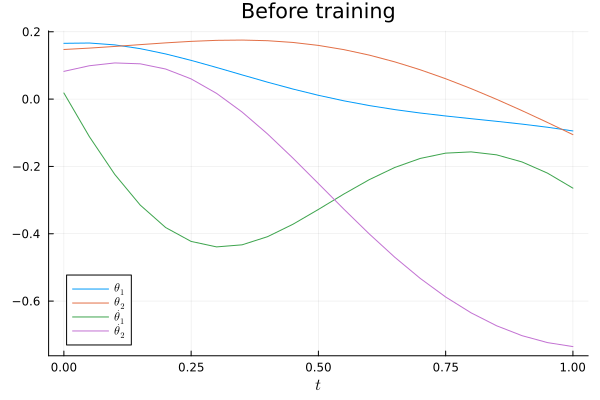

cost(p, x_0) = 0.5280688280882462
cost(p, x_0) = 0.5066149253387513
cost(p, x_0) = 0.510792741369559
cost(p, x_0) = 0.503582571449948
cost(p, x_0) = 0.5034888919441602
cost(p, x_0) = 0.5028029660434515
cost(p, x_0) = 0.5021616067559626
cost(p, x_0) = 0.5015936818478912
cost(p, x_0) = 0.5011357384354208
cost(p, x_0) = 0.5007233683993125


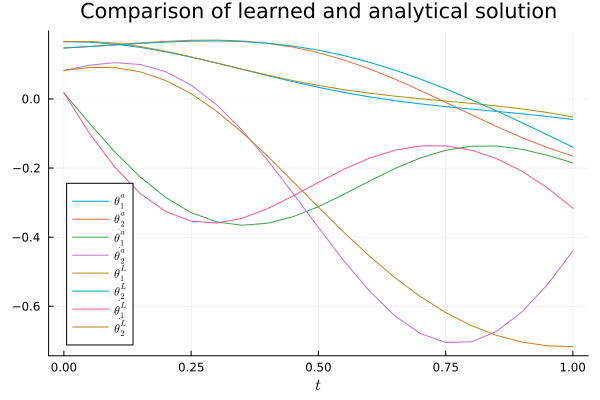

In [695]:
opt = ADAM(0.001)
ts, L_dat = forward_pass(p, x_0)
display(plot(ts, L_dat, label=label=[raw"$\theta_1$" raw"$\theta_2$" raw"$\dot{\theta_1}$" raw"$\dot{\theta_2}$" ], 
        xlabel=raw"$t$", title="Before training"))

for i in 1:100
    grads = FiniteDiff.finite_difference_gradient((p) -> cost(p, x_0), p)
    Flux.update!(opt, p, grads)
    if i%10==0
        @show cost(p, x_0)
    end
    Lossvec[i] = cost(p, x_0)
end

ts, L_dat = forward_pass(p, x_0)
ts, dat = anal_sol(x_0)
#display(plot(ts, L_dat, label=label=[raw"$\theta_1$" raw"$\theta_2$" raw"$\dot{\theta_1}$" raw"$\dot{\theta_2}$" ], 
 #       xlabel=raw"$t$", title="After training"))
plot(ts, dat, label=[raw"$\theta_1^a$" raw"$\theta_2^a$" raw"$\dot{\theta_1^a}$" raw"$\dot{\theta_2^a}$" ])
pltt = plot!(ts, L_dat, title="Comparison of learned and analytical solution", label=[raw"$\theta_1^L$" raw"$\theta_2^L$" raw"$\dot{\theta_1^L}$" raw"$\dot{\theta_2^L}$" ],
xlabel=raw"$t$")

### Lossplotting

In [ ]:
p1=plot(1:1400, Lossvec, yaxis=:log, title="Losses over training", label="Training loss", ylabel="Mean squared error", xlabel="Train step")
savefig(p1, "loss.png")

## Augmented training for big network

In [281]:
NN_model_c = Chain( #Make a large
    Dense(4, 128, softplus), Dense(128, 1, softplus)
)

p_c, re_c = Flux.destructure(NN_model_c);

In [282]:
function cost_aug(p)
    x = -ones(4)*2 + rand(Float32,4)*4
    an_lag = analytical_Lagrangian(x)
    NN_lag = re_c(p)(x)[1]
    return (an_lag .- NN_lag)^2
end

cost_cheat (generic function with 1 method)

In [48]:
Zygote.gradient(cost_aug, p_c)[1];

In [ ]:
opt = ADAM(0.001)

for i in 1:10000
    grads = Zygote.gradient(cost_aug, p_c)[1]
    Flux.update!(opt, p_c, grads)
    if i%1000==0
        @show cost_aug(p_c)
    end
end

#### Saving the parameter for the big LNN

In [515]:
p_c_beast = deepcopy(p_c)
re_c_beast = deepcopy(re_c);
mod_beast = deepcopy(re_c(p_c));

In [516]:
## Backup
p_c_beast_backup = deepcopy(p_c_beast)
re_c_beast_backup = deepcopy(re_c_beast)
mod_beast_backup = deepcopy(mod_beast);

In [438]:
mod = re_c(p_c);

### Training after augmentation

In [ ]:
p_big = deepcopy(p_c);

In [ ]:
function cost_big(p, x_0)
    ts, L_dat = forward_pass_energy(p, x_0; t_end=1.0)
    ts, true_dat = anal_sol_energy(x_0; t_end=1.0)
    return norm(L_dat .- true_dat, 2)
end

In [ ]:
opt = ADAM(0.001)

for i in 1:15
    grads = FiniteDiff.finite_difference_gradient((p) -> cost_big(p, x_0), p_big)
    Flux.update!(opt, p_big, grads)
    @show cost_big(p_big, x_0)
end

ts, L_dat = forward_pass_energy(p_big, x_0; t_end=1.0)
ts, dat = anal_sol_energy(x_0; t_end=1.0)
plot(ts, dat, label=[raw"$\theta_1^a$" raw"$\theta_2^a$" raw"$\dot{\theta_1^a}$" raw"$\dot{\theta_2^a}$" ])
pltt = plot!(ts, L_dat, title="Comparison of learned and analytical solution", label=[raw"$\theta_1^L$" raw"$\theta_2^L$" raw"$\dot{\theta_1^L}$" raw"$\dot{\theta_2^L}$" ],
xlabel=raw"$t$")

## Energy plotting

In [417]:
function RHS_lag_energy(du, u, p, t) #must modify to take in different model
    N = size(u, 1)÷2
    # Check if views work here later
    q = u[1:N]
    v = u[N+1:end]
    
    # Assuming single output for now, we treat L as a scalar, otherwise we would have to
    # do something integration-like for a lagrangian density
    function L(q, v, p)
        re_c(p)([q;v])[1]
    end

    L_q  = (q, v, p) -> Zygote.gradient( x -> L(x, v, p), q)[1]
    L_v  = (q, v, p) -> Zygote.gradient( x -> L(q, x, p), v)[1]
    L_vq = (q, v, p) -> ForwardDiff.jacobian(x -> L_v(x, v, p), q)
    ∇ᵥ²L = (q, v, p) -> Zygote.hessian( x -> L(q, x, p), v)

    # pinv for stability and non-singularity
    ∇ᵥ²L⁻¹ = (q, v, p) -> pinv(∇ᵥ²L(q, v, p))
    v̇ = ∇ᵥ²L⁻¹(q,v,p)*(L_q(q,v,p) - L_vq(q,v,p) * v)
    return du .= vcat(v, v̇)
end

RHS_lag_energy (generic function with 1 method)

In [549]:
function anal_sol_energy(x_0; t_end=1.0)
    tsteps = 0:0.01:t_end
    prob = ODEProblem(anal_RHS, x_0, (0.0, t_end), p, saveat=tsteps) #p does nothing, only temp
    sol = solve(prob, Tsit5(), dt=0.01)
    data = sol(tsteps)
    return tsteps, data'
end

function forward_pass_energy(p, x_0; t_end=1.0)
    tsteps = 0:0.01:t_end
    prob = ODEProblem(RHS_lag_energy, x_0, (0.0, t_end), p, saveat=tsteps)
    sol = solve(prob, Tsit5(), dt=0.01)
    data = sol(tsteps)
    return tsteps, data'
end

forward_pass_energy (generic function with 2 methods)

In [392]:
x_0 = rand(4)*0.2;

In [444]:
ts, sol_NN_energy = forward_pass_energy(p_c, x_0)
ts, sol_an_energy = anal_sol_energy(x_0);

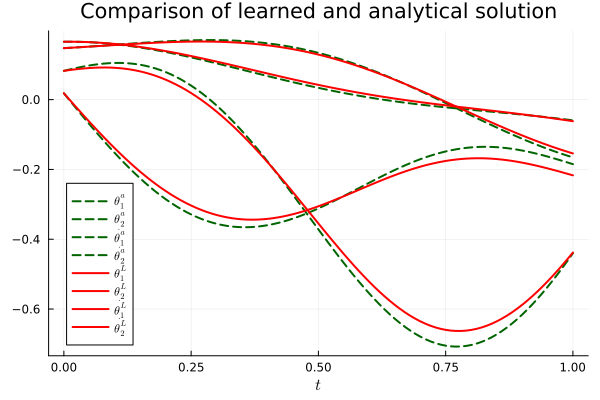

In [478]:
plot(ts, sol_an_energy, label=[raw"$\theta_1^a$" raw"$\theta_2^a$" raw"$\dot{\theta_1^a}$" raw"$\dot{\theta_2^a}$" ], color = :darkgreen, linewidth=2, linestyle=:dash)
pltt = plot!(ts, sol_NN_energy, title="Comparison of learned and analytical solution", label=[raw"$\theta_1^L$" raw"$\theta_2^L$" raw"$\dot{\theta_1^L}$" raw"$\dot{\theta_2^L}$" ],
xlabel=raw"$t$", color = :red, linewidth=2) 


#### Testing to long range in time

In [508]:
ts_lr, sol_NN_energy_lr = forward_pass_energy(p_c, x_0; t_end=30.0)
ts_lr, sol_an_energy_lr = anal_sol_energy(x_0; t_end=30.0);

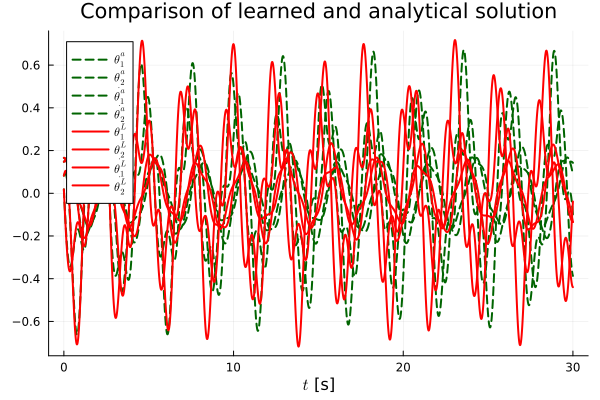

In [512]:
plot(ts_lr, sol_an_energy_lr, label=[raw"$\theta_1^a$" raw"$\theta_2^a$" raw"$\dot{\theta_1^a}$" raw"$\dot{\theta_2^a}$" ], palette = :darkgreen, linewidth=2, linestyle=:dash)
pltt = plot!(ts_lr, sol_NN_energy_lr, title="Comparison of learned and analytical solution", label=[raw"$\theta_1^L$" raw"$\theta_2^L$" raw"$\dot{\theta_1^L}$" raw"$\dot{\theta_2^L}$" ],
xlabel=raw"$t$ [s]", color = :red, linewidth=2) 

## Plotting energy evolution for trained and analytical

In [467]:
function energy(x)
    m1, m2, l1, l2, g = (1, 1, 1, 1, 9.81)
    t1, t2 = x[1:2]     # theta 1 and theta 2
    w1, w2 = x[3:4] # omega 1 and omega 2


    # kinetic energy (T)
    T1 = 0.5 * m1 * (l1 * w1)^2
    T2 = 0.5 * m2 * ((l1 * w1)^2 + (l2 * w2)^2 +
                    2 * l1 * l2 * w1 * w2 * cos(t1 - t2))
    T = T1 + T2

    # potential energy (V)
    y1 = -l1 * cos(t1)
    y2 = y1 - l2 * cos(t2)
    V = m1 * g * y1 + m2 * g * y2

    return T + V
end

energy (generic function with 1 method)

In [633]:
function get_energy_vec(sol)
    e_vec = zeros(length(sol[:,1]))
    for i in 1:length(sol[:,1])
        e_vec[i] = energy(sol[i,:])
    end
    return e_vec
end

get_energy_vec (generic function with 1 method)

In [510]:
e_vec_an = get_energy_vec(sol_an_energy_lr);
e_vec_NN = get_energy_vec(sol_NN_energy_lr);

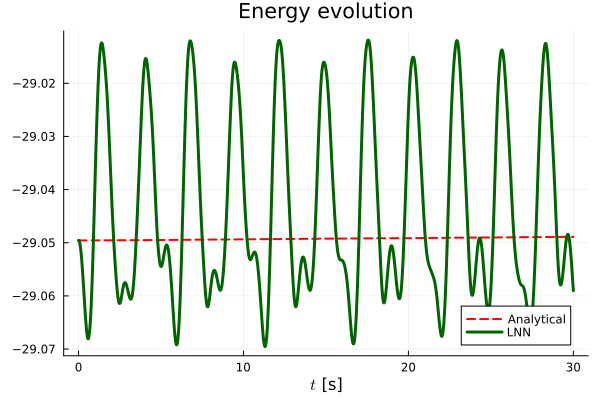

In [511]:
plot(ts_lr, e_vec_an, label=raw"Analytical", color = :red, linewidth=2, linestyle=:dash)
pltt = plot!(ts_lr, e_vec_NN, title="Energy evolution", label=raw"LNN",
xlabel=raw"$t$ [s]", color = :darkgreen, linewidth=3)

### Performing one descent step on our big network

## Short term prediction

In [651]:
ts_st, sol_NN_energy_st = forward_pass_energy(p_big, x_0; t_end=1.0)
ts_st, sol_an_energy_st = anal_sol_energy(x_0; t_end=1.0);
sol_NODE_st = deepcopy(sol_NODE[1:101,:]);

In [687]:
plot(ts_st, sol_an_energy_st, label=[raw"$\theta_1^a$" raw"$\theta_2^a$" raw"$\dot{\theta_1^a}$" raw"$\dot{\theta_2^a}$" ], color = :magenta1, linewidth=2, linestyle=:dash)
pltt = plot!(ts_st, sol_NN_energy_st, title="Training interval, LNN", label=[raw"$\theta_1^L$" raw"$\theta_2^L$" raw"$\dot{\theta_1^L}$" raw"$\dot{\theta_2^L}$" ],
xlabel=raw"$t$ [s]", color = :cyan3, linewidth=3)
plot(ts_st, sol_an_energy_st, label=[raw"$\theta_1^a$" raw"$\theta_2^a$" raw"$\dot{\theta_1^a}$" raw"$\dot{\theta_2^a}$" ], color = :magenta1, linewidth=2, linestyle=:dash)
pltt2 = plot!(ts_st, sol_NODE_st, title="Training interval, NODE", label=[raw"$\theta_1^N$" raw"$\theta_2^N$" raw"$\dot{\theta_1^N}$" raw"$\dot{\theta_2^N}$" ],
xlabel=raw"$t$ [s]", color = :goldenrod2, linewidth=2)
pt_tr = plot(pltt, pltt2, layout = (1,2), size=(1000,300), margin=5Plots.mm)
savefig(pt_tr, "comp_train.png")

"/Users/Ulrik/Documents/Skole/S8/18_337/Psets/Finalproject_test/comp_train.png"

## Long term prediction

In [654]:
ts_lr, sol_NN_energy_lr = forward_pass_energy(p_big, x_0; t_end=30.0)
ts_lr, sol_an_energy_lr = anal_sol_energy(x_0; t_end=30.0);

In [686]:
plot(ts_lr, sol_an_energy_lr, label=[raw"$\theta_1^a$" raw"$\theta_2^a$" raw"$\dot{\theta_1^a}$" raw"$\dot{\theta_2^a}$" ], color = :magenta1, linewidth=2, linestyle=:dash)
pltt = plot!(ts_lr, sol_NN_energy_lr, title="Prediction, LNN", label=[raw"$\theta_1^L$" raw"$\theta_2^L$" raw"$\dot{\theta_1^L}$" raw"$\dot{\theta_2^L}$" ],
xlabel=raw"$t$ [s]", color = :cyan3, linewidth=3)
plot(ts_lr, sol_an_energy_lr, label=[raw"$\theta_1^a$" raw"$\theta_2^a$" raw"$\dot{\theta_1^a}$" raw"$\dot{\theta_2^a}$" ], color = :magenta1, linewidth=2, linestyle=:dash)
pltt2 = plot!(ts_lr, sol_NODE, title="Prediction, NODE", label=[raw"$\theta_1^N$" raw"$\theta_2^N$" raw"$\dot{\theta_1^N}$" raw"$\dot{\theta_2^N}$" ],
xlabel=raw"$t$ [s]", color = :goldenrod2, linewidth=2)
pt_lr = plot(pltt, pltt2, layout = (1,2), size=(1100,350), margin=4Plots.mm)
savefig(pt_lr, "comp_lr.png")


"/Users/Ulrik/Documents/Skole/S8/18_337/Psets/Finalproject_test/comp_lr.png"

## Energy evolution

In [635]:
e_vec_an = get_energy_vec(sol_an_energy_lr);
e_vec_LNN = get_energy_vec(sol_NN_energy_lr);
e_vec_NODE = get_energy_vec(sol_NODE);

In [678]:
plot(ts_lr, e_vec_an, label=raw"Analytical", color = :magenta1, linewidth=2, linestyle=:dash)
pltt = plot!(ts_lr, e_vec_LNN, title="Long term energy evolution", label=raw"LNN",
xlabel=raw"$t$ [s]", color = :cyan3, linewidth=3)
plot!(ts_lr, e_vec_NODE, title="Energy evolution", label=raw"NODE",
xlabel=raw"$t$ [s]", color = :goldenrod2, linewidth=3)
pt_en = plot(pltt, layout = (1,1), size=(600,400), margin=5Plots.mm)
savefig(pt_en, "en_ev.png")

"/Users/Ulrik/Documents/Skole/S8/18_337/Psets/Finalproject_test/en_ev.png"

In [576]:
sol_NODE = mapreduce(permutedims, vcat, sol_NODE_vec);

### Naivly imported the solution of the NODE for $t\in[0,30]$, which was performed on Henrik's computer

In [575]:
sol_NODE_vec = Vector{Float32}[[0.16573343, 0.14740238, 0.018178359, 0.082387626], [0.16533883, 0.14720012, -2.7305186f-5, 0.086950436], [0.16472708, 0.14712033, -0.018079804, 0.09129961], [0.16390209, 0.1471601, -0.0359559, 0.09539805], [0.16286826, 0.14731579, -0.05363236, 0.09920926], [0.16163027, 0.14758328, -0.07108596, 0.10269734], [0.16019315, 0.14795789, -0.08829326, 0.105827056], [0.15856235, 0.14843425, -0.10523073, 0.10856363], [0.15674366, 0.14900644, -0.12187469, 0.110873215], [0.1547432, 0.14966792, -0.13820137, 0.11272296], [0.15256742, 0.15041155, -0.15418705, 0.11408106], [0.15022314, 0.15122965, -0.16980752, 0.11491662], [0.14771745, 0.15211399, -0.18503875, 0.11519998], [0.14505772, 0.15305582, -0.19985658, 0.11490285], [0.14225163, 0.15404586, -0.21423696, 0.11399829], [0.13930707, 0.15507437, -0.22815593, 0.11246077], [0.13623218, 0.15613121, -0.24158959, 0.1102665], [0.13303539, 0.15720579, -0.25451407, 0.10739303], [0.12972522, 0.15828717, -0.2669059, 0.10381971], [0.12631035, 0.15936425, -0.27874234, 0.09952803], [0.12279957, 0.16042571, -0.29000127, 0.0945015], [0.11920174, 0.16146006, -0.30066133, 0.08872573], [0.11552584, 0.16245559, -0.31070197, 0.082188405], [0.11178084, 0.16340075, -0.320104, 0.07488008], [0.10797574, 0.16428378, -0.32884887, 0.06679296], [0.10411955, 0.16509303, -0.33691952, 0.057921927], [0.1002211, 0.16581717, -0.34430104, 0.048264988], [0.09628911, 0.1664451, -0.35098052, 0.037823234], [0.09233217, 0.1669661, -0.3569471, 0.02660086], [0.08835871, 0.16736966, -0.36219198, 0.014605165], [0.084377035, 0.16764562, -0.36670852, 0.0018465498], [0.08039515, 0.16778429, -0.37049282, -0.011661144], [0.07642095, 0.16777648, -0.3735434, -0.025900565], [0.07246206, 0.1676134, -0.37586108, -0.04085193], [0.06852586, 0.16728677, -0.37744927, -0.056491874], [0.064619415, 0.16678886, -0.37831426, -0.072793595], [0.060749553, 0.16611254, -0.37846518, -0.08972682], [0.05692278, 0.16525121, -0.37791383, -0.1072578], [0.053145338, 0.16419883, -0.37667492, -0.12534934], [0.049423184, 0.16294992, -0.37476593, -0.1439608], [0.04576199, 0.16149956, -0.37220713, -0.16304804], [0.042167082, 0.15984334, -0.36902124, -0.18256423], [0.03864361, 0.15797731, -0.36523163, -0.20246178], [0.03519645, 0.15589789, -0.36086535, -0.22268873], [0.031830233, 0.15360197, -0.35595125, -0.24319075], [0.02854928, 0.15108694, -0.3505197, -0.2639121], [0.025357608, 0.14835067, -0.34460238, -0.28479567], [0.022258924, 0.14539148, -0.33823246, -0.3057829], [0.019256635, 0.14220819, -0.33144447, -0.32681388], [0.016353833, 0.13880007, -0.32427436, -0.3478272], [0.01355331, 0.1351669, -0.31675953, -0.36876014], [0.010857549, 0.13130891, -0.30893868, -0.3895485], [0.008268683, 0.1272268, -0.3008519, -0.41012713], [0.0057883007, 0.12292232, -0.29253763, -0.4304344], [0.003417801, 0.11839721, -0.28403568, -0.45040742], [0.0011583744, 0.11365359, -0.27538767, -0.46998116], [-0.0009893244, 0.10869444, -0.26663473, -0.48909277], [-0.0030251774, 0.1035236, -0.25781757, -0.50768155], [-0.0049496023, 0.09814574, -0.24897633, -0.52568907], [-0.006763554, 0.092566416, -0.24015078, -0.5430589], [-0.008468524, 0.08679202, -0.23138012, -0.55973685], [-0.010066537, 0.080829814, -0.22270314, -0.575671], [-0.011560159, 0.07468789, -0.21415813, -0.59081143], [-0.012952489, 0.06837523, -0.20578289, -0.6051106], [-0.014247162, 0.06190163, -0.19761479, -0.6185228], [-0.015448161, 0.055277362, -0.18968934, -0.63100636], [-0.01655976, 0.048513666, -0.18203902, -0.6425251], [-0.017587403, 0.041623324, -0.17469677, -0.6530457], [-0.01853677, 0.034619603, -0.16769347, -0.6625385], [-0.019413738, 0.027516115, -0.16105774, -0.67097753], [-0.02022438, 0.020326825, -0.15481588, -0.6783407], [-0.020974971, 0.013066041, -0.14899191, -0.6846096], [-0.021671994, 0.0057484177, -0.14360754, -0.68977], [-0.022322122, -0.0016110418, -0.13868219, -0.69381106], [-0.022932235, -0.008996987, -0.13423298, -0.6967262], [-0.023509411, -0.016393721, -0.13027473, -0.6985123], [-0.024060927, -0.0237852, -0.12681995, -0.69917035], [-0.024594197, -0.031155271, -0.123878814, -0.6987049], [-0.025115423, -0.03848967, -0.12145857, -0.69712234], [-0.025631223, -0.0457736, -0.11956336, -0.69443387], [-0.026148308, -0.052992027, -0.118195206, -0.6906537], [-0.02667305, -0.06013055, -0.117353976, -0.68579835], [-0.027211485, -0.0671754, -0.117037386, -0.6798867], [-0.02776931, -0.07411343, -0.117240995, -0.67293984], [-0.028351884, -0.08093214, -0.117958225, -0.6649811], [-0.02896423, -0.087619655, -0.11918033, -0.6560362], [-0.029611036, -0.09416472, -0.120896414, -0.64613295], [-0.030296644, -0.10055673, -0.123093426, -0.6353016], [-0.031025069, -0.1067857, -0.12575617, -0.6235746], [-0.03179998, -0.112842284, -0.1288673, -0.61098677], [-0.032624714, -0.11871775, -0.13240731, -0.597575], [-0.03350227, -0.124404036, -0.13635452, -0.5833787], [-0.034435324, -0.12989384, -0.1406874, -0.5684362], [-0.03542621, -0.13518022, -0.14538498, -0.55278474], [-0.036477026, -0.14025702, -0.1504223, -0.5364654], [-0.037589565, -0.14511849, -0.15577345, -0.5195202], [-0.038765352, -0.14975943, -0.16141155, -0.5019921], [-0.040005613, -0.15417516, -0.16730891, -0.4839248], [-0.041311305, -0.15836157, -0.17343687, -0.46536276], [-0.04268309, -0.16231501, -0.17976587, -0.44635126], [-0.044121355, -0.1660324, -0.18626544, -0.42693648], [-0.045626197, -0.1695112, -0.19290423, -0.40716523], [-0.047197428, -0.17274939, -0.19964996, -0.3870853], [-0.04883458, -0.17574546, -0.20646946, -0.3667451], [-0.05053691, -0.17849845, -0.21332861, -0.34619403], [-0.052303374, -0.18100794, -0.22019246, -0.32548213], [-0.05413271, -0.18327402, -0.22702627, -0.30465874], [-0.056023594, -0.18529661, -0.23379965, -0.28376886], [-0.057974618, -0.1870759, -0.24047579, -0.26286387], [-0.059984107, -0.18861246, -0.24701716, -0.2419962], [-0.06205014, -0.18990728, -0.253387, -0.22121727], [-0.06417057, -0.1909618, -0.25954932, -0.2005776], [-0.06634299, -0.19177788, -0.26546893, -0.1801268], [-0.06856477, -0.19235781, -0.2711113, -0.15991355], [-0.07083305, -0.19270432, -0.27644283, -0.13998559], [-0.07314471, -0.19282055, -0.2814305, -0.12038977], [-0.0754964, -0.19271009, -0.28604227, -0.10117198], [-0.07788453, -0.19237694, -0.2902467, -0.08237721], [-0.080305286, -0.19182555, -0.29401314, -0.064049534], [-0.08275458, -0.1910608, -0.29731178, -0.04623209], [-0.08522813, -0.19008797, -0.30011356, -0.028967096], [-0.08772138, -0.1889128, -0.3023901, -0.012295846], [-0.090229794, -0.1875412, -0.30411705, 0.0037455151], [-0.092748754, -0.18597913, -0.30527365, 0.019124541], [-0.09527318, -0.18423323, -0.30583477, 0.03380345], [-0.097797826, -0.18231057, -0.30577782, 0.047747225], [-0.10031728, -0.18021856, -0.30508292, 0.0609242], [-0.10282598, -0.177965, -0.30373308, 0.073306054], [-0.105318226, -0.17555805, -0.30171418, 0.08486783], [-0.10778818, -0.17300622, -0.2990148, 0.0955879], [-0.11022987, -0.17031844, -0.29562643, 0.10544802], [-0.112637155, -0.16750394, -0.29154333, 0.11443327], [-0.11500376, -0.16457237, -0.28676265, 0.1225321], [-0.11732326, -0.16153373, -0.28128424, 0.12973629], [-0.1195891, -0.15839839, -0.27511084, 0.136041], [-0.12179457, -0.15517709, -0.26824805, 0.14144471], [-0.123932816, -0.15188093, -0.2607042, 0.14594929], [-0.12599707, -0.14852104, -0.2524903, 0.14956014], [-0.12798153, -0.14510709, -0.24361995, 0.15228581], [-0.12987934, -0.1416507, -0.23410912, 0.15413716], [-0.13168348, -0.13816383, -0.22397695, 0.15512842], [-0.1333872, -0.13465819, -0.2132455, 0.15527764], [-0.13498402, -0.13114524, -0.20193973, 0.15460667], [-0.13646773, -0.12763615, -0.19008756, 0.1531412], [-0.13783242, -0.12414189, -0.17771983, 0.1509107], [-0.13907239, -0.12067309, -0.16487029, 0.14794843], [-0.14018227, -0.1172402, -0.15157564, 0.14429149], [-0.14115694, -0.11385335, -0.13787551, 0.13998075], [-0.14199153, -0.11052245, -0.12381245, 0.13506094], [-0.14268145, -0.10725713, -0.10943195, 0.12958051], [-0.1432224, -0.10406675, -0.09478242, 0.123591825], [-0.14361034, -0.100960456, -0.0799152, 0.11715097], [-0.1438423, -0.097945616, -0.06487857, 0.11031157], [-0.14391658, -0.09502771, -0.049717728, 0.10312387], [-0.14383037, -0.092214465, -0.034490623, 0.095652595], [-0.14358138, -0.08951284, -0.019254882, 0.08796253], [-0.14316799, -0.08692884, -0.0040671434, 0.08011787], [-0.1425892, -0.084467545, 0.011016957, 0.07218225], [-0.14184466, -0.08213309, 0.025942784, 0.06421877], [-0.14093469, -0.079928696, 0.040656693, 0.05628992], [-0.1398602, -0.07785661, 0.05510605, 0.048457652], [-0.13862276, -0.075918175, 0.069239214, 0.040783346], [-0.1372246, -0.074113786, 0.08300553, 0.03332781], [-0.13566856, -0.0724429, 0.096355364, 0.026151288], [-0.13395816, -0.07090403, 0.10924006, 0.019313462], [-0.13209754, -0.06949478, 0.12161198, 0.012873447], [-0.13009147, -0.06821178, 0.13342448, 0.0068897866], [-0.12794536, -0.067050755, 0.14463188, 0.0014204645], [-0.1256653, -0.06600648, 0.15518956, -0.003477105], [-0.12325799, -0.06507279, 0.16505384, -0.007746073], [-0.120729476, -0.06424428, 0.174192, -0.011343325], [-0.118085235, -0.06351655, 0.1825829, -0.014240886], [-0.11533239, -0.06288259, 0.19019842, -0.016399844], [-0.11247833, -0.062334973, 0.1970141, -0.01778562], [-0.10953066, -0.06186587, 0.20300938, -0.018368261], [-0.1064972, -0.06146706, 0.20816776, -0.018122442], [-0.103385985, -0.061129913, 0.2124766, -0.017027458], [-0.10020528, -0.060845405, 0.2159273, -0.015067234], [-0.09696353, -0.06060411, 0.21851519, -0.012230316], [-0.09366944, -0.060396194, 0.22023958, -0.008509877], [-0.09033188, -0.06021143, 0.22110373, -0.0039037147], [-0.08695968, -0.060039587, 0.22111431, 0.0015862092], [-0.08356137, -0.059870936, 0.22028011, 0.007954729], [-0.080145806, -0.05969501, 0.21861398, 0.015192241], [-0.07672178, -0.059501424, 0.21613209, 0.023284731], [-0.073297925, -0.059279945, 0.21285383, 0.032213833], [-0.06988274, -0.059020445, 0.2088019, 0.041956827], [-0.06648461, -0.05871295, 0.20400217, 0.052486647], [-0.06311173, -0.05834761, 0.19848384, 0.063771866], [-0.05977221, -0.0579147, 0.19227935, 0.075776726], [-0.056473985, -0.057404637, 0.18542436, 0.0884611], [-0.053224497, -0.056808513, 0.17795728, 0.10178095], [-0.050030485, -0.056118723, 0.16991788
, 0.115689225], [-0.046899483, -0.05532604, 0.1613483, 0.13013624], [-0.04383872, -0.054421734, 0.15229209, 0.1450697], [-0.04085496, -0.05339776, 0.14279418, 0.16043486], [-0.037954528, -0.052246757, 0.13290079, 0.17617454], [-0.03514328, -0.050962046, 0.12265945, 0.19222908], [-0.032426625, -0.04953764, 0.11211903, 0.20853639], [-0.029809525, -0.04796822, 0.10132967, 0.22503196], [-0.027296482, -0.046249166, 0.09034287, 0.24164878], [-0.024891544, -0.04437653, 0.079211414, 0.2583174], [-0.02259831, -0.04234706, 0.06798941, 0.274966], [-0.02041992, -0.040158167, 0.056732286, 0.2915202], [-0.018359065, -0.03780797, 0.045496773, 0.30790323], [-0.01641798, -0.03529526, 0.034340926, 0.32403585], [-0.014598351, -0.032619555, 0.023321865, 0.33983943], [-0.012901267, -0.029781513, 0.012483096, 0.35525236], [-0.011327767, -0.026781691, 0.0018761266, 0.370201], [-0.009878442, -0.023621432, -0.008446723, 0.3846103], [-0.008553287, -0.020302985, -0.018435419, 0.39840788], [-0.0073517063, -0.016829511, -0.028042216, 0.41152412], [-0.006272508, -0.013205089, -0.03722165, 0.42389223], [-0.0053139077, -0.009434705, -0.045930553, 0.43544802], [-0.004473529, -0.0055242595, -0.054128036, 0.4461302], [-0.0037483997, -0.0014805661, -0.061775498, 0.45588005], [-0.0031349557, 0.002688651, -0.06883662, 0.46464178], [-0.0026290384, 0.006974754, -0.07527739, 0.47236222], [-0.0022258968, 0.011368194, -0.08106605, 0.478991], [-0.001920602, 0.01585924, -0.08617615, 0.48448607], [-0.0017081349, 0.020437766, -0.09058498, 0.48881122], [-0.0015827301, 0.025092676, -0.09427052, 0.4919299], [-0.0015383157, 0.029812342, -0.09721455, 0.4938115], [-0.001568506, 0.03458465, -0.09940278, 0.4944314], [-0.0016666017, 0.039397, -0.10082481, 0.4937712], [-0.0018255905, 0.044236317, -0.10147418, 0.49181834], [-0.002038146, 0.049089033, -0.101348326, 0.48856646], [-0.0022966284, 0.053941097, -0.10044859, 0.48401523], [-0.0025930847, 0.058777984, -0.098780245, 0.4781703], [-0.0029192483, 0.06358468, -0.09635245, 0.47104344], [-0.0032665387, 0.06834567, -0.093178295, 0.46265247], [-0.0036263906, 0.07304558, -0.08927433, 0.45302063], [-0.003991462, 0.077670716, -0.08465864, 0.44217485], [-0.0043535326, 0.08220615, -0.07935322, 0.43014804], [-0.004704463, 0.08663707, -0.073383, 0.41697788], [-0.005036376, 0.09094913, -0.0667756, 0.4027064], [-0.0053416593, 0.095128424, -0.059561294, 0.38738012], [-0.0056129633, 0.09916152, -0.051773056, 0.37104988], [-0.0058432035, 0.10303544, -0.04344654, 0.35377097], [-0.006025559, 0.10673767, -0.034620084, 0.3356031], [-0.006153472, 0.11025616, -0.0253347, 0.31661025], [-0.006220649, 0.1135793, -0.015634086, 0.29686102], [-0.0062210606, 0.116695955, -0.0055646254, 0.27642825], [-0.0061490797, 0.11959574, 0.0048256177, 0.25538749], [-0.006000286, 0.12227029, 0.015491945, 0.23380919], [-0.0057701725, 0.12471117, 0.026385855, 0.2117698], [-0.0054546427, 0.12691066, 0.03745771, 0.18934771], [-0.0050501763, 0.12886208, 0.04865784, 0.16662128], [-0.004553828, 0.13055982, 0.05993653, 0.1436688], [-0.003963228, 0.13199927, 0.07124405, 0.120568596], [-0.0032765826, 0.13317688, 0.08253062, 0.09739894], [-0.0024926735, 0.13409014, 0.09374642, 0.074238084], [-0.0016108576, 0.13473761, 0.10484162, 0.05116427], [-0.00063106715, 0.13511884, 0.11576633, 0.028255705], [0.00044618954, 0.13523449, 0.12647064, 0.0055905813], [0.0016198702, 0.13508616, 0.13690594, -0.016755017], [0.0028884753, 0.13467634, 0.14702918, -0.038713362], [0.004249986, 0.13400845, 0.15679587, -0.060215004], [0.0057019033, 0.13308683, 0.16616301, -0.08119253], [0.0072412747, 0.13191664, 0.17508978, -0.101581834], [0.008864693, 0.13050392, 0.1835376, -0.12132212], [0.010568299, 0.12885554, 0.19147013, -0.14035587], [0.012347777, 0.12697923, 0.19885328, -0.15862891], [0.014198358, 0.12488356, 0.2056552, -0.17609031], [0.016114822, 0.12257797, 0.21184623, -0.19269249], [0.01809149, 0.12007274, 0.21739899, -0.20839116], [0.020122232, 0.117379, 0.22228831, -0.2231453], [0.022200735, 0.11450828, 0.22649203, -0.23691835], [0.024320962, 0.11147156, 0.22999199, -0.24967849], [0.026476206, 0.10828121, 0.2327709, -0.2613955], [0.028659593, 0.104949884, 0.23481388, -0.27204254], [0.03086416, 0.10149046, 0.23610866, -0.28159648], [0.03308287, 0.097915985, 0.23664565, -0.29003796], [0.03530859, 0.0942397, 0.2364179, -0.29735145], [0.037534114, 0.090475015, 0.23542108, -0.30352515], [0.03975215, 0.08663557, 0.23365352, -0.30855104], [0.04195533, 0.082735136, 0.23111618, -0.31242493], [0.044136185, 0.07878772, 0.22781268, -0.3151463], [0.04628718, 0.074807495, 0.2237493, -0.3167185], [0.04840069, 0.07080882, 0.21893492, -0.3171486], [0.05046909, 0.06680607, 0.21338102, -0.31644744], [0.05248578, 0.0628118, 0.20710044, -0.31462806], [0.05444381, 0.058839295, 0.20010732, -0.3117055], [0.05633604, 0.054902256, 0.19241805, -0.30769792], [0.05815559, 0.051013913, 0.18405096, -0.3026268], [0.059895847, 0.04718704, 0.17502639, -0.29651675], [0.06155046, 0.043433953, 0.16536665, -0.2893957], [0.06311335, 0.039766494, 0.15509607, -0.2812948], [0.06457869, 0.03619605, 0.14424099, -0.27224836], [0.065940924, 0.03273354, 0.1328297, -0.26229402], [0.06719477, 0.02938943, 0.12089251, -0.2514726], [0.06833518, 0.026173716, 0.10846172, -0.23982812], [0.06935742, 0.023095936, 0.09557163, -0.22740792], [0.07025697, 0.02016516, 0.08225851, -0.21426247], [0.07102967, 0.017389862, 0.068560146, -0.2004449], [0.07167227, 0.014776904, 0.054511905, -0.18600495], [0.072181314, 0.012333486, 0.04015156, -0.17099726], [0.072553515, 0.010066556, 0.025519025, -0.15547992], [0.07278601, 0.007982274, 0.010654784, -0.13951218], [0.07287638, 0.006086011, -0.004400116, -0.123154394], [0.07282264, 0.0043823537, -0.019604055, -0.10646803], [0.07262326, 0.0028751013, -0.034914847, -0.08951567], [0.07227713, 0.0015672636, -0.05028974, -0.07236105], [0.07178359, 0.00046106472, -0.06568541, -0.055069], [0.071142405, -0.0004420592, 
-0.08105795, -0.037705485], [0.0703538, -0.001141459, -0.09636292, -0.020337587], [0.06941842, -0.0016372728, -0.11155528, -0.0030335095], [0.06833736, -0.0019304262, -0.12658943, 0.014137419], [0.06711213, -0.0020226322, -0.1414192, 0.03110475], [0.065744676, -0.0019162962, -0.15599959, 0.04779962], [0.064237095, -0.0016138454, -0.17029119, 0.064162575], [0.06259186, -0.0011185458, -0.18425047, 0.08012673], [0.060811877, -0.0004344226, -0.19783407, 0.09562561], [0.05890051, 0.00043378526, -0.21099998, 0.11059515], [0.05686153, 0.0014806254, -0.22370763, 0.12497368], [0.05469916, 0.0026999316, -0.23591779, 0.13870192], [0.052418042, 0.0040848246, -0.24759266, 0.15172301], [0.050023254, 0.005627711, -0.2586958, 0.1639825], [0.047520302, 0.007320283, -0.2691922, 0.17542832], [0.044915136, 0.009153522, -0.2790482, 0.18601082], [0.042214125, 0.011117691, -0.2882316, 0.19568273], [0.039424073, 0.013202345, -0.2967115, 0.20439921], [0.036551893, 0.015396819, -0.30446082, 0.2121214], [0.0336045, 0.017690592, -0.3114564, 0.21881723], [0.030589536, 0.020071868, -0.31767198, 0.2244504], [0.027514849, 0.022528578, -0.32308397, 0.22898874], [0.024388416, 0.025048438, -0.3276717, 0.23240498], [0.021218343, 0.027618961, -0.33141753, 0.23467658], [0.018012876, 0.030227453, -0.3343068, 0.23578587], [0.014780388, 0.032861006, -0.33632785, 0.23571995], [0.01152939, 0.035506517, -0.337472, 0.23447071], [0.008268523, 0.03815066, -0.3377335, 0.23203486], [0.0050065606, 0.040779922, -0.3371097, 0.22841392], [0.0017524104, 0.043380562, -0.3356009, 0.22361422], [-0.0014848867, 0.04593865, -0.33321038, 0.21764687], [-0.0046961578, 0.04844003, -0.32994434, 0.2105278], [-0.007872144, 0.0508704, -0.32581207, 0.20227766], [-0.01100461, 0.053217348, -0.32082552, 0.1929204], [-0.01408553, 0.05546884, -0.31499827, 0.18248206], [-0.017106162, 0.0576117, -0.30834648, 0.17099321], [-0.020058086, 0.05963334, -0.30088925, 0.15848847], [-0.022933206, 0.06152177, -0.2926487, 0.1450065], [-0.025723752, 0.063265584, -0.28364992, 0.13059002], [-0.028422277, 0.06485397, -0.27392095, 0.11528584], [-0.031021658, 0.06627672, -0.26349282, 0.099144794], [-0.033515096, 0.06752421, -0.2523995, 0.082221776], [-0.03589612, 0.06858739, -0.24067798, 0.06457574], [-0.038158573, 0.069457844, -0.2283682, 0.0462697], [-0.040296637, 0.0701277, -0.21551308, 0.027370723], [-0.042304803, 0.07058972, -0.2021585, 0.007949931], [-0.044177983, 0.07083732, -0.18835285, -0.011918291], [-0.04591249, 0.07086629, -0.17414057, -0.032167245], [-0.047504496, 0.07067225, -0.1595709, -0.05272464], [-0.048950292, 0.07025116, -0.14469661, -0.07351367], [-0.050246853, 0.06960001, -0.12957068, -0.09445804], [-0.051391814, 0.068716876, -0.11424642, -0.11548196], [-0.052383486, 0.06760091, -0.09877741, -0.13651012], [-0.05322086, 0.06625236, -0.083217524, -0.15746775], [-0.053903587, 0.0646725, -0.0676209, -0.17828055], [-0.054432005, 0.06286371, -0.052041974, -0.19887476], [-0.05480711, 0.060829427, -0.036535464, -0.21917708], [-0.055030584, 0.058574185, -0.02115636, -0.23911476], [-0.05510477, 0.05610356, -0.005959949, -0.25861552], [-0.05503269, 0.05342423, 0.008998205, -0.2776076], [-0.05481804, 0.050543927, 0.023662254, -0.29601973], [-0.05446506, 0.047471218, 0.037977543, -0.31378296], [-0.05397749, 0.044213917, 0.051900927, -0.3308441], [-0.053360328, 0.040781613, 0.06538523, -0.3471468], [-0.05261912, 0.03718477, 0.07838302, -0.36263475], [-0.05175965, 0.033434194, 0.09084959, -0.3772551], [-0.050787948, 0.029541055, 0.102742955, -0.3909586], [-0.049710274, 0.02551687, 0.11402385, -0.4036995], [-0.048533134, 0.021373512, 0.12465576, -0.41543555], [-0.047263272, 0.017123207, 0.13460489, -0.42612812], [-0.04590767, 0.0127785355, 0.14384013, -0.435742], [-0.044473544, 0.008352429, 0.15233319, -0.44424558], [-0.04296836, 0.0038581719, 0.1600584, -0.45161077], [-0.041399814, -0.00069059554, 0.16699289, -0.457813], [-0.03977585, -0.0052798814, 0.17311649, -0.4628312], [-0.038104482, -0.009895636, 0.17841226, -0.46664837], [-0.0363925, -0.014525868, 0.18286875, -0.4692534], [-0.03464732, -0.019157669, 0.18647414, -0.47063434], [-0.032876596, -0.02377773, 0.18921854, -0.47078168], [-0.031087851, -0.028373003, 0.19109522, -0.46968976], [-0.029288484, -0.032930683, 0.19210063, -0.46735686], [-0.027485749, -0.037438232, 0.19223446, -0.4637851], [-0.025686774, -0.04188336, 0.1914995, -0.4589805], [-0.023898553, -0.04625404, 0.1899018, -0.4529529], [-0.022127943, -0.050538484, 0.18745054, -0.44571608], [-0.020381672, -0.054725178, 0.18415812, -0.4372877], [-0.018666336, -0.058802847, 0.18004009, -0.42768925], [-0.016988393, -0.06276049, 0.17511523, -0.41694614], [-0.015354174, -0.06658733, 0.16940545, -0.40508765], [-0.013769872, -0.070272885, 0.16293588, -0.39214692], [-0.012241368, -0.07380723, 0.15573388, -0.37815988], [-0.010773661, -0.0771819, 0.14782393, -0.3631602], [-0.009372342, -0.0803875, 0.1392351, -0.3471862], [-0.008042889, -0.08341488, 0.12999931, -0.33028013], [-0.006790438, -0.08625542, 0.12015043, -0.31248686], [-0.005619792, -0.08890112, 0.109724194, -0.29385403], [-0.004535413, -0.091344535, 0.09875827, -0.2744321], [-0.003541428, -0.09357882, 0.08729223, -0.25427416], [-0.0026416257, -0.095597714, 0.075367555, -0.23343611], [-0.0018394575, -0.097395524, 0.06302763, -0.21197656], [-0.0011380381, -0.09896714, 0.05031774, -0.18995689], [-0.00054014416, -0.10030806, 0.037285097, -0.1674412], [-4.8215385f-5, -0.10141433, 0.02397881, -0.14449634], [0.0003356459, -0.1022826, 0.010449903, -0.1211919], [0.00060967467, -0.1029101, -0.0032487002, -0.09760019], [0.00077252346, -0.103294775, -0.017065825, -0.07379168], [0.00082306855, -0.10343492, -0.030955113, -0.049831793], [0.0007602047, -0.103328936, -0.044862445, -0.025796006], [0.0005832362, -0.1029759, -0.058733508, -0.0017605259], [0.00029190298, -0.102375604, -0.07251449, 0.022198677], [-0.00011361993, -0.10152861, -0.08615211, 0.04600588], [-0.0006327218, -0.10043617, -0.099593565, 0.069585584], [-0.0012643567, -0.099100314, -0.11278661, 0.092862554], [-0.0020070428, -0.09752376, -0.1256795, 0.11576178], [-0.0028588637, -0.09570997, -0.13822095, 0.1382085], [-0.0038174666, -0.09366316, -0.15036027, 0.16012815], [-0.0048800637, -0.091388255, -0.16204724, 0.1814465], [-0.0060434327, -0.08889093, -0.17323214, 0.20208943], [-0.007303927, -0.086177535, -0.18386619, 0.22198384], [-0.008657535, -0.08325511, -0.19390868, 0.24106821], [-0.010100145, -0.0801308, -0.20331596, 0.2592757], [-0.011627281, -0.076812424, -0.21204291, 0.27653664], [-0.013234054, -0.0733085, -0.22004786, 0.29278603], [-0.014915167, -0.06962825, -0.22729242, 0.30796352], [-0.016664919, -0.06578164, -0.23374164, 0.32201335], [-0.018477192, -0.06177931, -0.23936391, 0.33488443], [-0.020345468, -0.057632636, -0.24413098, 0.34653038], [-0.022262815, -0.053353705, -0.248018, 0.35690933], [-0.024221892, -0.048955306, -0.25100347, 0.3659842], [-0.026214954, -0.044450954, -0.25306925, 0.37372243], [-0.028233841, -0.03985486, -0.25420058, 0.38009617], [-0.030269988, -0.03518197, -0.2543861, 0.38508222], [-0.032314453, -0.030447857, -0.2536178, 0.38866207], [-0.034359034, -0.025667036, -0.2518932, 0.39082658], [-0.036395486, -0.02085416, -0.24921155, 0.39156976], [-0.038414527, -0.016025584, -0.24557342, 0.39088586], [-0.040406965, -0.011197557, -0.24098338, 0.3887756], [-0.042363703, -0.0063862083, -0.23545013, 0.38524583], [-0.04427575, -0.0016075595, -0.22898652, 0.38030985], [-0.0461342, 0.0031224827, -0.22160944, 0.3739872], [-0.047930244, 0.0077881236, -0.21333997, 0.36630374], [-0.049655173, 0.01237368, -0.20420325, 0.35729158], [-0.05130037, 0.016863583, -0.19422854, 0.3469892], [-0.05285731, 0.021242376, -0.18344924, 0.33544138], [-0.05431757, 0.025494713, -0.1719028, 0.32269913], [-0.05567282, 0.029605363, -0.15963086, 0.30881986], [-0.05691482, 0.033559207, -0.1466791, 0.2938672], [-0.058035962, 0.037342157, -0.13309538, 0.2779082], [-0.059030686, 0.04094348, -0.11892449, 0.2610047], [-0.05989227, 0.04435062, -0.104218476, 0.2432297], [-0.060614422, 0.047551647, -0.08903218, 0.22466022], [-0.061191548, 0.05053576, -0.07342218, 0.2053755], [-0.061618757, 0.053293303, -0.057446733, 0.18545711], [-0.061891872, 0.055815745, -0.041165832, 0.16498898], [-0.06200741, 0.05809569, -0.024641186, 0.14405735], [-0.061962593, 0.060126875, -0.007936211, 0.12275075], [-0.061755355, 0.061904166, 0.008883952, 0.10116009], [-0.06138433, 0.063423574, 0.02575245, 0.07937857], [-0.06084886, 0.06468223, 0.042600714, 0.057501715], [-0.060148977, 0.0656784, 0.05935845, 0.03562739], [-0.059285436, 0.066411495, 0.07595367, 0.013855778], [-0.05825967, 0.06688223, 0.09232126, -0.0077227456], [-0.057073858, 0.06709248, 0.1084015, -0.029026955], [-0.0557308, 0.06704496, 0.12412683, -0.049965497], [-0.05423388, 0.06674333, 0.13943234, -0.07045041], [-0.052587025, 0.066192225, 0.15425608, -0.090397604], [-0.050794754, 0.065397255, 0.16853912, -0.109726846], [-0.048862144, 0.06436502, 0.18222548, -0.12836178], [-0.046794843, 0.06310308, 0.19526215, -0.14622991], [-0.044599067, 0.06161997, 0.20759915, -0.1632626], [-0.042281594, 0.0599252, 0.21918942, -0.17939512], [-0.039849777, 0.058029257, 0.22998893, -0.19456658], [-0.037311535, 0.055943605, 0.2399566, -0.20871992], [-0.034675356, 0.05368068, 0.24905434, -0.22180201], [-0.0319503, 0.051253896, 0.25724706, -0.23376356], [-0.029145198, 0.04867639, 0.2645056, -0.24456276], [-0.026267964, 0.04595971, 0.27080864, -0.25416675], [-0.023327745, 0.043117635, 0.27613363, -0.2625411], [-0.02033384, 0.04016421, 0.28046185, -0.26965603], [-0.017295588, 0.03711364, 0.2837787, -0.27548712], [-0.014222381, 0.03398027, 0.28607374, -0.28001505], [-0.011123656, 0.030778574, 0.28734067, -0.2832258], [-0.008008896, 0.027523188, 0.28757736, -0.2851105], [-0.0048876298, 0.02422888, 0.2867858, -0.28566563], [-0.0017694326, 0.020910567, 0.28497222, -0.28489274], [0.0013360732, 0.017583303, 0.2821469, -0.2827987], [0.004419219, 0.014262293, 0.27832434, -0.2793956], [0.0074702906, 0.01096288, 0.27352315, -0.27470073], [0.010479594, 0.007700454, 0.26776603, -0.26873654], [0.013438682, 0.0044882228, 0.2610759, -0.26152715], [0.016338902, 0.0013399232, 0.25347736, -0.2530986], [0.019171156, -0.0017298519,
 0.24499884, -0.24348174], [0.021926714, -0.0047070878, 0.23567143, -0.23271152], [0.024597207, -0.007578346, 0.22552878, -0.22082685], [0.027174635, -0.0103307655, 0.2146071, -0.20787068], [0.02965136, -0.012952063, 0.20294528, -0.19388999], [0.032020114, -0.015430531, 0.19058473, -0.17893578], [0.034273993, -0.01775504, 0.17756948, -0.16306308], [0.036406454, -0.019915039, 0.16394617, -0.14633095], [0.038411327, -0.02190055, 0.149764, -0.12880245], [0.040282797, -0.023702174, 0.1350748, -0.1105447], [0.042015426, -0.025311092, 0.11993294, -0.09162881], [0.04360417, -0.026719088, 0.104395255, -0.07212969], [0.045044776, -0.027919294, 0.08851438, -0.052117933], [0.046333335, -0.028905327, 0.07234226, -0.031664856], [0.04746593, -0.0296708, 0.055936698, -0.010850135], [0.048439223, -0.030210264, 0.039355587, 0.010245734], [0.049250428, -0.030519212, 0.022656882, 0.031541433], [0.049897343, -0.03059406, 0.0058986126, 0.05295483], [0.05037833, -0.030432165, -0.010861123, 0.07440296], [0.050692327, -0.030031813, -0.027564155, 0.09580205], [0.05083883, -0.029392233, -0.044152237, 0.117067486], [0.050817918, -0.028513582, -0.060567062, 0.13811387], [0.050630234, -0.027396949, -0.07675024, 0.15885493], [0.050276995, -0.026044365, -0.09264332, 0.17920364], [0.049759977, -0.02445879, -0.10818778, 0.1990721], [0.04908154, -0.022644078, -0.123329714, 0.21837921], [0.04824434, -0.020604517, -0.13801879, 0.23704875], [0.04725134, -0.018344944, -0.15220053, 0.2549963], [0.046106104, -0.015871149, -0.16582294, 0.2721411], [0.044812758, -0.013189863, -0.17883672, 0.28840664], [0.043376, -0.010308766, -0.1911954, 0.30372038], [0.041801114, -0.0072364747, -0.20285527, 0.31801403], [0.040093955, -0.003982553, -0.2137754, 0.33122343], [0.03826095, -0.00055750785, -0.22391762, 0.34328854], [0.036309112, 0.0030272107, -0.23324654, 0.35415345], [0.03424602, 0.006759209, -0.24172954, 0.36376637], [0.03207983, 0.01062515, -0.2493368, 0.3720797], [0.029819282, 0.014610754, -0.25604123, 0.37904996], [0.027473422, 0.0187012, -0.26181954, 0.38463947], [0.025050627, 0.02288265, -0.26665512, 0.38882262], [0.022560403, 0.02713942, -0.27053052, 0.39157164], [0.020012606, 0.031455226, -0.273431, 0.3928632], [0.017417183, 0.035813615, -0.2753457, 0.39268032], [0.0147841675, 0.04019795, -0.27626756, 0.39101237], [0.012123684, 0.044591427, -0.27619332, 0.38785496], [0.009445947, 0.04897706, -0.27512363, 0.38321015], [0.006761256, 0.053337686, -0.27306288, 0.37708625], [0.004080004, 0.057655968, -0.2700194, 0.3694979], [0.0014126713, 0.061914396, -0.26600528, 0.36046612], [-0.0012301732, 0.06609528, -0.26103643, 0.35001823], [-0.0038378704, 0.07018075, -0.25513265, 0.33818784], [-0.006399673, 0.07415277, -0.24831748, 0.32501498], [-0.008904864, 0.077993326, -0.24061824, 0.31054553], [-0.011344649, 0.08168773, -0.23206295, 0.29482606], [-0.0137097, 0.085220434, -0.22268163, 0.27790725], [-0.015990322, 0.0885753, -0.21250792, 0.2598456], [-0.018177342, 0.091737114, -0.20157832, 0.24070182], [-0.020262104, 0.09469159, -0.1899322, 0.22054066], [-0.022236478, 0.097425394, -0.17761175, 0.19943097], [-0.02409285, 0.09992609, -0.16466208, 0.17744572], [-0.025824131, 0.10218222, -0.15113111, 0.15466201], [-0.02742375, 0.104183204, -0.13706964, 0.13116097], [-0.028885663, 0.105919436, -0.12253136, 0.10702792], [-0.030204335, 0.10738222, -0.10757278, 0.0823522], [-0.031374767, 0.1085638, -0.09225327, 0.057227302], [-0.032392465, 0.10945736, -0.07663509, 0.0317508], [-0.033253577, 0.110057145, -0.060782254, 0.0060225795], [-0.033955734, 0.110360116, -0.044750836, -0.019871933], [-0.034496717, 0.11036346, -0.028603397, -0.04583897], [-0.034874737, 0.110065155, -0.012405137, -0.07178128], [-0.035088792, 0.10946448, 0.0037796916, -0.097603776], [-0.03513866, 0.108562045, 0.019887762, -0.12321357], [-0.03502489, 0.10735976, 0.03585669, -0.14851993], [-0.034748815, 0.10586086, 0.05162502, -0.17343432], [-0.034312543, 0.10406989, 0.06713224, -0.19787037], [-0.03371896, 0.10199272, 0.08231877, -0.2217439], 
[-0.032971732, 0.099636525, 0.09712595, -0.24497291], [-0.0320753, 0.0970098, 0.11149609, -0.26747754], [-0.031034885, 0.094122365, 0.12537241, -0.2891802], [-0.02985649, 0.090985335, 0.13869907, -0.31000534], [-0.028546857, 0.0876111, 0.15142146, -0.32988018], [-0.027112093, 0.08401097, 0.16349499, -0.34874478], [-0.025558958, 0.08019729, 0.17487769, -0.36654416], [-0.023895228, 0.07618407, 0.1855261, -0.38322213], [-0.022128884, 0.07198571, 0.1954003, -0.39872712], [-0.020268098, 0.067616895, 0.20446397, -0.41301215], [-0.018321235, 0.06309271, 0.21268432, -0.42603502], [-0.016296864, 0.058428522, 0.22003214, -0.43775806], [-0.014203746, 0.053640082, 0.22648178, -0.4481483], [-0.012050838, 0.048743453, 0.23201114, -0.4571775], [-0.0098472955, 0.043755043, 0.2366017, -0.46482193], [-0.0076024686, 0.038691606, 0.24023846, -0.4710626], [-0.005325904, 0.03357023, 0.24291004, -0.47588518], [-0.0030273448, 0.02840834, 0.2446086, -0.4792799], [-0.0007160956, 0.023222541, 0.2453303, -0.48124233], [0.0015995594, 0.018027667, 0.24507426, -0.48177066], [0.003910301, 0.012840419, 0.24384078, -0.4808648], [0.00620694, 0.0076772766, 0.24163339, -0.47852874], [0.008480525, 0.0025543023, 0.23845872, -0.4747708], [0.010722341, -0.0025128652, 0.23432672, -0.4696037], [0.01292391, -0.0075090076, 0.22925054, -0.46304432], [0.015076992, -0.012419328, 0.22324654, -0.45511398], [0.017173583, -0.01722945, 0.21633434, -0.4458383], [0.019205915, -0.021925421, 0.20853677, -0.43524727], [0.021166459, -0.026493708, 0.19987993, -0.42337516], [0.023047922, -0.030921197, 0.19039308, -0.41026053], [0.024843248, -0.035195198, 0.18010876, -0.39594635], [0.026545618, -0.039303444, 0.16906272, -0.3804798], [0.028148448, -0.043234088, 0.15729398, -0.36391255], [0.029645823, -0.046976484, 0.14484097, -0.34629604], [0.031032376, -0.050520882, 0.13173978, -0.32767978], [0.03230246, -0.053857084, 0.11803295, -0.30812144], [0.033450827, -0.056975573, 0.10376485, -0.28768155], [0.03447267, -0.059867624, 0.08898144, -0.2664232], [0.035363626, -0.0625253, 0.073730275, -0.24441206], [0.036119774, -0.06494146, 0.058060464, -0.22171642], [0.036737636, -0.067109734, 0.0420227, -0.19840704], [0.03721418, -0.06902456, 0.025669266, -0.1745573], [0.037546806, -0.07068116, 0.009054004, -0.15024312], [0.037733372, -0.072075546, -0.0077676517, -0.12554298], [0.037772175, -0.07320451, -0.024738697, -0.10053793], [0.037661944, -0.07406564, -0.041800547, -0.07531159], [0.037401877, -0.07465735, -0.058893554, -0.049949385], [0.036991887, -0.07497907, -0.0759646, -0.024527933], [0.03643165, -0.07502999, -0.092955716, 0.00086824654], [0.03572106, -0.07480974, -0.10980503, 0.026148684], [0.034860536, -0.074318804, -0.12645176, 0.051224135], [0.033851042, -0.07355857, -0.14283617, 0.07600656], [0.032694068, -0.07253131, -0.15889958, 0.10040917], [0.031391647, -0.07124018, -0.17458434, 0.12434637], [0.02994634, -0.0696892, -0.18983392, 0.1477338], [0.02836124, -0.06788329, -0.20459281, 0.17048828], [0.026639981, -0.06582826, -0.21880655, 0.19252795], [0.024786726, -0.063530765, -0.23242176, 0.21377206], [0.022806171, -0.060998403, -0.24538608, 0.23414114], [0.020703554, -0.0582396, -0.25764826, 0.25355694], [0.018484639, -0.055263698, -0.2691581, 0.2719424], [0.016155627, -0.052080758, -0.27986768, 0.28922385], [0.013722656, -0.04870072, -0.28973928, 0.30534366], [0.011192528, -0.045134548, -0.2987303, 0.32023573], [0.008572596, -0.041394126, -0.30679932, 0.3338353], [0.005870596, -0.037492, -0.31390885, 0.3460837], [0.0030946392, -0.033441376, -0.32002547, 0.3569284], [0.00025321558, -0.029256126, -0.32511988, 0.36632308], [-0.0026448073, -0.024950784, -0.3291667, 0.3742275], [-0.0055901837, -0.020540547, -0.33214468, 0.38060758], [-0.00857329, -0.016041271, -0.33403653, 0.3854354], [-0.011584125, -0.0114694815, -0.3348291, 0.38868913], [-0.014612309, -0.0068423604, -0.33451316, 0.39035317], [-0.017647084, -0.0021777544, -0.3330836, 0.390418], [-0.020677313, 0.002505827, -0.33053932, 0.3888802], [-0.023691569, 0.007189346, -0.3268833, 0.38574272], [-0.026679905, 0.011856154, -0.3221237, 0.3810171], [-0.029631771, 0.016488586, -0.31626955, 0.3747163], [-0.03253578, 0.02106761, -0.30933264, 0.36685723], [-0.03538083, 0.025574641, -0.30132914, 0.3574633], [-0.038156074, 0.029991534, -0.29227957, 0.34656453], [-0.040850945, 0.03430058, -0.28220886, 0.3341976], [-0.043455157, 0.03848452, -0.27114624, 0.3204057], [-0.04595868, 0.042526536, -0.2591254, 0.30523866], [-0.04835177, 0.04641024, -0.24618432, 0.28875288], [-0.050624944, 0.050119698, -0.23236538, 0.2710114], [-0.052769005, 0.05363942, -0.21771531, 0.2520838], [-0.05477502, 0.056954343, -0.20228523, 0.23204629], [-0.056634318, 0.060049858, -0.1861306, 0.21098167], [-0.058338523, 0.06291179, -0.16931129, 0.18897933], [-0.059880774, 0.06552853, -0.15188566, 0.16612542], [-0.06125534, 0.067890435, -0.13391231, 0.14250426], [-0.062455617, 0.069986515, -0.115458585, 0.11821349], [-0.063475855, 0.07180712, -0.096593246, 0.09335207], [-0.064311214, 0.07334407, -0.07738626, 0.068019874], [-0.06495774, 0.07459059, -0.057908762, 0.042317703], [-0.0654124, 0.07554138, -0.03823308, 0.016347285], [-0.065673046, 0.076192535, -0.018432714, -0.00978873], [-0.06573844, 0.07654165, 0.0014176477, -0.03598677], [-0.06560824, 0.076587714, 0.02124214, -0.06214234], [-0.065283015, 0.07633117, 0.040963713, -0.08815001], [-0.06476422, 0.07577391, 0.060504135, -0.11390343], [-0.06405422, 0.07491926, 0.079784, -0.13929535], [-0.063156284, 0.07377198, 0.098722704, -0.16421755], [-0.06207438, 0.07233804, 0.11724221, -0.1885659], [-0.060812563, 0.07062362, 0.13528065, -0.21225975], [-0.059376318, 0.06863696, 0.15276751, -0.23520891], [-0.057771783, 0.0663873, 0.16963333, -0.25732452], [-0.056005552, 0.06388468, 0.18581265, -0.27852267], [-0.054084707, 0.061139945, 0.20124392, -0.29872444], [-0.05201679, 0.058164727, 0.21586955, -0.31785586], [-0.04980983, 0.05497147, 0.22963583, -0.33584794], [-0.047472317, 0.05157342, 0.24249305, -0.35263667], [-0.045013223, 0.047984626, 0.2543954, -0.368163], [-0.04244199, 0.044219926, 0.26530102, -0.38237277], [-0.039768532, 0.040294968, 0.27517197, -0.39521694], [-0.03700324, 0.0362262, 0.28397426, -0.4066513], [-0.034156933, 0.03203082, 0.29167798, -0.41663688], [-0.031239495, 0.027724383, 0.29826102, -0.42514366], [-0.028260663, 0.023322329, 0.30370456, -0.43214443], [-0.025231112, 0.018841704, 0.30799073, -0.437613], [-0.022161447, 0.0142994905, 0.31110615, -0.44152886], [-0.01906221, 0.009712585, 0.31304199, -0.44387698], [-0.015943872, 0.005097814, 0.31379384, -0.444648], [-0.012816843, 0.00047192557, 0.31336185, -0.44383803], [-0.00969146, -0.004148406, 0.3117507, -0.4414489], [-0.0065779984, -0.008746583, 0.3089695, -0.43748793], [-0.0034866654, -0.013306082, 0.3050319, -0.43196803], [-0.00042760227, -0.017810458, 0.29995605, -0.42490777], [0.002589117, -0.022243338, 0.2937646, -0.41633117], [0.005553485, -0.026588429, 0.2864847, -0.40626797], [0.00845556, -0.030829508, 0.278148, -0.3947534], [0.011285712, -0.034950845, 0.26878956, -0.38182718], [0.01403578, -0.038939234, 0.2584399, -0.36752558], [0.016696835, -0.042780012, 0.24713542, -0.3518915], [0.019259995, -0.04645857, 0.23491678, -0.33497357], [0.02171684, -0.049961053, 0.22182721, -0.31682447], [0.024059407, -0.05327437, 0.20791255, -0.2975009], [0.02628019, -0.056386184, 0.19322118, -0.2770636], [0.028372142, -0.059284903, 0.17780411, -0.25557745], [0.030328676, -0.061959703, 0.16171488, -0.23311126], [0.032143664, -0.06440052, 0.14500965, -0.209738], [0.033811428, -0.06659802, 0.12774715, -0.18553466], [0.035326757, -0.06854367, 0.109988704, -0.16058223], [0.0366849, -0.07022966, 0.0917982, -0.13496582], [0.037881557, -0.07164893, 0.07324212, -0.10877458], [0.038913384, -0.072795995, 0.054382376, -0.08209252], [0.039777134, -0.07366554, 0.03528185, -0.055006668], [0.040469483, -0.074252225, 0.016009687, -0.027613265], [0.04098771, -0.074551694, -0.003364936, -9.348537f-6], [0.04132972, -0.074560605, -0.022773068, 0.027707601], [0.041494023, -0.07427663, -0.04214599, 0.05543965], [0.04147976, -0.073698476, -0.06141521, 0.08308843], [0.04128668, -0.07282586, -0.080512464, 0.110555105], [0.040915158, -0.0716595, -0.09936971, 0.1377404], [0.040366188, -0.07020116, -0.11791916, 0.16454461], [0.039641377, -0.06845361, -0.13609321, 0.19086756], [0.038742952, -0.066420645, -0.15382455, 0.21660864], [0.037673764, -0.06410707, -0.17104602, 0.24166678], [0.036437277, -0.061518718, -0.18769073, 0.2659405], [0.03503754, -0.058662366, -0.20369355, 0.28933012], [0.033478856, -0.055545166, -0.21900102, 0.31175438], [0.031765867, -0.052174732, -0.2335536, 0.33312017], [0.02990386, -0.048559763, -0.24729182, 0.35333392], [0.027898757, -0.044709995, -0.26016015, 0.37230808], [0.025757095, -0.04063622, -0.27210715, 0.38996097], [0.023486035, -0.03635026, -0.28308532, 0.40621695], [0.021093365, -0.031865, -0.29305118, 0.42100635], [0.018587496, -0.02719436, -0.3019653, 0.43426546], [0.01597746, -0.022353305, -0.3097922, 0.4459365], [0.01327292, -0.017357841, -0.3165004, 0.45596772], [0.010484152, -0.012225029, -0.3220625, 0.4643133], [0.0076220618, -0.0069729676, -0.32645503, 0.47093344], [0.0046981797, -0.0016208013, -0.32965857, 0.4757942], [0.001724005, 0.0038123294, -0.33165917, 0.47887075], [-0.0012899708, 0.009308696, -0.33244905, 0.4801495], [-0.004331553, 0.01484774, -0.3320196, 0.47961435], [-0.007388388, 0.0204086, -0.33036646, 0.47725597], [-0.010448164, 0.025970453, -0.32749015, 0.4730729], [-0.013498615, 0.0315125, -0.32339594, 0.46707144], [-0.016527511, 0.03701398, -0.318094, 0.4592658], [-0.019522673, 0.04245417, -0.31159917, 0.44967797], [-0.022471955, 0.047812365, -0.30393127, 0.43833777], [-0.025363259, 0.05306791, -0.29511487, 0.42528287], [-0.028184531, 0.05820017, -0.28517938, 0.4105587], [-0.030923756, 0.063188545, -0.27415898, 0.3942186], [-0.03356896, 0.06801248, -0.2620927, 0.37632367], [-0.036108218, 0.07265144, -0.24902442, 0.3569429], [-0.038529713, 0.07708504, -0.23500253, 0.3361526], [-0.04082403, 0.08129696, -0.22007418, 0.314026], [-0.042981554, 0.08527079, -0.20428966, 0.29064173], [-0.044991955, 0.088989, -0.18770544, 0.26608863], [-0.04684573, 0.09243544, -0.17038095
, 0.24045932], [-0.0485342, 0.09559539, -0.1523786, 0.21385016], [-0.0500495, 0.098455474, -0.1337637, 0.18636128], [-0.051384598, 0.10100374, -0.11460451, 0.1580966], [-0.05253329, 0.103229634, -0.094972275, 0.12916382], [-0.05349018, 0.10512396, -0.07494115, 0.09967441], [-0.054250713, 0.10667894, -0.054588255, 0.069743626], [-0.054811142, 0.10788819, -0.033993643, 0.039490487], [-0.055168554, 0.108746715, -0.013240324, 0.0090378], [-0.055320855, 0.109250896, 0.0075857504, -0.021487862], [-0.05526679, 0.109398566, 0.028396336, -0.051957086], [-0.055006336, 0.10918988, 0.049115732, -0.082260765], [-0.054540634, 0.10862671, 0.069664046, -0.11228831], [-0.053871572, 0.10771198, 0.08995622, -0.14192265], [-0.053001862, 0.10645001, 0.10991008, -0.17105128], [-0.051935025, 0.10484647, 0.12944645, -0.19956617], [-0.05067541, 0.10290843, 0.148489, -0.22736393], [-0.04922818, 0.10064433, 0.1669644, -0.25434563], [-0.04759931, 0.09806396, 0.18480222, -0.28041697], [-0.0457956, 0.09517852, 0.20193495, -0.30548808], [-0.043824673, 0.09200056, 0.218298, -0.3294738], [-0.041694958, 0.08854401, 0.23382974, -0.35229337], [-0.039415706, 0.08482418, 0.24847144, -0.37387064], [-0.036996994, 0.080857754, 0.2621673, -0.39413399], [-0.034449704, 0.07666279, 0.2748645, -0.41301638], [-0.031784244, 0.07225649, 0.28651834, -0.4304608], [-0.029009674, 0.06765389, 0.29709437, -0.446421], [-0.026136937, 0.0628732, 0.30655548, -0.4608484], [-0.023177098, 0.05793292, 0.3148688, -0.47369963], [-0.020141263, 0.052851636, 0.32200634, -0.48493713], [-0.017040566, 0.047648016, 0.3279447, -0.49452898], [-0.01388618, 0.042340834, 0.33266535, -0.50244904], [-0.010689313, 0.03694895, 0.33615443, -0.5086769], [-0.0074612056, 0.031491317, 0.3384029, -0.5131979], [-0.0042131348, 0.025986988, 0.33940643, -0.516003], [-0.00095641124, 0.020455105, 0.33916545, -0.5170891], [0.0022976182, 0.014914905, 0.33768514, -0.51645875], [0.005537573, 0.009385717, 0.3349754, -0.5141201], [0.008752037, 0.0038869658, 0.3310509, -0.5100872], [0.011930749, -0.001563949, 0.32592848, -0.50437737], [0.015063694, -0.006950023, 0.31962547, -0.49700868], [0.018140005, -0.012252628, 0.31216407, -0.48800468], [0.02114915, -0.017453706, 0.3035699, -0.47739378], [0.02408098, -0.022535846, 0.29387188, -0.46520913], [0.026925731, -0.02748228, 0.28310215, -0.4514887], [0.029674025, -0.032276895, 0.2712963, -0.4362754], [0.032316864, -0.03690422, 0.2584932, -0.41961673], [0.03484564, -0.04134943, 0.24473503, -0.4015652], [0.037252117, -0.04559835, 0.23006733, -0.38217807], [0.03952846, -0.049637448, 0.21453892, -0.36151734], [0.041667208, -0.053453848, 0.19820198, -0.33964998], [0.04366128, -0.05703531, 0.18111202, -0.3166476], [0.045503993, -0.060370248, 0.16332784, -0.29258674], [0.047189146, -0.063447915, 0.14491045, -0.2675473], [0.048711553, -0.06625932, 0.12591408, -0.2416026], [0.050065845, -0.06879513, 0.106399216, -0.21483468], [0.051246934, -0.07104652, 0.08643012, -0.18733121], [0.052250333, -0.07300569, 0.06607201, -0.15918197], [0.05307213, -0.07466584, 0.045391068, -0.13047883], [0.053708997, -0.07602119, 0.024454426, -0.10131581], [0.054158192, -0.07706696, 0.003330177, -0.071789056], [0.054417558, -0.0777994, -0.017912632, -0.04199682], [0.05448552, -0.07821577, -0.039203998, -0.012039496], [0.054361086, -0.07831432, -0.060472958, 0.017980417], [0.05404385, -0.07809435, -0.0816476, 0.047958285], [0.053533997, -0.077556126, -0.10265504, 0.07778736], [0.052832283, -0.07670098, -0.12342146, 0.10735876], [0.051940057, -0.0755312, -0.14387251, 0.13656215], [0.05085934, -0.074050024, -0.16394341, 0.16530135], [0.049591973, -0.072260365, -0.18356556, 0.1934725], [0.04814019, -0.07016589, -0.20266493, 0.22096254], [0.046506934, -0.06777138, -0.22117029, 0.24766235], [0.044695843, -0.06508279, -0.23901325, 0.2734668], [0.042711288, -0.062107187, -0.25612822, 0.29827473], [0.04055833, -0.058852803, -0.27245235, 0.32198888], [0.038242754, -0.05532901, -0.28792572, 0.34451598], [0.035771053, -0.051546328, -0.3024911, 0.36576676], [0.03315043, -0.04751641, -0.31609413, 0.38565588], [0.030388795, -0.04325206, -0.32868326, 0.40410194], [0.027494777, -0.038767222, -0.34020975, 0.4210275], [0.02447771, -0.034076992, -0.35062763, 0.43635914], [0.0213476, -0.029197544, -0.35989398, 0.45002753], [0.01811419, -0.024144778, -0.36797428, 0.46197802], [0.0147876665, -0.018935379, -0.37483746, 0.4721612], [0.011379511, -0.013588066, -0.38045114, 0.48052445], [0.007901437, -0.00812202, -0.384788, 0.4870234], [0.0043653916, -0.002556876, -0.38782585, 0.49162194], [0.0007835565, 0.0030872768, -0.38954753, 0.49429205], [-0.002831655, 0.008789891, -0.38994104, 0.49501407], [-0.006467596, 0.014529966, -0.38899937, 0.49377638], [-0.010111388, 0.02028604, -0.38672072, 0.49057573], [-0.013749916, 0.026036203, -0.38310826, 0.48541698], [-0.017369835, 0.03175808, -0.3781703, 0.47831324], [-0.020957567, 0.037428852, -0.37192026, 0.4692858], [-0.024499299, 0.04302523, -0.36437654, 0.4583642], [-0.027980985, 0.04852348, -0.3555628, 0.44558614], [-0.031388633, 0.053899884, -0.3455073, 0.4309971], [-0.03471093, 0.059135314, -0.33423945, 0.41464394], [-0.037935164, 0.06420838, -0.32179105, 0.39657855], [-0.04104824, 0.06909707, -0.30819905, 0.37686047], [-0.044037648, 0.073780395, -0.29350492, 0.3555561], [-0.046891466, 0.07823838, -0.27775478, 0.33273858], [-0.04959835, 0.08245208, -0.26099932, 0.3084878], [-0.052147556, 0.086403556, -0.24329391, 0.28289047], [-0.054528926, 0.0900759, -0.22469842, 0.25604007], [-0.056732878, 0.093453236, -0.2052774, 0.22803679], [-0.058750425, 0.09652068, -0.18509996, 0.19898766], [-0.060573168, 0.09926439, -0.16423984, 0.16900645], [-0.062193293, 0.10167155, -0.14277537, 0.13821371], [-0.06360357, 0.10373034, -0.1207895, 0.10673675], [-0.06479791, 0.10543088, -0.0983653, 0.074702404], [-0.0657723, 0.10676696, -0.07557932, 0.042223174], [-0.06652228, 0.10773155, -0.05252219, 0.00943099], [-0.06704428, 0.10831912, -0.029285638, -0.023541737], [-0.0673359, 0.10852597, -0.0059606675, -0.056564946], [-0.06739588, 0.10835026, 0.017362455, -0.08951093], [-0.06722409, 0.107792, 0.040594194, -0.122254364], [-0.06682155, 0.10685301, 0.06364575, -0.15467225], [-0.06619042, 0.105537, 0.08642905, -0.18664397], [-0.06533399, 0.103849486, 0.10885677, -0.21805125], [-0.064256705, 0.10179785, 0.13084228, -0.24877818], [-0.06296415, 0.09939132, 0.15229973, -0.27871123], [-0.06146304, 0.096640944, 0.17314398, -0.30773917], [-0.05976125, 0.093559645, 0.19329062, -0.3357532], [-0.057867777, 0.09016217, 0.21265598, -0.36264682], [-0.055791385, 0.08646294, 0.23116757, -0.38832855], [-0.053540215, 0.08247532, 0.24876754, -0.41272625], [-0.051124662, 0.078216285, 
0.2653902, -0.4357595], [-0.048555434, 0.07370329, 0.28097448, -0.45735335], [-0.045843437, 0.06895422, 0.29546463, -0.4774389], [-0.042999804, 0.06398737, 0.30881023, -0.49595362], [-0.040035896, 0.058821443, 0.3209661, -0.5128411], [-0.03696328, 0.053475566, 0.33189225, -0.52805126], [-0.033793755, 0.047969267, 0.34155414, -0.5415401], [-0.030539332, 0.042322498, 0.34992236, -0.5532698], [-0.027212245, 0.036555614, 0.35697287, -0.56320894], [-0.023824949, 0.030689394, 0.3626869, -0.57133216], [-0.020390116, 0.024745023, 0.36705092, -0.5776203], [-0.016920298, 0.018743496, 0.3700569, -0.5820609], [-0.013426476, 0.012702964, 0.37170094, -0.5846459], [-0.009920723, 0.006643674, 0.3719813, -0.58536845], [-0.00641528, 0.00058620976, 0.3709002, -0.5842266], [-0.0029221417, -0.0054492448, 0.36846435, -0.58122396], [0.00054694567, -0.011442909, 0.36468476, -0.57637006], [0.0039804825, -0.017375402, 0.35957682, -0.5696799], [0.0073672156, -0.023227746, 0.3531603, -0.5611744], [0.01069614, -0.028981363, 0.34545937, -0.55088], [0.0139564965, -0.03461808, 0.33650252, -0.53882885], [0.017137775, -0.040120125, 0.32632267, -0.5250589], [0.02022971, -0.045470122, 0.3149571, -0.5096137], [0.023222284, -0.050651103, 0.3024475, -0.49254242], [0.026105728, -0.055646498, 0.28883988, -0.47390008], [0.028870517, -0.06044014, 0.2741846, -0.45374733], [0.031507514, -0.065016516, 0.25853556, -0.43214938], [0.03400894, -0.06936243, 0.24193914, -0.40916517], [0.036366682, -0.07346401, 0.22444773, -0.38486108], [0.03857273, -0.07730753, 0.20611925, -0.35931084], [0.040619653, -0.08088025, 0.18701372, -0.3325917], [0.042500615, -0.084170476, 0.16719317, -0.30478466], [0.04420937, -0.08716754, 0.14672178, -0.27597427], [0.04574025, -0.08986176, 0.12566574, -0.24624868], [0.04708818, -0.09224449, 0.10409335, -0.2156997], [0.048248675, -0.09430812, 0.08207496, -0.18442278], [0.049217828, -0.09604602, 0.059683017, -0.15251695], [0.049992334, -0.09745262, 0.036992017, -0.12008486], [0.05056946, -0.098523326, 0.014078535, -0.08723282], [0.050947074, -0.09925459, -0.008978777, -0.054070745], [0.05112387, -0.09964421, -0.032104835, -0.02070422], [0.051098842, -0.09969041, -0.055229302, 0.012766149], [0.05087055, -0.099391, -0.078269795, 0.04622119], [0.05043817, -0.09874482, -0.10114426, 0.079541475], [0.04980159, -0.09775181, -0.123771906, 0.11260873], [0.04896139, -0.09641307, -0.14607325, 0.14530581], [0.04791885, -0.09473077, -0.16797009, 0.1775167], [0.046675928, -0.092708245, -0.18938552, 0.20912655], [0.0452353, -0.09034991, -0.21024388, 0.24002162], [0.043600317, -0.08766134, -0.23047087, 0.27008933], [0.041775048, -0.0846492, -0.24999341, 0.2992182], [0.039764237, -0.08132128, -0.26873973, 0.327298], [0.037573338, -0.07768649, -0.28663936, 0.35421947], [0.035208486, -0.07375487, -0.30362314, 0.37987462], [0.03267653, -0.069537565, -0.3196231, 0.40415654], [0.029984709, -0.06504642, -0.33457738, 0.4269677], [0.027140481, -0.060293525, -0.34843427, 0.44822732], [0.024152447, -0.05529263, -0.361135, 0.46784052], [0.021029862, -0.05005864, -0.372625, 0.4857189], [0.017782561, -0.04460749, -0.38285503, 0.5017825], [0.014420961, -0.03895612, -0.39178133, 0.5159595], [0.010956051, -0.033122513, -0.3993654, 0.5281869], [0.0073994, -0.02712566, -0.40557417, 0.53840995], [0.0037631579, -0.020985588, -0.41037995, 0.5465821], [6.004976f-5, -0.014723344, -0.4137604, 0.55266553], [-0.00369662, -0.008360993, -0.41569856, 0.5566306], [-0.0074929693, -0.0019216344, -0.41618285, 0.5584563], [-0.011314536, 0.0045706155, -0.4152071, 0.55812985], [-0.015146284, 0.011090614, -0.41277042, 0.55564696], [-0.018973079, 0.01761301, -0.40887764, 0.5510125], [-0.022782234, 0.024116307, -0.40353858, 0.544241], [-0.026559014, 0.030575434, -0.39676255, 0.5353459], [-0.03028827, 0.03696462, -0.3885636, 0.5243479], [-0.03395517, 0.04325864, -0.3789612, 0.51127625], [-0.037545208, 0.049432784, -0.36798036, 0.49616924], [-0.041044164, 0.05546288, -0.35565162, 0.4790739], [-0.044438154, 0.06132527, -0.34201095, 0.46004617], [-0.047713593, 0.06699685, -0.3270999, 0.43915066], [-0.05085722, 0.072455026, -0.3109654, 0.41646093], [-0.053856075, 0.077677734, -0.29365999, 0.39205927], [-0.056697518, 0.08264345, -0.27524167, 0.36603683], [-0.05936922, 0.08733117, -0.25577396, 0.3384936], [-0.061859164, 0.091720425, -0.23532578, 0.30953833], [-0.0641557, 0.095791355, -0.21397142, 0.2792882], [-0.06624977, 0.099528395, -0.19178127, 0.24785145], [-0.06813252, 0.102916785, -0.16883114, 0.21534364], [-0.06979422, 0.105940536, -0.14520724, 0.18189727], [-0.07122638, 0.10858565, -0.120997734, 0.14764619], [-0.07242175, 0.11084015, -0.09629283, 0.11272566], [-0.07337431, 0.112694025, -0.071184754, 0.077272356], [-0.07407927, 0.114139296, -0.0457677, 0.04142435], [-0.07453308, 0.11516995, -0.020137899, 0.0053211143], [-0.07473344, 0.115782, 0.00560642, -0.030896466], [-0.074679255, 0.11597344, 0.031365022, -0.06708611], [-0.07437069, 0.11574427, 0.057035662, -0.103104115], [-0.07380913, 0.11509649, 0.08251409, -0.1388054], [-0.072997205, 0.11403408, 0.10769406, -0.17404346], [-0.071938775, 0.112563044, 0.13246728, -0.2086704], [-0.070638485, 0.11069082, 0.15673183, -0.24254826], [-0.0691016, 0.10842598, 0.18040521, -0.27557066], [-0.067335755, 0.10578037, 0.20339239, -0.30761805], [-0.06534931, 0.102767, 0.22560167, -0.33857512], [-0.0631512, 0.0993999, 0.24694675, -0.3683334], [-0.060750972, 0.095694155, 0.26734665, -0.39679122], [-0.058158733, 0.091665834, 0.2867258, -0.42385378], [-0.055385184, 0.08733206, 0.30501395, -0.44943303], [-0.052441623, 0.08271099, 0.3221462, -0.4734478], [-0.049339924, 0.07782176, 0.3380631, -0.4958237], [-0.04609256, 0.072684586, 0.35271043, -0.5164932], [-0.042712577, 0.067320675, 0.36603943, -0.53539556], [-0.03921362, 0.061752267, 0.37800664, -0.5524769], [-0.03560987, 0.05600256, 0.38857424, -0.5676903], [-0.03191416, 0.050092343, 0.39771307, -0.58099824], [-0.028138684, 0.044041492, 0.4053993, -0.59236646], [-0.024296956, 0.037872296, 0.41161078, -0.60176283], [-0.020402372, 0.03160689, 0.41633072, -0.6091616], [-0.01646822, 0.025267256, 0.4195477, -0.6145436], [-0.01250768, 0.01887524, 0.4212556, -0.61789596], [-0.008533821, 0.012452532, 0.42145368, -0.6192124], [-0.0045596086, 0.0060206805, 0.42014658, -0.6184931], [-0.00059789297, -0.00039891512, 0.41734427, -0.6157445], [0.0033385803, -0.006785002, 0.41306207, -0.61097974], [0.0072371755, -0.013116475, 0.40732062, -0.60421836], [0.011085367, -0.019372376, 0.400146, -0.5954863], [0.014870735, -0.02553189, 0.39156958, -0.584816], [0.018580971, -0.031574357, 0.3816281, -0.57224625], [0.022204103, -0.03747966, 0.37036258, -0.5578216], [0.025729794, -0.04323054, 0.35780784, -0.5415816], [0.029146772, -0.04880793, 0.34400535, -0.5235732], [0.032443732, -0.054192647, 0.3290021, -0.503851], [0.03560994, -0.05936647, 0.31284824, -0.48247397], [0.038635228, -0.06431213, 0.29559696, -0.4595063], [0.04151001, -0.069013335, 0.2773044, -0.43501693], [0.044225253, -0.07345472, 0.2580299, -0.4090796], [0.046772514, -0.07762193, 0.23783578, -0.3817731], [0.049143903, -0.08150151, 0.2167874, -0.35318094], [0.051332105, -0.085081026, 0.1949532, -0.32339156], [0.053330384, -0.08834895, 0.17240466, -0.2924983], [0.05513256, -0.09129474, 0.14921635, -0.26059932], [0.05673303, -0.09390883, 0.12546586, -0.22779767], [0.058126964, -0.09618288, 0.10123069, -0.19419727], [0.05931028, -0.09810997, 0.07658177, -0.15989539], [0.060278654, -0.09968286, 0.051600087, -0.12500411], [0.061028294, -0.10089527, 0.026368583, -0.08963913], [0.06155608, -0.101742044, 0.0009703376, -0.05391741], [0.061859563, -0.102219164, -0.02451139, -0.017957205], [0.061936982, -0.10232376, -0.049993176, 0.018121954], [0.061787233, -0.10205408, -0.07539142, 0.054199252], [0.061409894, -0.101409525, -0.10062237, 0.090152584], [0.06080522, -0.10039061, -0.12560208, 0.12585858], [0.05997413, -0.09899902, -0.15024647, 0.16119254], [0.058918234, -0.097237565, -0.17447127, 0.19602856], [0.057639796, -0.09511016, -0.19819205, 0.23023938], [0.056141768, -0.0926219, -0.22132418, 0.2636965], [0.054427765, -0.089779, -0.24378291, 0.29627007], [0.052502044, -0.086588666, -0.2654877, 0.32783633], [0.050369095, -0.08305812, -0.28636965, 0.3582896], [0.04803375, -0.07919504, -0.30634785, 0.3875021], [0.045501705, -0.07500851, -0.32534364, 0.4153493], [0.042779505, -0.07050901, -0.34328318, 0.44171378], [0.03987455, -0.06570843, -0.36009744, 0.46648547], [0.036795083, -0.060620017, -0.3757222, 0.4895616], [0.033550218, -0.05525846, -0.39009804, 0.51084656], [0.030149912, -0.049639817, -0.4031703, 0.5302521], [0.026604978, -0.04378154, -0.41488916, 0.5476972], [0.022927083, -0.037702486, -0.4252096, 0.5631081], [0.019128745, -0.031422906, -0.43409145, 0.5764183], [0.01522334, -0.024964437, -0.4414992, 0.58756864], [0.011225095, -0.018350126, -0.44740227, 0.59650713], [0.0071481834, -0.011602972, -0.45177677, 0.6031929], [0.0030055433, -0.0047444194, -0.45460624, 0.6075992], [-0.0011874202, 0.0021999371, -0.4558733, 0.60969573], [-0.0054150554, 0.009204019, -0.45556575, 0.60946083], [-0.009661721, 0.01624169, -0.45367706, 0.6068821], [-0.013911785, 0.023286762, -0.4502065, 0.6019568], [-0.018149627, 0.030312985, -0.44515905, 0.5946916], [-0.02235964, 0.037294056, -0.43854544, 0.5851028], [-0.026526218, 0.044203613, -0.43038216, 0.5732161], [-0.030633776, 0.05101524, -0.42069143, 0.5590667], [-0.034666732, 0.05770246, -0.40950117, 0.5426994], [-0.03860952, 0.06423875, -0.39684507, 0.5241684], [-0.042446576, 0.070597515, -0.3827626, 0.5035375], [-0.04616236, 0.07675212, -0.36729893, 0.48087987], [-0.049741328, 0.08267585, -0.35050493, 0.45627838], [-0.053169888, 0.088345274, -0.33243293, 0.42981693], [-0.05643563, 0.0937394, -0.3131351, 0.40157956], [-0.0595242, 0.09883422, -0.29267204, 0.37166545], [-0.062422097, 0.10360721, -0.27110946, 0.34018072], [-0.06511678, 0.10803746, -0.24851799, 0.30723804], [-0.06759664, 0.11210571, -0.22497301, 0.27295655], [-0.06985103, 0.11579432, -0.20055483, 0.23746191], [-0.07187027, 0.11908728, -0.1753486, 0.20088631], [-0.0736456, 0.12197019, -0.1494443, 0.16336845], [-0.07516923, 0.12443031, -0.1229368, 0.12505355], [-0.07643432, 0.12645653, -0.09592583, 0.086093366], 
[-0.07743498, 0.12803933, -0.06851595, 0.04664612], [-0.07816627, 0.12917085, -0.04081659, 0.0068765883], [-0.0786242, 0.12984486, -0.012942039, -0.033043947], [-0.078806296, 0.13005799, 0.015003377, -0.072960846], [-0.078712255, 0.12981017, 0.042916775, -0.112731054], [-0.07834288, 0.12910265, 0.070681386, -0.152195], [-0.07770014, 0.12793857, 0.09818355, -0.19119868], [-0.076787196, 0.12632303, 0.1253132, -0.22959419], [-0.075608425, 0.12426311, 0.15196379, -0.2672398], [-0.07416936, 0.12176779, 0.17803241, -0.304], [-0.07247675, 0.11884805, 0.20341969, -0.33974525], [-0.07053854, 0.11551679, 0.22802982, -0.3743524], [-0.06836385, 0.11178888, 0.25177056, -0.40770423], [-0.06596299, 0.107681125, 0.2745533, -0.43968984], [-0.063347496, 0.103212304, 0.2962929, -0.47020438], [-0.060530044, 0.098403126, 0.31690788, -0.4991492], [-0.057524547, 0.09327628, 0.33632028, -0.5264318], [-0.054345842, 0.087855935, 0.3544569, -0.551967]
, [-0.051005576, 0.08216103, 0.37126473, -0.5756904], [-0.047516577, 0.07621258, 0.3866924, -0.5975388], [-0.04389299, 0.070033886, 0.40068913, -0.61745054], [-0.040148947, 0.0636483, 0.41321036, -0.63537043], [-0.03629855, 0.057079185, 0.42421773, -0.6512506], [-0.032355897, 0.050349947, 0.43367904, -0.6650499], [-0.028335055, 0.043484002, 0.44156834, -0.6767341], [-0.024250073, 0.036504805, 0.4478659, -0.6862759], [-0.02011499, 0.029435836, 0.45255816, -0.69365495], [-0.015943816, 0.022300603, 0.45563775, -0.6988578], [-0.011750547, 0.015122643, 0.45710352, -0.70187783], [-0.0075491616, 0.007925519, 0.45696056, -0.7027156], [-0.003353616, 0.000732823, 0.45522013, -0.7013781], [0.0008225229, -0.0064324974, 0.45189878, -0.69787914], [0.0049672015, -0.013550278, 0.44701102, -0.69223124], [0.009066912, -0.020597694, 0.44057745, -0.6844525], [0.013108109, -0.027551789, 0.43262345, -0.67456716], [0.017077675, -0.034390304, 0.42317858, -0.6626052], [0.020962918, -0.04109168, 0.41227657, -0.6486026], [0.024751572, -0.047635052, 0.39995506, -0.6326009], [0.0284318, -0.054000262, 0.38625598, -0.6146475], [0.03199219, -0.060167845, 0.37122518, -0.59479564], [0.03542175, -0.06611904, 0.35491276, -0.5731042], [0.038709935, -0.071835764, 0.33737275, -0.54963803], [0.0418466, -0.07730067, 0.31866342, -0.5244676], [0.04482204, -0.08249707, 0.29884705, -0.49766925], [0.047626983, -0.087409005, 0.27799, -0.46932507], [0.05025257, -0.092021205, 0.25616282, -0.43952298], [0.052690603, -0.09631952, 0.23343748, -0.40835378], [0.054934077, -0.10029203, 0.20987755, -0.37590095], [0.056975808, -0.10392626, 0.18555605, -0.34226015], [0.058809068, -0.10721053, 0.16054979, -0.30753264], [0.0604278, -0.110134386, 0.134937, -0.27182287], [0.061826635, -0.112688564, 0.108797394, -0.23523837], [0.06300088, -0.11486502, 0.08221207, -0.1978898], [0.06394653, -0.11665694, 0.055263568, -0.1598909], [0.064660236, -0.1180587, 0.028035877, -0.121358536], [0.06513936, -0.11906591, 0.0006144082, -0.08241263], [0.065381914, -0.119675376, -0.026913993, -0.043176256], [0.06538661, -0.11988514, -0.054461047, -0.0037755787], [0.06515283, -0.11969444, -0.081937045, 0.03566014], [0.064680636, -0.11910374, -0.109250836, 0.07499853], [0.063970774, -0.1181147, -0.13631028, 0.11410467], [0.063024804, -0.116730034, -0.1630344, 0.15286013], [0.06184355, -0.11495125, -0.18933785, 0.1911371], [0.060427934, -0.11278025, -0.21512397, 0.22878908], [0.05877974, -0.11022029, -0.24029905, 0.26567343], [0.056901637, -0.107275985, -0.26477244, 0.30165154], [0.05479718, -0.10395329, -0.28845656, 0.3365886], [0.052470803, -0.10025953, -0.31126675, 0.37035376], [0.049927812, -0.09620338, -0.33312142, 0.40282017], [0.047174405, -0.09179487, -0.35394198, 0.43386477], [0.044217654, -0.087045394, -0.37365288, 0.46336854], [0.041065507, -0.08196769, -0.39218155, 0.49121627], [0.037726797, -0.076575845, -0.40945852, 0.5172968], [0.034211237, -0.07088533, -0.42541724, 0.5415027], [0.030529425, -0.064912945, -0.43999422, 0.56373066], [0.026692595, -0.05867652, -0.45313033, 0.58388376], [0.02271149, -0.052193437, -0.46477908, 0.6018877], [0.018599037, -0.045484375, -0.47489285, 0.617664], [0.014369139, -0.0385716, -0.48342723, 0.63113815], [0.010036064, -0.031478137, -0.49034405, 0.6422462], [0.0056144553, -0.024227776, -0.49561143, 0.650934], [0.0011193261, -0.016845072, -0.49920374, 0.6571579], [-0.0034339365, -0.0093553355, -0.5011016, 0.66088444], [-0.008029574, -0.001784642, -0.5012918, 0.6620901], [-0.012651455, 0.00584017, -0.4997676, 0.66076195], [-0.017283078, 0.013491503, -0.4965283, 0.65689695], [-0.021907566, 0.021140993, -0.49157953, 0.6505023], [-0.026507672, 0.028759519, -0.48493323, 0.64159566], [-0.031065779, 0.036317196, -0.47660753, 0.63020456], [-0.035563894, 0.043783374, -0.46662688, 0.616367], [-0.039984606, 0.0511283, -0.4550211, 0.6001299], [-0.044313688, 0.058327734, -0.4418192, 0.5815402], [-0.04853418, 0.06535269, -0.42705202, 0.5606483], [-0.052629143, 0.07217424, -0.4107568, 0.53751445], [-0.056582224, 0.07876456, -0.39297703, 0.5122088], [-0.060377687, 0.08509691, -0.3737625, 0.48481125], [-0.06400038, 0.09114566, -0.35316917, 0.45541137], [-0.067435786, 0.096886255, -0.33125937, 0.42410868], [-0.07066996, 0.10229526, -0.30810156, 0.39101246], [-0.073689565, 0.10735032, -0.2837706, 0.3562417], [-0.076481886, 0.11203018, -0.25834742, 0.31992528], [-0.07903479, 0.11631467, -0.23191941, 0.2822018], [-0.08133677, 0.12018475, -0.20458004, 0.24321966], [-0.08337689, 0.12362244, -0.17642917, 0.2031371], [-0.08514582, 0.12661241, -0.14756626, 0.16211031], [-0.08663678, 0.12914369, -0.11808647, 0.1202818], [-0.08784153, 0.13120334, -0.08810687, 0.07782775], [-0.08875325, 0.13278055, -0.057746384, 0.034924988], [-0.08936671, 0.13386711, -0.027123876, -0.008252356], [-0.08967835, 0.13445744, 0.0036418636, -0.05153283], [-0.08968621, 0.13454844, 0.034432113, -0.09474767], [-0.089389995, 0.13413967, 0.065128215, -0.13773078], [-0.08879105, 0.13323326, 0.09561159, -0.18031876], [-0.087892346, 0.13183391, 0.12576371, -0.22235088], [-0.08669847, 0.12994888, 0.15546617, -0.2636691], [-0.085215695, 0.12758806, 0.18460055, -0.3041181], [-0.083451875, 0.12476388, 0.21304856, -0.34354514], [-0.08141654, 0.121491395, 0.24069196, -0.38180026], [-0.07912084, 0.117788196, 0.2674126, -0.41873613], [-0.0765753, 0.113671064, 0.29311082, -0.45423046], [-0.07379048, 0.10915685, 0.31770462, -0.48818642], [-0.070780024, 0.10426702, 0.3411018, -0.52049667], [-0.06755781, 0.0990236, 0.3632168, -0.5510611], [-0.06413795, 0.09344904, 0.38397124, -0.57978743], [-0.060534734, 0.08756626, 0.40329403, -0.6065915], [-0.056762684, 0.081398636, 0.42112115, -0.63139695], [-0.052836515, 0.074970014, 0.43739587, -0.65413547], [-0.048771165, 0.06830467, 0.4520686, -0.6747465], [-0.04458177, 0.06142738, 0.46509698, -0.69317764], [-0.040283684, 0.054363333, 0.47644582, -0.7093844], [-0.035892457, 0.047138207, 0.48608717, -0.72333], [-0.031423863, 0.039778125, 0.49400023, -0.734986], [-0.026893388, 0.032308772, 0.5001713, -0.7443316], [-0.022314776, 0.024752608, 0.50459015, -0.75134903], [-0.017702986, 0.017134493, 0.507251, -0.7560228], [-0.013073104, 0.009479601, 0.5081536, -0.7583438], [-0.008439995, 0.001812755, 0.50730276, -0.7583097], [-0.003818298, -0.0058415746, 0.5047087, -0.7559248], [0.00077757234, -0.013459266, 0.500387, -0.7512002], [0.0053334245, -0.021016547, 0.49435845, -0.7441537], [0.009835291, -0.028489998, 0.48664922, -0.7348099], [0.014269429, -0.035856545, 0.47729084, -0.72319996], [0.01862232, -0.04309347, 0.46632007, -0.7093621], [0.02288067, -0.050178397, 0.453779, -0.6933409], [0.027031409, -0.057089314, 0.43971512, -0.675188], [0.031061687, -0.06380454, 0.42418113, -0.6549615], [0.034958884, -0.070302755, 0.4072351, -0.63272643], [0.03871075, -0.07656325, 0.3889396, -0.6085537], [0.042306736, -0.08256831, 0.36934766, -0.5825065], [0.04573585, -0.08829912, 0.34851864, -0.5546561], [0.048987027, -0.0937366, 0.3265198, -0.52508354], [0.052049942, -0.098862976, 0.30342087, -0.4938746], [0.05491503, -0.10366181, 0.27929428, -0.4611195], [0.057573475, -0.108117945, 0.2542148, -0.42691302], [0.060017217, -0.11221753, 0.22825988, -0.3913546], [0.062238943, -0.11594805, 0.20150945, -0.35454816], [0.064232096, -0.119298264, 0.17404597, -0.31660232], [0.06599087, -0.12225826, 0.14595447, -0.27763015], [0.06751022, -0.124819435, 0.1173225, -0.2377494], [0.068785824, -0.12697448, 0.08824014, -0.19708233], [0.06981415, -0.1287174, 0.05880003, -0.1557558], [0.07059253, -0.1300436, 0.02909381, -0.11389638], [0.0711188, -0.13094936, -0.0007965058, -0.071619086], [0.07139029, -0.13143076, -0.030774502, -0.029061293], [0.0714049, -0.13148487, -0.060741544, 0.013635323], [0.07116123, -0.1311099, -0.09059975, 0.05632902], [0.070658624, -0.13030519, -0.12025198, 0.09887798], [0.069897145, -0.1290713, -0.14960188, 0.1411403], [0.06887756, -0.12740985, -0.17855377, 0.18297401], [0.06760139, -0.12532365, -0.20701282, 0.22423705], [0.066070855, -0.12281667, -0.23488489, 0.26478732], [0.06428891, -0.11989399, -0.2620766, 0.30448258], [0.062259223, -0.11656186, -0.28849527, 0.34318057], [0.059986196, -0.11282768, -0.31404912, 0.38073894], [0.05747495, -0.10869997, -0.33864695, 0.41701522], [0.05473132, -0.104188435, -0.36219844, 0.45186695], [0.051761836, -0.09930384, -0.38461465, 0.48515257], [0.048573427, -0.094057575, -0.40582058, 0.51675516], [0.04517408, -0.08846195, -0.42573825, 0.5465499], [0.04157298, -0.08253103, -0.44428653, 0.57440436], [0.03778019, -0.07628041, -0.46139088, 0.6001967], [0.033806644, -0.069727205, -0.4769834, 0.62381554], [0.029664142, -0.06289006, -0.49100265, 0.6451598], [0.025365364, -0.055789154, -0.50339395, 0.6641389], [0.020923857, -0.04844617, -0.514109, 0.6806729], [0.016354045, -0.04088434, -0.52310634, 0.69469196], [0.011671225, -0.0331284, -0.5303509, 0.7061369], [0.00689156, -0.025204623, -0.53581434, 0.71495885], [0.0020320914, -0.017140811, -0.5394747, 0.7211196], [-0.0028892688, -0.008966286, -0.5413169, 0.7245911], [-0.007853736, -0.0007118936, -0.54133224, 0.725356], [-0.012843353, 0.0075928303, -0.53951937, 0.7234092], [-0.01784267, 0.015922021, -0.5358797, 0.7187519], [-0.022832923, 0.024243705, -0.53041434, 0.71138394], [-0.027795311, 0.032525856, -0.52313066, 0.7013149], [-0.03271132, 0.040736906, -0.514042, 0.68856484], [-0.037562706, 0.048845764, -0.503168, 0.6731641], [-0.04233151, 0.056821793, -0.49053442, 0.65515345], [-0.047000043, 0.06463483, -0.47617328, 0.634584], [-0.051550902, 0.07225518, -0.4601228, 0.61151737], [-0.05596696, 0.07965361, -0.44242737, 0.5860255], [-0.060231358, 0.08680135, -0.4231376, 0.5581907], [-0.06432754, 0.0936701, -0.4023103, 0.5281057], [-0.0682392, 0.100232035, -0.3800085, 0.49587354], [-0.071950324, 0.10645978, -0.35630137, 0.46160778], [-0.07544524, 0.11232653, -0.331264, 0.42543188], [-0.07871093, 0.11780972, -0.30496967, 0.3874624], [-0.08173419, 0.12288756, -0.27749726, 0.34782624], [-0.084500216, 0.1275362, -0.24893956, 0.30667493], [-0.08699562, 0.13173413, -0.2193938, 0.2641646], [-0.08920843, 0.13546212, -0.18896183, 0.22045608], [-0.091128126, 0.13870326, -0.15775003, 0.17571491], [-0.0927456, 0.14144295, -0.12586933, 0.13011125], [-0.09405318
, 0.14366893, -0.09343524, 0.08381996], [-0.09504461, 0.14537121, -0.060567785, 0.037020586], [-0.0957151, 0.14654213, -0.027391553, -0.010102684], [-0.09606123, 0.14717631, 0.0059643113, -0.057360973], [-0.096081056, 0.14727074, 0.039366115, -0.104560725], [-0.09577404, 0.14682466, 0.072675616, -0.15150373], [-0.09514108, 0.14583965, 0.10575002, -0.1979871], [-0.0941841, 0.14431928, 0.13845402, -0.24382026], [-0.09290734, 0.14227107, 0.17067303, -0.28885448], [-0.09131891, 0.13970725, 0.20227382, -0.33292505], [-0.08942792, 0.13664177, 0.23312771, -0.37587363], [-0.08724432, 0.13309, 0.26311275, -0.41755074], [-0.08477895, 0.1290689, 0.29211366, -0.45781595], [-0.082043536, 0.12459688, 0.32002184, -0.49653763], [-0.079050645, 0.119693875, 0.3467354, -0.5335931], [-0.07581373, 0.11438136, 0.37215903, -0.56886876], [-0.072347134, 0.108682275, 0.3962043, -0.6022597], [-0.06866604, 0.102621116, 0.41878933, -0.6336701], [-0.06478653, 0.096223846, 0.43983892, -0.663013], [-0.060725532, 0.089517966, 0.45928463, -0.69021046], [-0.05650087, 0.08253249, 0.47706464, -0.71519333], [-0.052130777, 0.07529711, 0.49312505, -0.73790246], [-0.047629524, 0.067834795, 0.5074265, -0.75828886], [-0.04301244, 0.060170814, 0.5199324, -0.77630377], [-0.038295686, 0.052332032, 0.53061026, -0.79190326], [-0.033495307, 0.04434514, 0.5394342, -0.805051], [-0.028627219, 0.036236655, 0.54638493, -0.8157181], [-0.023707224, 0.028032921, 0.5514498, -0.823883], [-0.018750994, 0.019760117, 0.55462253, -0.8295315], [-0.01377408, 0.011444242, 0.5559036, -0.83265686], [-0.008791912, 0.0031111303, 0.5553, -0.8332599], [-0.0038197949, -0.005213559, 0.5528253, -0.8313486], [0.001127089, -0.0135043375, 0.54849964, -0.8269385], [0.0060336795, -0.021735888, 0.54234976, -0.82005256], [0.010885039, -0.029883066, 0.534409, -0.8107211], [0.015666356, -0.037920896, 0.5247171, -0.7989819], [0.020364162, -0.045826778, 0.51331264, -0.784873], [0.02496495, -0.053578038, 0.5002303, -0.7684305], [0.02945387, -0.061149523, 0.4855169, -0.74970275], [0.033816632, -0.06851699, 0.46922305, -0.72874403], [0.038039595, -0.07565724, 0.45140302, -0.7056145], [0.04210975, -0.082548134, 0.43211478, -0.6803799], [0.04601475, -0.08916859, 0.4114199, -0.6531119], [0.04974288, -0.095498584, 0.38938367, -0.6238876], [0.053283084, -0.10151912, 0.36607507, -0.59279025], [0.05662494, -0.107212305, 0.3415667, -0.5599085], [0.059758674, -0.112561256, 0.31593484, -0.52533704], [0.062675156, -0.11755017, 0.2892594, -0.4891761], [0.06536591, -0.122164294, 0.26162407, -0.45153177], [0.067823105, -0.12638992, 0.23311612, -0.41251582], [0.07003964, -0.13021462, 0.2038245, -0.37224334], [0.07200933, -0.13362789, 0.17382929, -0.33082116], [0.073726505, -0.13662004, 0.14321977, -0.2883689], [0.07518602, -0.13918225, 0.11208939, -0.245013], [0.076383404, -0.14130697, 0.0805324, -0.20088232], [0.07731487, -0.14298788, 0.04864383, -0.15610832], [0.07797731, -0.14421988, 0.016519494, -0.11082496], [0.078368284, -0.14499909, -0.015744004, -0.065168686], [0.07848604, -0.14532289, -0.048049275, -0.019278511], [0.0783295, -0.14518988, -0.08029814, 0.026704047], [0.07789828, -0.14459988, -0.11239164, 0.07263495], [0.077192634, -0.14355397, -0.14423002, 0.11836763], [0.07621353, -0.14205444, -0.17571275, 0.163753], [0.07496259, -0.14010479, -0.20673852, 0.20863947], [0.073442146, -0.1377098, -0.23720518, 0.2528729], [0.07165516, -0.13487542, -0.26701072, 0.2962979], [0.0696052, -0.13160785, -0.29606828, 0.3387837], [0.06729487, -0.12791133, -0.32427934, 0.3801774], [0.06472739, -0.12379128, -0.35153708, 0.42031083], [0.061907075, -0.119254775, -0.37773967, 0.45902318], [0.05883941, -0.11431067, -0.40279043, 0.49616122], [0.055531006, -0.10896953, -0.4265977, 0.5315792], [0.051989608, -0.10324368, -0.449075, 0.56513876], [0.048224095, -0.09714714, -0.4701409, 0.59670913], [0.04424449, -0.09069567, -0.48971903, 0.6261668], [0.040061947, -0.08390679, -0.5077381, 0.653396], [0.035688754, -0.07679973, -0.52413195, 0.6782883], [0.031138347, -0.069395445, -0.5388395, 0.70074266], [0.026425283, -0.06171663, -0.5518047, 0.72066563], [0.021565264, -0.05378772, -0.5629767, 0.7379712], [0.016573168, -0.045632064, -0.57231367, 0.75258934], [0.011464316, -0.037274458, -0.57978165, 0.7644636], [0.0062570143, -0.028744536, -0.58534884, 0.7735388], [0.000969738, -0.020072391, -0.5889897, 0.7797699], [-0.004378955, -0.011288437, -0.5906849, 0.78312254], [-0.009770427, -0.002423403, -0.5904217, 0.78357315], [-0.01518596, 0.0064916625, -0.5881936, 0.78110874], [-0.020606756, 0.015425394, -0.5840006, 0.77572703], [-0.026013937, 0.024346111, -0.5778491, 0.7674366], [-0.031388547, 0.033221815, -0.56975174, 0.7562565], [-0.036711544, 0.042020183, -0.5597278, 0.74221665], [-0.041963812, 0.05070859, -0.5478028, 0.72535753], [-0.047126155, 0.059254073, -0.5340086, 0.7057303], [-0.052179288, 0.06762337, -0.5183837, 0.68339705], [-0.05710386, 0.07578289, -0.5009726, 0.65843034], [-0.061882038, 0.083701625, -0.48182374, 0.6309085], [-0.06649803, 0.09135266, -0.4609806, 0.600904], [-0.07093329, 0.098704524, -0.43849283, 0.56850034], [-0.07516985, 0.10572686, -0.4144178, 0.5337928], [-0.07919057, 0.11239085, -0.38882035, 0.4968877], [-0.08297916, 0.11866923, -0.3617726, 0.4579029], [-0.086520165, 0.12453623, -0.33335415, 0.4169672], [-0.089798965, 0.12996769, -0.303652, 0.37422085], [-0.09280178, 0.13494092, -0.27276057, 0.32981515], [-0.09551565, 0.13943483, -0.24078164, 0.28391278], [-0.09792849, 0.14342982, -0.20782447, 0.23668754], [-0.10002899, 0.14690785, -0.17400566, 0.18832451], [-0.101806745, 0.14985244, -0.13944925, 0.13902001], [-0.10325214, 0.15224862, -0.10428669, 0.08898155], [-0.10435775, 0.15408523, -0.068641, 0.038401365], [-0.105118476, 0.15535471, -0.03263909, -0.012535065], [-0.10552947, 0.1560495, 0.0035675208, -0.063609324], [-0.10558777, 0.15616499, 0.039829385, -0.114609316], [-0.10529231, 0.15569955, 0.07599996, -0.16533032], [-0.10464396, 0.15465458, 0.11193561, -0.21557501], [-0.10364552, 0.1530345, 0.14749558, -0.26515338], [-0.10230167, 0.1508467, 0.18254206, -0.31388286], [-0.10061907, 0.14810166, 0.21694009, -0.36158818], [-0.09860625, 0.14481276, 0.25055763, -0.40810153], [-0.09627368, 0.1409965, 0.2832656, -0.45326242], [-0.09363376, 
0.1366723, 0.31493768, -0.4969177], [-0.0907008, 0.13186269, 0.3454506, -0.5389216], [-0.08749102, 0.12659308, 0.37468395, -0.57913584], [-0.08402258, 0.12089203, 0.40252015, -0.6174294], [-0.080311045, 0.11478395, 0.42886648, -0.6536996], [-0.07637042, 0.10829113, 0.45364803, -0.68786126], [-0.07221826, 0.10144163, 0.47678217, -0.7198223], [-0.06787207, 0.09426358, 0.4981941, -0.7494982], [-0.06334924, 0.086785056, 0.5178173, -0.776813], [-0.05866706, 0.07903413, 0.5355936, -0.801699], [-0.053842712, 0.07103881, 0.55147314, -0.82409686], [-0.04889328, 0.06282712, 0.5654143, -0.84395576], [-0.04383574, 0.05442702, 0.5773839, -0.86123306], [-0.038686965, 0.045866463, 0.58735687, -0.87589467], [-0.033463717, 0.03717336, 0.59531665, -0.8879147], [-0.028182667, 0.028375603, 0.6012548, -0.8972758], [-0.02286037, 0.019501051, 0.6051714, -0.9039689], [-0.017513016, 0.010577057, 0.60707384, -0.9079927], [-0.012155519, 0.0016283373, 0.60696626, -0.9093447], [-0.006804139, -0.007318035, 0.6048606, -0.9080272], [-0.0014753883, -0.016234452, 0.6007754, -0.9040505], [0.0038145431, -0.025093812, 0.5947344, -0.8974317], [0.009049791, -0.03386951, 0.5867661, -0.88819426], [0.014214815, -0.04253544, 0.57690424, -0.87636894], [0.019294398, -0.051066, 0.5651874, -0.86199284], [0.024273647, -0.059436094, 0.55165917, -0.8451102], [0.029137997, -0.06762112, 0.53636825, -0.8257717], [0.0338732, -0.07559698, 0.51936823, -0.8040351], [0.038465343, -0.08334007, 0.5007178, -0.77996475], [0.042900823, -0.0908273, 0.48048055, -0.75363183], [0.047166374, -0.09803608, 0.45872512, -0.72511435], [0.051249046, -0.10494431, 0.43552515, -0.694497], [0.055136215, -0.11153039, 0.4109593, -0.6618713], [0.0588169, -0.11777586, 0.38509986, -0.627324], [0.062280793, -0.12366298, 0.35801825, -0.5909437], [0.06551726, -0.12917295, 0.32979763, -0.5528329], [0.068516515, -0.13428843, 0.30052343, -0.5130989], [0.07126963, -0.13899375, 0.270283, -0.47185272], [0.07376858, -0.14327486, 0.23916562, -0.42920965], [0.07600621, -0.1471193, 0.20726235, -0.38528895], [0.07797627, -0.15051627, 0.17466627, -0.34021395], [0.07967338, -0.15345658, 0.14147232, -0.29411206], [0.08109304, -0.1559327, 0.107777335, -0.24711475], [0.08223167, -0.15793864, 0.07368007, -0.19935748], [0.083086535, -0.15947013, 0.039281186, -0.15097983], [0.083655804, -0.16052449, 0.0046832184, -0.10212544], [0.08393853, -0.16110066, -0.030009367, -0.05294197], [0.08393471, -0.1611991, -0.0646937, -0.0035761036], [0.08364426, -0.16081952, -0.09928191, 0.045845807], [0.083065845, -0.15996097, -0.13366619, 0.09516511], [0.0821987, -0.15862362, -0.16773464, 0.14421594], [0.08104286, -0.15680876, -0.20137712, 0.19283387], [0.07959921, -0.15451889, -0.2344852, 0.24085586], [0.07786943, -0.15175763, -0.26695222, 0.28812024], [0.07585602, -0.14852977, -0.29867324, 0.33446687], [0.07356231, -0.14484127, -0.32954508, 0.37973687], [0.07099243, -0.14069924, -0.35946625, 0.42377287], [0.06815135, -0.13611193, -0.38833708, 0.46641886], [0.06504483, -0.13108878, -0.41605955, 0.50752026], [0.061679464, -0.12564038, -0.44253746, 0.54692394], [0.058062676, -0.119778484, -0.4676763, 0.584478], [0.05420269, -0.11351598, -0.49138334, 0.6200323], [0.050108466, -0.106866814, -0.5135683, 0.653439], [0.045789126, -0.09984574, -0.53415424, 0.68457615], [0.041256752, -0.09247101, -0.5530655, 0.71332014], [0.036525175, -0.084763326, -0.5702268, 0.73954576], [0.031608928, -0.076744765, -0.5855707, 0.76314026], [0.026523232, -0.06843879, -0.59903723, 0.7840031], [0.021284008, -0.05987026, -0.6105741, 0.80204624], [0.015907865, -0.05106541, -0.6201367, 0.81719404], [0.010412114, -0.042051867, -0.62768793, 0.82938313], [0.004814755, -0.032858633, -0.6331983, 0.83856255], [-0.0008655146, -0.02351611, -0.6366461, 0.8446938], [-0.006609304, -0.014056075, -0.638017, 0.84775054], [-0.0123965265, -0.004511696, -0.63730454, 0.84771913], [-0.018206403, 0.0050824764, -0.6345097, 0.844598], [-0.024017455, 0.0146905035, -0.62964106, 0.8383981], [-0.029807622, 0.024275208, -0.622715, 0.8291428], [-0.035558365, 0.03380563, -0.6137512, 0.81686234], [-0.04125188, 0.043251175, -0.60276234, 0.8015771], [-0.046867173, 0.052575346, -0.5897654, 0.7833132], [-0.052383725, 0.061742578, -0.5747841, 0.76210845], [-0.05778147, 0.07071823, -0.55784905, 0.7380123], [-0.063040815, 0.07946857, -0.5389978, 0.7110858], [-0.06814263, 0.08796081, -0.51827496, 0.6814015], [-0.07306824, 0.096163064, -0.49573168, 0.6490437], [-0.07779946, 0.10404438, -0.47142637, 0.6141081], [-0.082318544, 0.11157471, -0.44542417, 0.5767022], [-0.08660823, 0.118724965, -0.41779718, 0.53694504], [-0.09065171, 0.12546694, -0.38862437, 0.49496722], [-0.094432645, 0.13177337, -0.35799164, 0.45091105], [-0.097935155, 0.1376179, -0.32599178, 0.40493026], [-0.10114457, 0.14297614, -0.292721, 0.35718307], [-0.1040494, 0.1478285, -0.25827003, 0.30781063], [-0.106634304, 0.15215133, -0.22275859, 0.25700873], [-0.108884834, 0.15592255, -0.18631488, 0.20498466], [-0.110788524, 0.15912312, -0.14907055, 0.15194686], [-0.112334915, 0.16173707, -0.111160696, 0.09810477], [-0.11351555, 0.16375145, -0.07272386, 0.043668892], [-0.11432394, 0.1651564, -0.033902023, -0.011149199], [-0.1147556, 0.16594505, 0.0051593846, -0.0661369], [-0.11480806, 0.16611364, 0.04431149, -0.12108052], [-0.114480816, 0.16566141, 0.083401985, -0.17576535], [-0.11377536, 0.16459064, 0.12227509, -0.2299756], [-0.112695195, 0.1629067, 0.16077162, -0.28349444], [-0.11124579, 0.16061799, 0.19872892, -0.33610398], [-0.109434634, 0.15773594, 0.2359809, -0.38758528], [-0.10726966, 0.15427323, 0.27237806, -0.43774557], [-0.10476138, 0.15024659, 0.30779728, -0.48644295], [-0.10192538, 0.14567947, 0.34209874, -0.53352183], [-0.0987777, 0.14059617, 0.37515047, -0.5788351], [-0.0953347, 0.1350218, 0.40682963, -0.6222457], [-0.091613136, 0.1289823, 0.4370225, -0.6636267], [-0.08763007, 0.12250434, 0.46562463, -0.7028612], [-0.083402924, 0.115615405, 0.49254054, -0.7398424], [-0.07894946, 0.10834379, 0.51768404, -0.77447367], [-0.07428779, 0.10071854, 0.54097795, -0.8066684], [-0.069436386, 0.09276954, 0.5623543, -0.83635], [-0.06441405, 0.08452742, 0.5817544, -0.86345214], [-0.059239924, 0.076023616, 0.59912837, -0.8879185], [-0.053933468, 0.06729027, 0.6144361, -0.909703], [-0.048512466, 0.058356304, 0.627645, -0.92876667], [-0.04299304, 0.049248036, 0.6387295, -0.94507045], [-0.03739249, 0.039994486, 0.64766985, -0.9585805], [-0.031728018, 0.030624464, 0.65445304, -0.9692707], [-0.026016697, 0.021166576, 0.65907246, -0.9771228], [-0.020275475, 0.011649226, 0.6615282, -0.9821261], [-0.014521185, 0.0021006076, 0.6618271, -0.98427796], [-0.008770537, -0.0074512847, 0.6599822, -0.9835833], [-0.0030401198, -0.016978664, 0.65601355, -0.9800547], [0.002653597, -0.026453948, 0.64994746, -0.9737127], [0.008294266, -0.035849757, 0.641817, -0.9645856], [0.013865659, -0.04513892, 0.63166183, -0.9527093], [0.01935167, -0.05429447, 0.6195281, -0.9381276], [0.024736313, -0.06328964, 0.60546875, -0.92089194], [0.030003723, -0.072097875, 0.589543, -0.90106165], [0.035139102, -0.08069447, 0.5718098, -0.87869716], [0.0401286, -0.0890562, 0.5523164, -0.8538499], [0.044956397, -0.0971561, 0.53112686, -0.8265891], [0.04960729, -0.1049682, 0.50830996, -0.7969909], [0.054066975, -0.11246798, 0.4839376, -0.76513684], [0.058322, -0.11963239, 0.4580849, -0.7311143], [0.062359825, -0.12643982, 0.43083027, -0.695016], [0.06616878, -0.13287012, 0.40225527, -0.65694046], [0.06973807, -0.1389046, 0.3724447, -0.6169916], [0.0730578, -0.14452603, 0.34148654, -0.575279], [0.076118946, -0.14971861, 0.30947202, -0.53191787], [0.07891336, -0.15446801, 0.2764956, -0.48702896], [0.0814338, -0.15876138, 0.24265495, -0.44073856], [0.08367389, -0.16258729, 0.2080509, -0.39317864], [0.085628085, -0.16593574, 0.1727839, -0.3444821], [0.08729131, -0.16879803, 0.1369454, -0.2947729], [0.08865965, -0.17116794, 0.10063806, -0.24419114], [0.089729816, -0.17304035, 0.06396729, -0.19288214], [0.09049909, -0.17441122, 0.02703884, -0.1409933], [0.09096534, -0.17527756, -0.010041192, -0.088674225], [0.09112703, -0.17563745, -0.047166362, -0.03607661], [0.09098322, -0.17549004, -0.08422987, 0.0166457], [0.09053354, -0.17483552, -0.1211246, 0.06933671], [0.08977821, -0.17367515, -0.15774305, 0.1218383], [0.08871804, -0.17201129, -0.1939774, 0.1739902], [0.08735444, -0.16984728, -0.22971949, 0.22563002], [0.08568937, -0.16718762, -0.26486078, 0.2765932], [0.08372542, -0.16403781, -0.29929242, 0.32671306], [0.08146574, -0.16040443, -0.33290517, 0.3758208], [0.078914076, -0.15629512, -0.36558953, 0.42374542], [0.07607477, -0.15171838, -0.3972432, 0.47032773], [0.07295219, -0.14668119, -0.42777112, 0.5154219], [0.06955074, -0.1411901, -0.45705688, 0.5588406], [0.06587618, -0.13525376, -0.48498854, 0.60040295], [0.061935607, -0.12888296, -0.5114612, 0.6399392], [0.05773751, -0.1220906, -0.5363771, 0.67729044], [0.05329173, -0.11489174, -0.5596453, 0.7123089], [0.04860947, -0.10730355, -0.5811821, 0.74485755], [0.043703295, -0.099345334, -0.60091084, 0.7748106], [0.03858714, -0.09103853, -0.6187618, 0.8020531], [0.0332763, -0.082406715, -0.63467234, 0.826481], [0.027787434, -0.07347558, -0.6485869, 0.8480013], [0.022138566, -0.06427295, -0.66045696, 0.866532], [0.016349081, -0.054828797, -0.67024094, 0.8820022], [0.010439554, -0.045174923, -0.6779047, 0.8943521], [0.0044273133, -0.035338398, -0.68342215, 0.9035368], [-0.0016683107, -0.025350947, -0.6867731, 0.9095202], [-0.007825504, -0.015248663, -0.6879422, 0.9122732], [-0.014022636, -0.0050674947, -0.68692005, 0.91177684], [-0.020238264, 0.0051567513, -0.6837031, 0.90802217], [-0.026451124, 0.015388416, -0.6782939, 0.90101045], [-0.03264014, 0.025591984, -0.67070067, 0.890753], [-0.038784422, 0.03573209, -0.6609379, 0.87727123], [-0.04486326, 0.045773502, -0.6490258, 0.86059684], [-0.050856136, 0.05568115, -0.6349906, 0.84077144], [-0.0567427, 0.06542009, -0.6188644, 0.81784683], [-0.06250281, 0.074955545, -0.60068536, 0.791885], [-0.068116486, 0.084252864, -0.5804975, 0.76295805], [-0.07356395, 0.093277544, -0.55835074, 0.731148], [-0.078825586, 0.10199524, -0.53430104, 0.69654715], [-0.083883755, 0.110374846, -0.50840575, 0.6592502], [-0.08872048, 0.1183861, -0.48072028, 
0.61935115], [-0.09331606, 0.12599644, -0.45130864, 0.5769592], [-0.09765171, 0.13317499, -0.42024377, 0.53219706], [-0.10170962, 0.13989258, -0.38760754, 0.48520038], [-0.10547298, 0.14612187, -0.35349056, 0.43611798], [-0.10892599, 0.15183732, -0.31799227, 0.3851117], [-0.11205385, 0.15701514, -0.28122094, 0.33235648], [-0.11484273, 0.16163336, -0.24329364, 0.27804026], [-0.117279835, 0.16567177, -0.20433627, 0.2223641], [-0.119353354, 0.16911197, -0.16448352, 0.16554207], [-0.12105246, 0.1719373, -0.12387891, 0.10780133], [-0.12236735, 0.17413297, -0.08267477, 0.049382094], [-0.123289205, 0.1756859, -0.04103225, -0.009462365], [-0.12381058, 0.17658585, 0.000893728, -0.068488814], [-0.12392784, 0.17682835, 0.042956505, -0.1274853], [-0.12364035, 0.1764118, 0.08497506, -0.18620582], [-0.12294948, 0.17533764, 0.12677191, -0.24441244], [-0.12185858, 0.1736105, 0.16817541, -0.3018786], [-0.12037297, 0.17123817, 0.20901977, -0.35838905], [-0.118499964, 0.16823162, 0.249145, -0.41373986], [-0.11624887, 0.16460495, 0.288397, -0.46773842], [-0.11363096, 0.16037545, 0.3266275, -0.5202034], [-0.11065952, 0.15556356, 0.363694, -0.5709649], [-0.10734979, 0.15019292, 0.39946002, -0.61986417], [-0.10371902, 0.1442903, 0.43379468, -0.66675395], [-0.09978644, 0.13788563, 0.46657312, -0.7114982], [-0.095573254, 0.13101204, 0.49767628, -0.7539722], [-0.09110267, 0.123705804, 0.5269909, -0.7940626], [-0.086396866, 0.11600148, 0.55442, -0.8316749], [-0.08147048, 0.10792199, 0.5798991, -0.86673516], [-0.0763426, 0.09949828, 0.6033551, -0.89916104], [-0.071032554, 0.09076191, 0.62472194, -0.92887706], [-0.06555946, 0.08174413, 0.64394236, -0.9558163], [-0.05994218, 0.072475925, 0.6609682, -0.9799209], [-0.054199334, 0.06298799, 0.67576, -1.0011417], [-0.0483493, 0.05331075, 0.68828756, -1.0194379], [-0.042410217, 0.043474324, 0.6985295, -1.0347782], [-0.03639998, 0.03350858, 0.70647347, -1.0471396], [-0.030336242, 0.023443082, 0.712116, -1.0565081], [-0.024236415, 0.013307127, 0.7154627, -1.0628781], [-0.018117664, 0.0031297212, 0.716528, -1.0662534], [-0.011996917, -0.0070604063, 0.71533537, -1.066646], [-0.005890101, -0.01723624, 0.7119097, -1.0640712], [0.00018636961, -0.027370587, 0.70626837, -1.0585389], [0.006214391, -0.037433468, 0.69844437, -1.050073], [0.012176147, -0.047395293, 0.6884755, -1.0387043], [0.018054241, -0.057227086, 0.6764044, -1.0244701], [0.023831706, -0.0669005, 0.66227835, -1.0074147], [0.029491995, -0.076387785, 0.64614916, -0.987589], [0.03501898, -0.08566183, 0.6280734, -0.9650506], [0.04039696, -0.09469611, 0.6081123, -0.9398639], [0.045610655, -0.103464745, 0.5863316, -0.9121001], [0.050645214, -0.11194246, 0.5628019, -0.8818369], [0.0554862, -0.120104596, 0.5375984, -0.8491589], [0.0601196, -0.12792711, 0.5108008, -0.8141575], [0.06453183, -0.13538657, 0.48249364, -0.77693063], [0.06870973, -0.14246018, 0.45276606, -0.7375831], [0.0726408, -0.14912626, 0.42170984, -0.6962241], [0.07631468, -0.15536764, 0.38940537, -0.6529535], [0.079721525, -0.16116653, 0.35594448, -0.60788596], [0.08285191, -0.16650572, 0.32142526, -0.5611451], [0.08569739, -0.1713698, 0.28594685, -0.5128581], [0.08825045, -0.17574526, 0.24960963, -0.46315518], [0.09050451, -0.1796204, 0.21251513, -0.41217005], [0.092453964, -0.18298538, 0.17476603, -0.36003974], [0.09409412, -0.18583219, 0.1364662, -0.30690464], [0.09542125, -0.18815467, 0.09772064, -0.25290844], [0.09643256, -0.1899485, 0.05863552, -0.19819818], [0.09712622, -0.19121122, 0.019318191, -0.14292422], [0.09750133, -0.1919422, -0.020122847, -0.08724029], [0.09755793, -0.19214265, -0.059577927, -0.03130343], [0.09729703, -0.19181563, -0.09893622, 0.02472596], [0.096720554, -0.19096605, -0.13808636, 0.08068504], [0.09583081, -0.1895982, -0.17693192, 0.136433], [0.094627306, -0.1877124, -0.21536887, 0.19181445], [0.09310925, -0.18530981, -0.25327393, 0.24664223], [0.09127683, -0.18239284, -0.29052645, 0.300732], [0.08913124, -0.17896518, -0.32700822, 0.35390216], [0.08667467, -0.17503175, -0.3626036, 0.40597394], [0.083910264, -0.17059875, -0.3971996, 0.45677125], [0.0808422, -0.16567363, -0.43068564, 0.5061209], [0.07747561, -0.16026509, -0.46295378, 0.5538524], [0.073816635, -0.15438308, -0.49389863, 0.599798], [0.069872394, -0.14803883, -0.5234173, 0.64379287], [0.06565101, -0.14124481, -0.5514094, 0.6856748], [0.061161574, -0.13401477, -0.5777773, 0.72528446], [0.05641419, -0.12636366, -0.60242575, 0.76246524], [0.051419932, -0.118307754, -0.625262, 0.7970634], [0.046189535, -0.109863296, -0.64620274, 0.8289422], [0.04073705, -0.101051725, -0.66517574, 0.8579854], [0.03508059, -0.09189966, -0.68211246, 0.88407767], [0.029238746, -0.08243489, -0.69695157, 0.90711576], [0.02323051, -0.07268627, -0.70963967, 0.9270091], [0.017075276, -0.062683694, -0.7201309, 0.9436798], [0.01079284, -0.052458122, -0.7283875, 0.9570629], [0.004403402, -0.042041577, -0.7343793, 0.967106], [-0.0020724428, -0.031467125, -0.738084, 0.9737695], [-0.0086136935, -0.020768896, -0.7394872, 0.9770267], [-0.015198951, -0.009982069, -0.738582, 0.97686344], [-0.021806411, 0.00085711485, -0.73536974, 0.9732785], [-0.028413871, 0.011711363, -0.72985923, 0.9662833], [-0.03499873, 0.022542326, -0.72206706, 0.95590204], [-0.041537978, 0.033310596, -0.7120179, 0.9421717], [-0.04800838, 0.043975987, -0.69974387, 0.9251417], [-0.05439133, 0.054507066, -0.6852739, 0.9048583], [-0.060667727, 0.06487068, -0.6686243, 0.8813482], [-0.06681557, 0.075028144, -0.6498177, 0.85464865], [-0.07281341, 0.08494199, -0.6288849, 0.8248101], [-0.07864032, 0.09457592, -0.6058642, 0.79189605], [-0.084275916, 0.103894845, -0.580802, 0.75598335], [-0.08970036, 0.112864874, -0.5537525, 0.7171619], [-0.09489434, 0.121453285, -0.5247775, 0.6755349], [-0.09983909, 0.1296286, -0.49394694, 0.6312186], [-0.104516365, 0.13736047, -0.46133852, 0.58434266], [-0.108908474, 0.14461981, -0.42703775, 0.5350496], [-0.11299825, 0.15137869, -0.39113796, 0.48349544], [-0.116769075, 0.15761037, -0.35374036, 0.4298492], [-0.12020486, 0.16328932, -0.31495404, 0.37429312], [-0.12329173
, 0.1683933, -0.27488664, 0.31700346], [-0.12601776, 0.17290269, -0.23364787, 0.25815195], [-0.1283658, 0.17679225, -0.19139013, 0.19799076], [-0.13032067, 0.18003967, -0.14827128, 0.13677554], [-0.13186975, 0.18262647, -0.104451604, 0.07475941], [-0.13300297, 0.18453784, -0.06009375, 0.012192796], [-0.13371277, 0.18576272, -0.015362742, -0.050676476], [-0.13399419, 0.18629378, 0.02957401, -0.113603234], [-0.1338448, 0.18612744, 0.074546725, -0.17634493], [-0.13326468, 0.18526384, 0.11938324, -0.23866168], [-0.13225648, 0.18370683, 0.163909, -0.30031615], [-0.1308254, 0.18146406, 0.20794709, -0.36107376], [-0.12897918, 0.17854685, 0.25131822, -0.4207025], [-0.12672812, 0.17497027, 0.29384068, -0.47897297], [-0.124085024, 0.17075315, 0.33533043, -0.5356584], [-0.12106339, 0.1659157, 0.37561888, -0.5905576], [-0.11767723, 0.16047987, 0.41457975, -0.643537], [-0.113947295, 0.15447663, 0.45206827, -0.694449], [-0.10989454, 0.1479375, 0.48794773, -0.74315333], [-0.10553978, 0.14089417, 0.52209234, -0.7895198], [-0.10090369, 0.13337848, 0.5543873, -0.8334288], [-0.096006826, 0.12542242, 0.5847286, -0.8747712], [-0.090869576, 0.11705809, 0.6130233, -0.913448], [-0.0855122, 0.10831778, 0.6391893, -0.949371], [-0.07995483, 0.09923391, 0.6631554, -0.98246205], [-0.074217446, 0.089839034, 0.6848613, -1.0126537], [-0.068319894, 0.08016587, 0.7042577, -1.0398887], [-0.062281873, 0.07024727, 0.7213062, -1.0641204], [-0.056122955, 0.06011624, 0.73597926, -1.0853125], [-0.04986159, 0.04980336, 0.74825513, -1.1034343], [-0.04351538, 0.03933739, 0.7581144, -1.1184521], [-0.03710219, 0.028748477, 0.76555, -1.1303415], [-0.030639919, 0.018066786, 0.77056104, -1.1390862], [-0.024146397, 0.0073223244, 0.7731529, -1.1446775], [-0.01763939, -0.003455046, 0.77333754, -1.1471144], [-0.011136598, -0.014235611, 0.77113336, -1.146404], [-0.0046556573, -0.024989804, 0.766565, -1.1425616], [0.0017858631, -0.03568821, 0.75966376, -1.1356099], [0.008170458, -0.046301555, 0.7504672, -1.1255797], [0.014480686, -0.056800716, 0.73901933, -1.11251], [0.020699173, -0.06715672, 0.7253707, -1.0964472], [0.02680861, -0.07734074, 0.7095782, -1.077446], [0.032791752, -0.0873241, 0.69170517, -1.0555687], [0.038631417, -0.09707826, 0.67182136, -1.0308859], [0.044310603, -0.10657502, 0.65000254, -1.0034753], [0.049814586, -0.11579013, 0.6263116, -0.9734044], [0.05512776, -0.124696895, 0.6008136, -0.94074464], [0.060233198, -0.13326606, 0.57358956, -0.90558535], [0.06511512, -0.14147022, 0.54472303, -0.86802113], [0.06975886, -0.14928395, 0.51430035, -0.8281519], [0.0741509, -0.15668362, 0.4824106, -0.7860828], [0.07827884, -0.16364759, 0.4491457, -0.74192446], [0.08213142, -0.17015608, 0.41460013, -0.6957926], [0.085698515, -0.1761912, 0.37887123, -0.6478084], [0.08897111, -0.18173699, 0.342059, -0.5980983], [0.09194136, -0.18677936, 0.30426615, -0.5467939], [0.0946025, -0.19130616, 0.2655982, -0.4940323], [0.09694895, -0.1953071, 0.22616337, -0.43995586], [0.09897623, -0.1987738, 0.1860726, -0.38471216], [0.10068063, -0.20169911, 0.14543454, -0.3284478], [0.102058075, -0.20407611, 0.104347505, -0.27129862], [0.10310669, -0.20590281, 0.062921174, -0.21341638], [0.1038251, -0.20717825, 0.021267466, -0.15495764], [0.10421236, -0.2079022, -0.020501507, -0.09608094], [0.104267925, -0.20807514, -0.062273476, -0.036946975], [0.1039917, -0.20769835, -0.10393598, 0.022281498], [0.103383966, -0.20677377, -0.14537637, 0.081439644], [0.102445446, -0.20530413, -0.18648186, 0.14036055], [0.10117726, -0.20329286, -0.22713943, 0.1988752], [0.099580966, -0.20074415, -0.26723593, 0.25681254], [0.097658515, -0.19766292, -0.306658, 0.3139994], [0.095412284, -0.1940548, -0.3452921, 0.37026057], [0.09284506, -0.18992618, -0.3830245, 0.42541867], [0.08996006, -0.18528417, -0.4197414, 0.47929433], [0.08676091, -0.18013664, -0.45532864, 0.5317061], [0.0832516, -0.17449215, -0.48967594, 0.58247805], [0.079436876, -0.16835919, -0.522685, 0.6314605], [0.075322255, -0.16174501, -0.55423266, 0.67845434], [0.07091477, -0.15465909, -0.5841978, 0.723261], [0.06622292, -0.14711332, -0.6124679, 0.76569605], [0.061256733, -0.13912207, -0.63893896, 0.8055888], [0.056027718, -0.1307021, -0.6635158, 0.8427827], [0.050548896, -0.12187261, -0.68611187, 0.8771349], [0.04483477, -0.11265531, -0.70664924, 0.9085168], [0.038901355, -0.10307428, -0.72505856, 0.93681353], [0.032766167, -0.09315606, -0.7412793, 0.9619242], [0.026448209, -0.082929656, -0.7552596, 0.98376185], [0.019967992, -0.072426476, -0.766956, 1.0022535], [0.013347523, -0.061680388, -0.7763339, 1.0173403], [0.0066103097, -0.050727703, -0.78336746, 1.0289769], [-0.00021891836, -0.03960672, -0.7880393, 1.0371324], [-0.007121041, -0.028347097, -0.7903359, 1.0417807], [-0.01407532, -0.01698355, -0.7902478, 1.0429022], [-0.02105808, -0.0055561704, -0.7877716, 1.040487], [-0.028046003, 0.005895474, -0.78290886, 1.0345343], [-0.035016134, 0.01733233, -0.7756665, 1.025052], [-0.04194588, 0.028715864, -0.7660563, 1.012057], [-0.048812997, 0.04000806, -0.7540954, 0.9955748], [-0.05559562, 0.051171422, -0.7398059, 0.9756402], [-0.062272236, 0.06216897, -0.72321504, 0.9522966], [-0.06882168, 0.07296424, -0.7043553, 0.9255963], [-0.075223185, 0.0835213, -0.68326414, 0.8956005], [-0.081456296, 0.09380472, -0.6599842, 0.86237925], [-0.087500945, 0.103779584, -0.63456315, 0.82601154], [-0.09333743, 0.113411516, -0.60705405, 0.78658515], [-0.0989464, 0.12266664, -0.57751477, 0.7441968], [-0.10430976, 0.13151279, -0.5460057, 0.69894725], [-0.109407924, 0.13991725, -0.5125904, 0.6509455], [-0.11422026, 0.14784738, -0.47734076, 0.6003162], [-0.11872711, 0.15527213, -0.44033954, 0.5472], [-0.12290987, 0.16216227, -0.40167975, 0.49175242], [-0.12675099, 0.16849035, -0.36146468, 0.4341442], [-0.13023402, 0.17423071, -0.3198079, 0.37456125], [-0.1333435, 0.17935947, -0.27683324, 0.31320453], [-0.13606513, 0.18385454, -0.2326748, 0.25029013], [-0.13838556, 0.18769562, -0.18747704, 0.18604931], [-0.1402926, 0.1908642, -0.14139462, 0.120728426], [-0.14177506, 0.19334356, -0.094592504, 0.054588944], [-0.14282285, 0.19511877, -0.04724595, -0.01209252], [-0.1434269, 0.19617668, 0.00045952693, -0.07902424], [-0.14357914, 0.1965059, 0.04833138, -0.14590354], [-0.143273, 0.19609913, 0.09620583, -0.21247847], [-0.14251095, 0.19495922, 0.14388782, -0.27849594], [-0.14129893, 0.19309326, 0.19117239, -0.34369832], [-0.13964462, 0.19051129, 0.23786306, -0.40784192], [-0.13755752, 0.18722637, 0.28377193, -0.47069696], [-0.13504891, 0.18325457, 0.32871953, -0.5320475], [-0.13213189, 0.17861497, 0.372535, -0.59169155], [-0.12882133, 0.17332964, 0.41505584, -0.649441], [-0.12513389, 0.16742362, 0.45612827, -0.7051217], [-0.12108805, 0.16092499, 0.49560687, -0.75857335], [-0.11670407, 0.15386482, 0.53335476, -0.8096495], [-0.112004, 0.14627717, 0.5692436, -0.8582178], [-0.10701168, 0.13819912, 0.60315365, -0.9041595], [-0.10175278, 0.12967072, 0.6349734, -0.94736993], [-0.096254714, 0.120735064, 0.6646002, -0.98775846], [-0.09053953, 0.11142615, 0.691957, -1.0252541], [-0.08462284, 0.10176893, 0.71698594, -1.059784], [-0.078524515, 0.091796495, 0.7396257, -1.0912744], [-0.072264306, 0.08154173, 0.7598237, -1.1196599], [-0.06586173, 0.07103721, 0.7775367, -1.1448848], [-0.059336066, 0.060315143, 0.7927307, -1.1669023], [-0.05270637, 0.04940741, 0.80538094, -1.185675], [-0.04599146, 0.038345553, 0.81547207, -1.2011749], [-0.039209947, 0.027160779, 0.822998, -1.2133832], [-0.032380193, 0.015883945, 0.8279618, -1.2222903], [-0.025520336, 0.0045455764, 0.8303759, -1.2278962], [-0.01864829, -0.006824141, 0.8302622, -1.2302098], [-0.011781733, -0.018195363, 0.8276515, -1.2292497], [-0.0049381205, -0.02953858, 0.8225843, -1.2250434], [0.001865992, -0.04082573, 0.8151032, -1.2176224], [0.0086137885, -0.05202891, 0.80523485, -1.2070067], [0.015285546, -0.06311593, 0.7930257, -1.1932336], [0.021861758, -0.07405481, 0.778528, -1.1763488], [0.028323468, -0.084814325, 0.76179826, -1.1564045], [0.03465227, -0.09536398, 0.74289757, -1.1334592], [0.04083031, -0.105674036, 0.721891, -1.1075783], [0.046840288, -0.11571548, 0.6988481, -1.0788337], [0.052665446, -0.12546004, 0.67384267, -1.047304], [0.058289584, -0.13488021, 0.6469527, -1.013074], [0.063697055, -0.14394921, 0.6182607, -0.97623575], [0.06887275, -0.15264098, 0.58785313, -0.9368872], [0.07380212, -0.16093023, 0.5558211, -0.8951334], [0.078471184, -0.1687924, 0.5222598, -0.85108566], [0.08286647, -0.17620367, 0.48726872, -0.8048621], [0.08697518, -0.18314116, 0.450951, -0.7565865], [0.09078601, -0.18958592, 0.4134006, -0.7063748], [0.09429018, -0.19552222, 0.37471592, -0.65435165], [0.09747968, -0.20093456, 0.33500594, -0.60065585], [0.1003474, -0.20580938, 0.2943799, -0.5454287], [0.102887146, -0.21013507, 0.2529474, -0.48881382], [0.10509363, -0.21390188, 0.21081834, -0.4309572], [0.106962465, -0.217102, 0.16810301, -0.37200728], [0.10849018, -0.21972956, 0.12491194, -0.3121149], [0.10967419, -0.22178054, 0.08135604, -0.25143325], [0.11051284, -0.22325289, 0.037546538, -0.19011799], [0.11100536, -0.22414647, -0.0064050322, -0.12832709], [0.111151904, -0.22446303, -0.050386794, -0.06622097], [0.110953525, -0.22420625, -0.09428655, -0.0039624376], [0.11041217, -0.22338174, -0.13799179, 0.058283318], [0.10953072, -0.22199698, -0.18138966, 0.1203487], [0.10831293, -0.22006139, -0.22436698, 0.18206371], [0.106762856, -0.21758327, -0.26682657, 0.2432839], [0.10488017, -0.21456313, -0.30866182, 0.30384806], [0.10266337, -0.21100192, -0.34974137, 0.36355194], [0.10011224, -0.20690209, -0.38993648, 0.42219427], [0.097227804, -0.20226756, -0.42912176, 0.47957817], [0.09401238, -0.19710375, -0.46717522, 0.53551114], [0.09046953, -0.19141762, -0.50397813, 0.589805], [0.086604096, -0.18521756, -0.5394151, 0.64227587], [0.08242217, -0.17851347, -0.57337433, 0.69274443], [0.07793112, -0.17131677, -0.60574704, 0.7410355], [0.07313959, -0.16364035, -0.63642806, 0.78697836], [0.068057485, -0.1554986, -0.66531545, 0.8304066], [0.06269596, -0.14690739, -0.6923106, 0.8711583], [0.057067443, -0.1378841, -0.71731836, 0.90907574], [0.051185645, -0.12844759, -0.74024683, 0.9440056], [0.04506358, -0.11861616, -0.76101166, 0.975808], [0.03871751, -0.10841423, -0.7795452, 1.0043743], [0.032169748
, -0.09787458, -0.7957905, 1.0296086], [0.025442837, -0.087030806, -0.80969745, 1.0514268], [0.018559325, -0.075917035, -0.8212231, 1.0697556], [0.011541796, -0.064568, -0.8303317, 1.0845342], [0.0044128527, -0.05301894, -0.83699477, 1.0957131], [-0.0028048733, -0.041305695, -0.8411911, 1.1032548], [-0.010088727, -0.029464643, -0.84290665, 1.1071335], [-0.017416026, -0.017532725, -0.8421347, 1.1073349], [-0.024764068, -0.0055474364, -0.8388757, 1.1038568], [-0.03211012, 0.0064531635, -0.83313733, 1.0967085], [-0.039431427, 0.018430458, -0.8249346, 1.0859112], [-0.04670521, 0.030345276, -0.8142896, 1.0714976], [-0.053908654, 0.042157885, -0.8012318, 1.0535125], [-0.06101894, 0.05382799, -0.7857979, 1.0320122], [-0.06801406, 0.06531652, -0.7680299, 1.0070623], [-0.07487653, 0.076594085, -0.7479522, 0.97870404], [-0.081584916, 0.08762298, -0.7255805, 0.9469641], [-0.088116996, 0.098364115, -0.70094, 0.9118848], [-0.094451115, 0.10877975, -0.67406505, 0.8735239], [-0.10056613, 0.11883348, -0.64499897, 0.83195406], [-0.10644146, 0.1284903, -0.6137942, 0.78726345], [-0.11205706, 0.13771649, -0.5805123, 0.7395554], [-0.11739343, 0.14647974, -0.54522383, 0.6889485], [-0.1224316, 0.1547491, -0.5080085, 0.63557655], [-0.12715316, 0.1624949, -0.46895498, 0.5795887], [-0.13154022, 0.16968891, -0.42816123, 0.5211493], [-0.13557546, 0.1763042, -0.3857341, 0.4604379], [-0.13924207, 0.18231525, -0.34178957, 0.39764938], [-0.14252381, 0.18769778, -0.29645273, 0.33299384], [-0.14540869, 0.19243336, -0.24983597, 0.266652], [-0.14788267, 0.19650036, -0.20207804, 0.19884712], [-0.14992684, 0.1998716, -0.15336396, 0.12988736], [-0.15152527, 0.20252417, -0.1038805, 0.060074985], [-0.15266524, 0.20443968, -0.05381541, -0.0102948705], [-0.15333712, 0.20560424, -0.0033573764, -0.08093422], [-0.15353449, 0.20600846, 0.04730393, -0.15156221], [-0.15325405, 0.20564742, 0.097977884, -0.22190519], [-0.15249565, 0.20452075, 0.14847288, -0.29169658], [-0.15126233, 0.20263252, 0.19859637, -0.360677], [-0.14956026, 0.19999132, 0.24815482, -0.4285942], [-0.14739874, 0.19661023, 0.29695374, -0.4952031], [-0.14479025, 0.19250685, 0.3447977, -0.5602658], [-0.14175044, 0.18770327, 0.39149022, -0.62355137], [-0.13829808, 0.18222603, 0.436834, -0.68483627], [-0.13445272, 0.17610328, 0.48064867, -0.7439251], [-0.13023166, 0.1693616, 0.5228074, -0.8006964], [-0.12565948, 0.16203754, 0.56316334, -0.85501087], [-0.12076072, 0.15416794, 0.6015775, -0.90673506], [-0.11555938, 0.14578928, 0.6379238, -0.955746], [-0.11007887, 0.1369376, 0.6720879, -1.001931], [-0.10434206, 0.1276485, 0.70396835, -1.0451877], [-0.098371215, 0.11795717, 0.7334757, -1.0854245], [-0.09218803, 0.10789835, 0.760533, -1.1225599], [-0.08581365, 0.097506374, 0.78507566, -1.1565229], [-0.07926862, 0.086815156, 0.80705136, -1.1872529], [-0.072572924, 0.07585818, 0.82642025, -1.2146997], [-0.06574598, 0.0646685, 0.8431547, -1.2388237], [-0.058806617, 0.053278748, 0.8572396, -1.2595954], [-0.051773116, 0.041720405, 0.8686649, -1.2769911], [-0.044664145, 0.030023992, 0.8774158, -1.290981], [-0.03749795, 0.018220294, 0.8834967, -1.3015503], [-0.030292887, 0.006340241, 0.88691854, -1.3086916], [-0.023067325, -0.00558527, 0.88769835, -1.312406], [-0.015839646, -0.017525384, 0.88585925, -1.3127015], [-0.008628246, -0.029449288, 0.8814303, -1.3095946], [-0.0014515406, -0.041326202, 0.87444675, -1.3031094], [0.005672046, -0.053125393, 0.8649498, -1.2932776], [0.012724073, -0.06481616, 0.8529867, -1.2801389], [0.019686082, -0.07636784, 0.8386108, -1.2637407], [0.026539605, -0.08774982, 0.8218816, -1.2441382], [0.033266157, -0.098931514, 0.80286443, -1.2213945], [0.039847236, -0.10988238, 0.7816308, -1.1955804], [0.046264328, -0.12057191, 0.75825834, -1.1667743], [0.052498907, -0.13096966, 0.73283064, -1.1350628], [0.058533344, -0.14104679, 0.7054319, -1.1005344], [0.06435295, -0.15077895, 0.67612725, -1.0632609], [0.06993972, -0.1601345, 0.6450044, -1.0233389], [0.07527618, -0.16908254, 0.61215764, -0.9808742], [0.08034625, -0.1775946, 0.5776833, -0.9359776], [0.08513524, -0.1856446, 0.54168, -0.8887648], [0.08962985, -0.19320884, 0.50424814, -0.83935606], [0.09381819, -0.20026605, 0.46549043, -0.78787667], [0.097689725, -0.20679729, 0.42551172, -0.7344565], [0.10123535, -0.21278608, 0.38441882, -0.6792304], [0.104447335, -0.2182183, 0.34232068, -0.622338], [0.10731934, -0.22308223, 0.29932836, -0.5639236], [0.10984642, -0.22736855, 0.25555503, -0.5041364], [0.11202504, -0.23107032, 0.21111588, -0.44313043], [0.113853015, -0.23418303, 0.1661283, -0.38106447], [0.11532878, -0.23670296, 0.12070634, -0.31809536], [0.11644927, -0.23862499, 0.07495203, -0.2543666], [0.11721458, -0.23995173, 0.028976422, -0.19003382], [0.11762529, -0.24068666, -0.017107135, -0.1252575], [0.117682144, -0.24083352, -0.063185, -0.060200475], [0.11738607, -0.2403964, -0.10914326, 0.0049720667], [0.116738215, -0.23937961, -0.15486771, 0.070092574], [0.115739875, -0.23778781, -0.20024385, 0.13499114], [0.114392556, -0.23562588, -0.24515691, 0.19949552], [0.11269796, -0.23289903, -0.28949183, 0.2634311], [0.11065796, -0.22961274, -0.33313328, 0.32662094], [0.10827464, -0.22577278, -0.3759656, 0.3888857], [0.105550244, -0.22138524, -0.4178729, 0.45004374], [0.102487236, -0.21645646, -0.45873898, 0.509911], [0.09908825, -0.21099305, -0.49844736, 0.56830114], [0.095356114, -0.20500197, -0.53688127, 0.62502545], [0.09129374, -0.19849037, -0.5739256, 0.67989683], [0.086904414, -0.1914662, -0.60947883, 0.73275995], [0.08219453, -0.18393734, -0.6434136, 0.7834101], [0.077172585, -0.17591389, -0.67560065, 0.8316341], [0.07184856,
 -0.16740848, -0.7059203, 0.8772353], [0.06623393, -0.15843642, -0.734263, 0.9200331], [0.060341712, -0.14901555, -0.7605291, 0.95986307], [0.05418639, -0.13916631, -0.7846287, 0.9965771], [0.047783967, -0.12891176, -0.806482, 1.0300432], [0.041151952, -0.11827756, -0.826019, 1.0601457], [0.03430936, -0.10729192, -0.8431795, 1.0867851], [0.0272767, -0.09598568, -0.85791355, 1.1098781], [0.020075997, -0.08439227, -0.8701807, 1.1293575], [0.0127307745, -0.0725477, -0.87995076, 1.1451726], [0.005266059, -0.060490575, -0.88720316, 1.1572887], [-0.002291615, -0.04826211, -0.89192736, 1.1656874], [-0.00991434, -0.03590588, -0.89412296, 1.1703668], [-0.017580757, -0.023454946, -0.8937874, 1.1713177], [-0.025271755, -0.010941722, -0.890916, 1.168526], [-0.032963183, 0.0015918639, -0.88551277, 1.1619945], [-0.040631317, 0.014104641, -0.877586, 1.1517327], [-0.048252873, 0.026556196, -0.86714804, 1.1377579], [-0.055804983, 0.038906865, -0.8542153, 1.1200947], [-0.06326522, 0.05111775, -0.8388085, 1.0987747], [-0.07061157, 0.063150704, -0.8209523, 1.073837], [-0.077822454, 0.07496832, -0.8006757, 1.045328], [-0.08487673, 0.086533986, -0.7780117, 1.0133015], [-0.091753684, 0.097811796, -0.75299746, 0.97781825], [-0.09843302, 0.108766645, -0.72567445, 0.9389467], [-0.10489488, 0.11936416, -0.696088, 0.8967625], [-0.11111982, 0.12957071, -0.6642879, 0.8513484], [-0.11708886, 0.13935345, -0.63032776, 0.8027947], [-0.12278356, 0.14867951, -0.59426534, 0.75119865], [-0.12818345, 0.15751408, -0.5561667, 0.69667494], [-0.13326725, 0.16582535, -0.5161071, 0.63935506], [-0.13801455, 0.17358291, -0.47417364, 0.5793884], [-0.14240599, 0.18075788, -0.43046513, 0.5169412], [-0.14642322, 0.18732294, -0.38509184, 0.45219713], [-0.15004891, 0.19325233, -0.33817565, 0.3853569], [-0.1532668, 0.19852175, -0.2898499, 0.31663838], [-0.15606162, 0.20310855, -0.24025956, 0.24627647], [-0.15841912, 0.20699154, -0.18956111, 0.17452337], [-0.16032608, 0.21015112, -0.13792263, 0.10164831], [-0.16177036, 0.21256918, -0.0855237, 0.027937705], [-0.16274077, 0.2142292, -0.032555476, -0.04630489], [-0.16322719, 0.21511616, 0.020779336, -0.120758794], [-0.16322051, 0.2152166, 0.07426648, -0.19508617], [-0.16271181, 0.21451811, 0.12769097, -0.26894587], [-0.16169581, 0.21301556, 0.1808701, -0.3420711], [-0.1601825, 0.21072087, 0.2335801, -0.4141988], [-0.15818459, 0.20764971, 0.2855988, -0.48507282], [-0.15571608, 0.20382024, 0.3367149, -0.554452], [-0.1527923, 0.19925314, 0.38672787, -0.62211007], [-0.14942998, 0.19397153, 0.435448, -0.6878359], [-0.14564712, 0.18800108, 0.48269635, -0.75143313], [-0.14146309, 0.18136993, 0.5283049, -0.81272054], [-0.13689856, 0.17410868, 0.57211626, -0.87153184], [-0.13197556, 0.16625051, 0.613984, -0.9277157], [-0.12671746, 0.15783101, 0.6537725, -0.9811358], [-0.12114895, 0.14888832, 0.69135684, -1.0316708], [-0.115296066, 0.13946304, 0.726623, -1.0792142], [-0.10918615, 0.12959827, 0.7594677, -1.1236748], [-0.10284792, 0.11933965, 0.78979856, -1.164976], [-0.09630596, 0.10872565, 0.81754297, -1.2030557], [-0.08957501, 0.097779594, 0.8426504, -1.2378439], [-0.082674265, 0.0865345, 0.865071, -1.2692721], [-0.0756231, 0.07502356, 0.8847632, -1.2972808], [-0.068440765, 0.06327972, 0.90169483, -1.3218206], [-0.06114639, 0.051335607, 0.9158429, -1.3428515], [-0.053759005, 0.0392236, 0.92719364, -1.3603436], [-0.04629752, 0.0269758, 0.9357425, -1.3742765], [-0.038780745, 0.014624014, 0.94149435, -1.3846397], [-0.031227365, 0.002199785, 0.9444631, -1.3914325], [-0.023655962, -0.010265623, 0.94467205, -1.394664], [-0.016085003, -0.022741226, 0.94215363, -1.3943529], [-0.0085328445, -0.035196315, 0.9369496, -1.390528], [-0.0010177315, -0.047600463, 0.929111, -1.3832276], [0.006442203, -0.05992351, 0.918698, -1.3724997], [0.013830738, -0.07213831, 0.90575963, -1.3583851], [0.021128742, -0.08421361, 0.8903376, -1.340919], [0.028314566, -0.09611451, 0.8724948, -1.320157], [0.03536718, -0.10780688, 0.85229826, -1.2961609], [0.04226628, -0.11925747, 0.82981884, -1.2689993], [0.0489923, -0.130434, 0.8051314, -1.2387471], [0.0555264, -0.1413051, 0.7783147, -1.2054853], [0.06185049, -0.15184036, 0.74945146, -1.169302], [0.06794718, -0.16201025, 0.71862847, -1.1302912], [0.07379985, -0.17178622, 0.6859363, -1.0885537], [0.07939258, -0.18114063, 0.6514695, -1.0441966], [0.08471021, -0.19004679, 0.6153268, -0.9973336], [0.08973829, -0.19847889, 0.5776107, -0.94808465], [0.0944631, -0.20641214, 0.53842753, -0.8965763], [0.09887169, -0.2138226, 0.49788776, -0.8429415], [0.10295186, -0.2206875, 0.4561045, -0.7873183], [0.10669241, -0.22698802, 0.4131793, -0.72983414], [0.11008664, -0.23271145, 0.36922136, -0.6706297], [0.11312934, -0.2378468, 0.32434714, -0.609856], [0.11581602, -0.24238491, 0.2786726, -0.54766566], [0.118142925, -0.24631827, 0.2323133, -0.4842126], [0.12010705, -0.24964117, 0.18538426, -0.41965207], [0.121706106, -0.25234964, 0.13800001, -0.35414073], [0.12293855, -0.2544415, 0.09027461, -0.2878367], [0.12380357, -0.2559162, 0.042321634, -0.22089939], [0.1243011, -0.2567751, -0.005745829, -0.15348963], [0.1244318, -0.2570212, -0.053815175, -0.08576967], [0.12419705, -0.25665924, -0.10177429, -0.017903088], [0.12359899, -0.25569576, -0.14951153, 0.04994511], [0.1226405, -0.25413907, -0.19691576, 0.11760855], [0.12132516, -0.2519991, -0.24387631, 0.18491948], [0.119657315, -0.24928774, -0.290283, 0.25170875], [0.11764205, -0.2460183, -0.33602792, 0.3178086], [0.115283385, -0.24219854, -0.38102007, 0.3830856], [0.11257892, -0.23782688, -0.4251352, 0.44734588], [0.10952632, -0.2329031, -0.46823475, 0.51036793], [0.10612494, -0.22742894, -0.5101846, 0.57193685], [0.102375776, -0.22140813, -0.55085504, 0.6318446], [0.09828152, -0.21484628, -0.5901208, 0.68988955], [0.093846515, -0.20775105, -0.627861, 0.74587697], [0.0890768, -0.200132, -0.6639593, 0.7996186], [0.083980076, -0.19200064, -0.6983036, 0.85093296], [0.078565694, -0.1833705, -0.7307863, 0.8996452], [0.07284471, -0.17425703, -0.7613044, 0.94558704], [0.06682982, -0.1646776, -0.789759, 0.98859704], [0.06053543, -0.15465161, -0.8160559, 1.0285203], [0.053977575, -0.14420038, -0.8401052, 1.0652086], [0.047173988, -0.1333472, -0.8618214, 1.0985203], [0.04014042, -0.12211312, -0.88112754, 1.1283298], [0.03289772, -0.11052891, -0.8979703, 1.1545513], [0.025471725, -0.09863311, -0.9123107, 1.1771193], [0.017888036, -0.08646442, -0.9241151, 1.1959772], [0.01017188, -0.07406151, -0.93335575, 1.2110779], [0.0023481336, -0.06146303, -0.94001096, 1.2223839], [-0.00555869, -0.048707597, -0.94406503, 1.2298669], [-0.013524437, -0.03583383, -0.945508, 1.2335082], [-0.021525312, -0.022880306, -0.9443361, 1.2332991], [-0.02953788, -0.0098856, -0.9405513, 1.2292398], [-0.037539065, 0.0031117445, -0.9341616, 1.2213402], [-0.04550615, 0.0160732, -0.925181, 1.2096198], [-0.053416777, 0.028960261, -0.91362935, 1.1941075], [-0.06124895, 0.041734442, -0.89953244, 1.1748419], [-0.06898103, 0.05435728, -0.8829221, 1.1518708], [-0.07659174, 0.06679032, -0.86383605, 1.1252519], [-0.084060326, 0.078995466, -0.8423177, 1.0950515], [-0.0913683, 0.09094087, -0.8184013, 1.0613278], [-0.098495156, 0.102591425, -0.7920974, 1.0241014], [-0.10541855, 0.11390797, -0.7634238, 0.9834025], [-0.11211666, 0.12485276, -0.73240894, 0.9392794], [-0.11856817, 0.13538946, -0.6990918, 0.891798], [-0.12475226, 0.14548315, -0.66352206, 0.8410422], [-0.13064864, 0.15510035, -0.62575984, 0.78711355], [-0.13623749, 0.16420896, -0.58587587, 0.7301315], [-0.14149953, 0.17277834, -0.5439516, 0.67023325], [-0.146416, 0.18077925, -0.50007886, 0.60757387], [-0.15096858, 0.18818384, -0.45436016, 0.5423262], [-0.1551395, 0.19496572, -0.40690866, 0.4746809], [-0.15891154, 0.20109992, -0.35784802, 0.4048465], [-0.16226791, 0.20656283, -0.3073125, 0.33304924], [-0.1651931, 0.21133326, -0.25544202, 0.25952423], [-0.16767763, 0.21539703, -0.20235346, 0.18445466], [-0.16970214, 0.21872582, -0.14823927, 0.108162306], [-0.17124727, 0.22129148, -0.09331431, 0.031001423], [-0.17229743, 0.22307132, -0.03779255, -0.046686135], [-0.17284086, 0.22404799, 0.0181129, -0.124570936], [-0.17286958, 0.22420947, 0.07418982, -0.20233595], [-0.17237943, 0.22354917, 0.13022685, -0.2796766], [-0.17137006, 0.22206584, 0.18601353, -0.35630065], [-0.1698449, 0.21976358, 0.24134026, -0.43192837], [-0.1678112, 0.21665187, 0.29599833, -0.50629234], [-0.16528003, 0.21274559, 0.34977987, -0.5791377], [-0.16226622, 0.20806494, 0.40247795, -0.65022177], [-0.15878847, 0.20263553, 0.45388648, -0.7193145], [-0.15486923, 0.19648829, 0.5038002, -0.7861982], [-0.15053476, 0.18965958, 0.5520149, -0.85066754], [-0.14580993, 0.18218453, 0.5983579, -0.9125609], [-0.14071505, 0.17409402, 0.6427053, -0.97176933], [-0.13527699, 0.16542828, 0.68491024, -1.0281587], [-0.12952207, 0.15622702, 0.7248374, -1.0816029], [-0.1234757, 0.14652917, 0.76236516, -1.1319867], [-0.11716244, 0.13637283, 0.79738516, -1.1792052], [-0.110606, 0.12579533, 0.8298027, -1.2231637], [-0.10382919, 0.11483321, 0.85953635, -1.2637787], [-0.09685398, 0.103522174, 0.8865184, -1.3009763], [-0.08970147, 0.091897145, 0.91069454, -1.3346938], [-0.08239191, 0.07999226, 0.9320238, -1.3648785], [-0.07494465, 0.06784082, 0.950479, -1.3914887], [-0.06737821, 0.055475373, 0.96604604, -1.4144926], [-0.05971023, 0.042927627, 0.9787247, -1.4338692], [-0.051958214, 0.030228797, 0.9885163, -1.4496001], [-0.044141673, 0.01741098, 0.9954127, -1.4616611], [-0.036279146, 0.004505207, 0.9994322, -1.4700496], [-0.028389337, -0.008457276, 1.0005988, -1.4747707], [-0.020491047, -0.021445112, 0.9989421, -1.4758369], [-0.012603181, -0.03442685, 0.99449724, -1.473268], [-0.0047447444, -0.04737092, 0.9873049, -1.4670913], [0.0030651607, -0.060245667, 0.97741145, -1.4573416], [0.01080733, -0.07301931, 0.9648685, -1.4440607], [0.01846246, -0.08565999, 0.9497334, -1.4272984], [0.026011148, -0.09813572, 0.93206894, -1.4071114], [0.033433888, -0.11041442, 0.91194355, -1.3835642], [0.040711083, -0.12246391, 0.88943106, -1.3567283], [0.04782302, -0.1342519, 0.86461097, -1.326683], [0.054749902, -0.145746, 0.8375683, -1.2935148], [0.061471827, -0.15691368, 0.8083934, -1.2573178], [0.06796918, -0.16772313, 0.7771805, -1.2181908], [0.07422667, -0.17815001, 0.7440027, -1.1762135
], [0.08022607, -0.18816182, 0.7089525, -1.1314875], [0.085948534, -0.19772425, 0.67213494, -1.0841311], [0.09137684, -0.20680596, 0.63365656, -1.0342665], [0.09649542, -0.2153785, 0.59362507, -0.98201966], [0.10129037, -0.22341637, 0.5521494, -0.927521], [0.105749406, -0.23089707, 0.5093398, -0.8709047], [0.10986192, -0.23780097, 0.46530783, -0.81230897], [0.11361893, -0.24411142, 0.42016608, -0.75187606], [0.11701313, -0.24981467, 0.37402865, -0.68975234], [0.12003882, -0.25489998, 0.32701075, -0.6260881], [0.122692004, -0.25935948, 0.2792289, -0.56103766], [0.12497028, -0.2631883, 0.23080084, -0.49475935], [0.12687293, -0.26638445, 0.18184562, -0.42741564], [0.12840088, -0.26894894, 0.1324835, -0.35917285], [0.12955526, -0.27088293, 0.08283052, -0.29019427], [0.13033397, -0.2721834, 0.03298856, -0.2206264], [0.1307391, -0.27285773, -0.01693426, -0.15062279], [0.1307729, -0.2729139, -0.0668274, -0.08034234], [0.1304377, -0.27235964, -0.116579674, -0.0099468455], [0.1297357, -0.27120247, -0.16607922, 0.060398906], [0.12866901, -0.26944968, -0.21521355, 0.1305272], [0.12723978, -0.26710826, -0.2638695, 0.20026737], [0.12545003, -0.26418504, -0.31193325, 0.26944578], [0.123301744, -0.2606866, -0.3592903, 0.33788586], [0.120796844, -0.25661927, -0.40582556, 0.40540808], [0.11793721, -0.2519892, -0.45142317, 0.47182998], [0.11472464, -0.24680221, -0.49596673, 0.5369661], [0.111160904, -0.24106398, -0.5393391, 0.6006281], [0.10724768, -0.23477991, -0.5814226, 0.6626246], [0.10298663, -0.22795519, -0.62209874, 0.72276133], [0.098378964, -0.2205946, -0.66125107, 0.7808462], [0.09342465, -0.21270308, -0.6987761, 0.8367193], [0.08813168, -0.20428959, -0.7345412, 0.89016646], [0.08251124, -0.1953662, -0.7684127, 0.9409691], [0.07657581, -0.18594746, -0.800268, 0.9889261], [0.070339166, -0.17605042, -0.829995, 1.0338539], [0.06381641, -0.16569464, -0.8574925, 1.0755866], [0.057023946, -0.15490218, -0.88267, 1.1139758], [0.049979467, -0.14369754, -0.90544784, 1.148891], [0.04270198, -0.13210781, -0.92575693, 1.1802189], [0.0352118, -0.1201625, -0.9435392, 1.2078642], [0.027530553, -0.10789366, -0.9587471, 1.2317488], [0.019681158, -0.09533581, -0.9713439, 1.2518126], [0.011687844, -0.082525976, -0.9813037, 1.2680128], [0.0035761497, -0.069503695, -0.98861134, 1.2803245], [-0.004627085, -0.056310974, -0.9932623, 1.2887399], [-0.012893713, -0.042992342, -0.9952629, 1.2932694], [-0.021194283, -0.029594809, -0.9946303, 1.2939407], [-0.029502558, -0.016160093, -0.99138296, 1.2907808], [-0.03780406, -0.0027119797, -0.98551214, 1.2837635], [-0.046076357, 0.010709304, -0.9770238, 1.2728944], [-0.054296426, 0.024062643, -0.9659287, 1.2581881], [-0.06244164, 0.03730779, -0.9522411, 1.239665], [-0.07048975, 0.050405376, -0.9359787, 1.2173522], [-0.0784189, 0.0633169, -0.9171625, 1.1912819], [-0.08620763, 0.07600473, -0.8958167, 1.1614932], [-0.09383487, 0.0884321, -0.8719693, 1.1280308], [-0.10127993, 0.100563146, -0.8456514, 1.0909457], [-0.10852251, 0.11236283, -0.81689763, 1.0502948], [-0.115542725, 0.123797014, -0.78574586, 1.0061408], [-0.12232105, 0.13483243, -0.75223756, 0.9585532], [-0.12883835, 0.14543667, -0.7164175, 0.90760684], [-0.13507591, 0.15557823, -0.6783337, 0.8533828], [-0.14101544, 0.16522536, -0.638037, 0.7959671], [-0.1466367, 0.17434108, -0.5955896, 0.7354667], [-0.15191792, 0.18289492, -0.55107117, 0.67202294], [-0.15683812, 0.19085829, -0.504575, 0.60579693], [-0.16137734, 0.19820379, -0.45620626, 0.53696764], [-0.1655166, 0.20490517, -0.40608218, 0.46573156], [-0.16923796, 0.21093732, -0.35433218, 0.3923031], [-0.17252447, 0.21627633, -0.30109775, 0.3169143], [-0.17536017, 0.22089945, -0.24653247, 0.23981485], [-0.17773016, 0.22478507, -0.19080204, 0.16127227], [-0.1796205, 0.22791277, -0.13408422, 0.08157175], [-0.18101831, 0.23026326, -0.07656892, 0.0010161899], [-0.18191163, 0.23181847, -0.018458085, -0.080073774], [-0.18228962, 0.23256142, 0.040034186, -0.1613598], [-0.18214235, 0.23247635, 0.098681726, -0.24248582], [-0.18146096, 0.23154865, 0.15724626, -0.32307804], [-0.18023682, 0.22976439, 0.21548471, -0.4027544], [-0.1784641, 0.22711846, 0.27319992, -0.48123115], [-0.17616053, 0.22363332, 0.33015954, -0.5582659], [-0.17334788, 0.21933618, 0.386128, -0.6336186], [-0.17004827, 0.21425556, 0.44088298, -0.7070635], [-0.16628419, 0.20842129, 0.4942152, -0.77838886], [-0.16207848, 0.20186451, 0.5459286, -0.84739745], [-0.15745442, 0.19461764, 0.5958402, -0.91390604], [-0.15243554, 0.18671443, 0.64378035, -0.97774565], [-0.1470458, 0.17818989, 0.68959236, -1.0387616], [-0.14130953, 0.16908038, 0.7331328, -1.0968134], [-0.13525139, 0.15942353, 0.77427125, -1.1517748], [-0.12889643, 0.1492583, 0.8128907, -1.2035335], [-0.12227005, 0.13862494, 0.8488871, -1.251992], [-0.11539802, 0.12756498, 0.8821695, -1.2970663], [-0.108306475, 0.116121285, 0.91266036, -1.3386874], [-0.10102176, 0.10433776, 0.94029564, -1.3768004], [-0.09356375, 0.09224568, 0.96502167, -1.4113456], [-0.08594803, 0.07987126, 0.9868013, -1.4422581], [-0.07819291, 0.06724717, 1.0056076, -1.4694862], [-0.07031682, 0.054405972, 1.0214221, -1.4929876], [-0.062338263, 0.04138012, 1.0342348, -1.5127301], [-0.054275826, 0.028201928, 1.0440437, -1.5286909], [-0.046148196, 0.0149036115, 1.0508555, -1.5408574], [-0.037974145, 0.0015172537, 1.0546854, -1.5492263], [-0.02977254, -0.011925178, 1.0555567, -1.5538045], [-0.02156233, -0.025391834, 1.0535012, -1.5546083], [-0.013362555, -0.03885099, 1.0485593, -1.5516641], [-0.0051923473, -0.052271027, 1.0407794, -1.545008], [0.0029290733, -0.06562047, 1.0302186, -1.5346856], [0.010982398, -0.07886793,
 1.0169423, -1.5207527], [0.018948229, -0.09198216, 1.0010241, -1.5032744], [0.026807878, -0.10493325, 0.98254186, -1.482322], [0.034545135, -0.11769462, 0.96154356, -1.4579403], [0.04213703, -0.1302291, 0.93809897, -1.4301935], [0.049560055, -0.14249852, 0.91228837, -1.3991579], [0.056791827, -0.1544662, 0.88419557, -1.3649161], [0.063811086, -0.1660969, 0.8539078, -1.327557], [0.0705977, -0.17735693, 0.82151574, -1.2871759], [0.07713266, -0.18821406, 0.7871135, -1.2438743], [0.08339807, -0.1986376, 0.7507987, -1.19776], [0.08937719, -0.20859832, 0.7126724, -1.1489472], [0.095054366, -0.21806845, 0.67283905, -1.0975561], [0.100415096, -0.2270218, 0.63140655, -1.0437136], [0.10544599, -0.2354336, 0.5884864, -0.9875526], [0.11013479, -0.2432806, 0.54419327, -0.9292122], [0.114470355, -0.25054106, 0.49864557, -0.86883813], [0.11844268, -0.25719473, 0.451965, -0.80658215], [0.12204249, -0.26322252, 0.40427408, -0.74259925], [0.1252602, -0.26860797, 0.35568288, -0.6770348], [0.12809402, -0.2733472, 0.30630586, -0.6100405], [0.1305436, -0.27743876, 0.2562602, -0.5417731], [0.13260892, -0.28088215, 0.20566219, -0.4723901], [0.13429026, -0.28367803, 0.1546273, -0.40205008], [0.13558818, -0.28582793, 0.103270106, -0.3309123], [0.13650358, -0.2873345, 0.051704384, -0.259137], [0.13703762, -0.2882014, 4.303263f-5, -0.18688525], [0.13719182, -0.28843328, -0.0516019, -0.11431902], [0.13696794, -0.2880359, -0.10311922, -0.041601144], [0.13636811, -0.2870159, -0.15439858, 0.031104662], [0.13539472, -0.28538105, -0.20533046, 0.10363381], [0.13405049, -0.28314012, -0.25580624, 0.17582084], [0.13233842, -0.2803029, -0.30571812, 0.24749939], [0.13026182, -0.2768802, -0.35495913, 0.31850228], [0.12782432, -0.27288386, -0.40342322, 0.38866138], [0.12502986, -0.26832673, -0.45100513, 0.45780772], [0.121882945, -0.26322138, -0.49761108, 0.5257961], [0.11838385, -0.25756902, -0.5431326, 0.5924661], [0.1145287, -0.25136554, -0.58742046, 0.65757257], [0.11031574, -0.24460982, -0.63032997, 0.72087747], [0.10574543, -0.23730347, -0.67172325, 0.7821542], [0.10082047, -0.229451, -0.7114693, 0.84118813], [0.0955458, -0.2210598, -0.749444, 0.8977762], [0.08992858, -0.21214005, -0.7855303, 0.951727], [0.08397823, -0.20270488, -0.81961787, 1.0028609], [0.077706374, -0.19277018, -0.85160327, 1.05101], [0.07112689, -0.18235478, -0.88139004, 1.096018], [0.06425588, -0.17148033, -0.9088886, 1.1377404], [0.057111673, -0.16017132, -0.9340162, 1.1760442], [0.049714856, -0.14845514, -0.95669705, 1.2108085], [0.042088225, -0.136362, -0.97686225, 1.2419237], [0.03425669, -0.12392482, -0.9944501, 1.2692927], [0.026242407, -0.11117299, -1.0094059, 1.2928293], [0.01806787, -0.098140694, -1.0217028, 1.3124886], [0.009760304, -0.08487058, -1.0313275, 1.3282461], [0.0013463029, -0.071404666, -1.0382701, 1.3400831], [-0.007148178, -0.057784427, -1.0425243, 1.3479863], [-0.015697816, -0.044050716, -1.0440878, 1.351949], [-0.024277931, -0.030243818, -1.0429611, 1.3519695], [-0.03286447, -0.016403414, -1.0391492, 1.3480525], [-0.041434024, -0.0025686068, -1.03266, 1.3402082], [-0.049963813, 0.011222093, -1.0235056, 1.3284528], [-0.058431704, 0.024930766, -1.0117012, 1.3128084], [-0.06681619, 0.038520075, -0.997266, 1.2933028], [-0.07509639, 0.05195328, -0.9802226, 1.2699695], [-0.083252095, 0.06519422, -0.9605972, 1.242848], [-0.0912637, 0.07820734, -0.9384197, 1.2119837], [-0.099112235, 0.090957634, -0.9137236, 1.1774275], [-0.106779546, 0.10341103, -0.8865457, 1.1392368], [-0.11424673, 0.115534686, -0.8569246, 1.0974815], [-0.12149239, 0.12729277, -0.8248719, 1.0521855], [-0.12849471, 0.13864848, -0.79040235, 1.0033726], [-0.13523234, 0.14956634, -0.75354344, 0.9510878], [-0.14168435, 0.16001216, -0.71433526, 0.89539844], [-0.14783025, 0.16995308, -0.6728309, 0.8363932], [-0.15364999, 0.17935751, -0.62909603, 0.7741825], [-0.15912394, 0.18819518, -0.5832091, 0.7088986], [-0.16423294, 0.19643715, -0.53526145, 0.64069545], [-0.16895826, 0.20405574, -0.485357, 0.56974864], [-0.17328158, 0.21102458, -0.43361247, 0.4962555], [-0.17718504, 0.21731864, -0.3801574, 0.42043507], [-0.18065123, 0.22291416, -0.32513407, 0.34252816], [-0.18366314, 0.22778869, -0.26869747, 0.26279727], [-0.18620424, 0.23192108, -0.21101536, 0.18152656], [-0.18826167, 0.23529562, -0.15223849, 0.098971106], [-0.18982194, 0.23789212, -0.092535876, 0.015408896], [-0.19086556, 0.2396804, -0.032154124, -0.068763055], [-0.1913771, 0.24063613, 0.02866199, -0.15316266], [-0.19134557, 0.24074139, 0.08967189, -0.23742679], [-0.19076425, 0.2399845, 0.1506392, -0.32121125], [-0.18963082, 0.23836014, 0.21133183, -0.40419084], [-0.18794733, 0.23586927, 0.27152184, -0.48605928], [-0.18572015, 0.23251921, 0.33098555, -0.5665293], [-0.18296003, 0.22832352, 0.38950348, -0.6453325], [-0.17968209, 0.22330214, 0.4468604, -0.7222196], [-0.17590576, 0.21748129, 0.50284535, -0.79696006], [-0.1716549, 0.21089351, 0.5572514, -0.8693425], [-0.16695765, 0.20357767, 0.60987604, -0.9391744], [-0.16184655, 0.19557892, 0.660521, -1.0062822], [-0.15635806, 0.18694815, 0.70899427, -1.0705137], [-0.15051624, 0.17771962, 0.75516516, -1.1317645], [-0.14434274, 0.16792671, 0.7989115, -1.1899205], [-0.1378635, 0.15760967, 0.8401019, -1.2448567], [-0.13110366, 0.1468078, 0.8786189, -1.2964594], [-0.12408745, 0.13555962, 0.91435915, -1.3446258], [-0.11683823, 0.12390268, 0.9472335, -1.3892643], [-0.109378494, 0.11187369, 0.9771668, -1.4302942], [-0.10172986, 0.099508464, 1.004098, -1.4676455], [-0.09391308, 0.086841956, 1.0279802, -1.5012599], [-0.08594803, 0.07390822, 1.0487806, -1.5310895], [-0.07785371, 0.060740426, 1.0664804, -1.5570979], [-0.06964826, 0.047370873, 1.081075, -1.5792593], [-0.06134893, 0.03383097, 1.0925738, -1.5975591], [-0.052971993, 0.020151054, 1.1010005, -1.6119943], [-0.04453524, 0.0063632396, 1.1063656, -1.6225522], [-0.03605826, -0.0075002583, 1.1086812, -1.6292284], [-0.027560255, -0.021408241, 1.1079838, -1.6320403], [-0.019060561, -0.035329252, 1.104315, -1.6310123], [-0.010578668, -0.049231578, 1.0977207, -1.6261752], [-0.0021342058, -0.06308324, 1.088252, -1.6175663], [0.0062530483, -0.076852, 1.0759642, -1.60523], [0.014563171, -0.09050537, 1.060918, -1.5892168], [0.022776095, -0.1040106, 1.0431786, -1.5695843], [0.030871607, -0.117334664, 1.0228158, -1.5463961], [0.038829345, -0.13044429, 0.9999045, -1.5197232], [0.04662881, -0.14330597, 0.9745241, -1.4896427], [0.05424935, -0.15588589, 0.9467588, -1.4562384], [0.06167017, -0.16815, 0.9166978, -1.419601], [0.06887032, -0.180064, 0.88443476, -1.3798275], [0.07582873, -0.1915933, 0.85006833, -1.3370217], [0.082524695, -0.20270422, 0.8136991, -1.2912911], [0.08894275, -0.21337327, 0.7754052, -1.2427194], [0.095064774, -0.2235667, 0.7352928, -1.1914262], [0.10087224, -0.23324883, 0.6934807, -1.1375479], [0.106348485, -0.24238753, 0.65008736, -1.0812232], [0.111478664, -0.2509542, 0.6052313, -1.0225934], [0.11624978, -0.2589238, 0.5590308, -0.96180195], [0.12065066, -0.26627478, 0.51160383, -0.8989949], [0.124671996, -0.2729891, 0.46306852, -0.8343207], [0.1283063, -0.27905232, 0.4135426, -0.7679301], [0.13154794, -0.28445348, 0.36314374, -0.6999763], [0.1343931, -0.28918517, 0.31198946, -0.63061506], [0.13683982, -0.29324347, 0.2601971, -0.5600043], [0.13888799, -0.29662806, 0.20788386, -0.4883044], [0.1405393, -0.29934213, 0.15516679, -0.41567832], [0.14179732, -0.30139235, 0.1021628, -0.3422913], [0.14266746, -0.30278894, 0.048988614, -0.26831096], [0.14315528, -0.30354226, -0.0042437124, -0.19390114], [0.14325954, -0.30365086, -0.057437073, -0.119204484], [0.1429828, -0.30312514, -0.11048976, -0.044369444], [0.14232816, -0.30197644, -0.1632964, 0.030448608], [0.14129849, -0.30021545, -0.21575028, 0.10509037], [0.13989645, -0.297852, -0.26774332, 0.17939265], [0.13812448, -0.2948953, -0.31916615, 0.2531883], [0.13598481, -0.29135367, -0.36990806, 0.3263063], [0.13347945, -0.28723487, -0.419857, 0.3985717], [0.13061018, -0.28254578, -0.46889958, 0.4698056], [0.1273786, -0.2772926, -0.51692104, 0.5398252], [0.123786055, -0.2714808, -0.5638054, 0.60844386], [0.11983371, -0.26511502, -0.6094352, 0.6754709], [0.115522474, -0.25819927, -0.6536917, 0.7407118], [0.11085308, -0.2507368, -0.69645494, 0.80396813], [0.10582603, -0.24273004, -0.7376035, 0.86503744], [0.10043918, -0.234179, -0.7770202, 0.9237237], [0.094689034, -0.225084, -0.81459427, 0.97984856], [0.0885904, -0.21546075, -0.85019404, 1.0332015], [0.08216061, -0.20532817, -0.88369447, 1.0835822], [0.07541771, -0.19470713, -0.9149816, 1.1308081], [0.06838045, -0.1836203, -0.9439521, 1.1747136], [0.061068293, -0.17209232, -0.9705135, 1.2151502], [0.05350139, -0.16014959, -0.9945842, 1.251987], [0.045700617, -0.14782046, -1.0160934, 1.28511], [0.037687544, -0.13513511, -1.0349808, 1.3144225], [0.029484449, -0.12212562, -1.0511974, 1.3398451], [0.021114325, -0.108825915, -1.0647048, 1.3613156], [0.012600859, -0.09527182, -1.0754752, 1.3787892], [0.0039684516, -0.081501015, -1.0834918, 1.392238], [-0.004757793, -0.06755304, -1.0887487, 1.4016515], [-0.013552064, -0.053469338, -1.0912508, 1.4070365], [-0.022387845, -0.0392932, -1.0910133, 1.408417], [-0.031237913, -0.025069794, -1.0880631, 1.4058341], [-0.04007434, -0.010846161, -1.082437, 1.3993461], [-0.04886875, 0.003329183, -1.0741832, 1.3890287], [-0.0576049, 0.017430361, -1.0633069, 1.3748784], [-0.06626855, 0.031431887, -1.0497912, 1.3568596], [-0.07483807, 0.045293752, -1.0336434, 1.3349831], [-0.08329215, 0.05897692, -1.0148742, 1.3092663], [-0.09160972, 0.072443314, -0.99349874, 1.2797332], [-0.099770024, 0.085655846, -0.9695356, 1.246414], [-0.10775257, 0.09857839, -0.9430071, 1.2093455], [-0.11553714, 0.11117581, -0.91393954, 1.1685711], [-0.12310381, 0.12341392, -0.88236296, 1.1241405], [-0.13043293, 0.13525951, -0.8483112, 1.07611], [-0.13750514, 0.14668036, -0.8118218, 1.0245423], [-0.14430133, 0.15764521, -0.7729363, 0.9695066], [-0.1508027, 0.16812377, -0.7316998, 0.9110785], [-0.15699072, 0.17808671, -0.68816143, 0.8493401], [-0.16284734, 0.1875058, -0.64237267, 0.7843776], [-0.16835602, 0.19634776, -0.59437996, 0.71625715], [-0.17349479, 0.20458136, -0.54427487, 0.645142], [-0.17824046, 0.21217863, -0.4921758, 0.57124674], [-0.18257128, 0.21911284, -0.43821183, 0.4947987]
, [-0.18646698, 0.22535859, -0.38252267, 0.41603822], [-0.18990874, 0.23089172, -0.3252588, 0.33521837], [-0.19287919, 0.2356894, -0.2665812, 0.25260517], [-0.19536239, 0.23973005, -0.20666169, 0.16847754], [-0.1973439, 0.2429934, -0.1456826, 0.08312715], [-0.19881071, 0.24546047, -0.08383705, -0.0031413601], [-0.19975127, 0.24711351, -0.021328745, -0.09001053], [-0.20015548, 0.24793616, 0.041627914, -0.17715003], [-0.2000147, 0.24791324, 0.10480786, -0.26421663], [-0.19932173, 0.24703091, 0.16797538, -0.35085428], [-0.19807087, 0.24527664, 0.23088406, -0.43669403], [-0.19625781, 0.24263912, 0.29327688, -0.5213541], [-0.19387971, 0.23910837, 0.35488752, -0.60444176], [-0.19093804, 0.23468794, 0.4155039, -0.6856787], [-0.1874582, 0.22941454, 0.47491696, -0.76489013], [-0.18347235, 0.22332983, 0.53288835, -0.8418686], [-0.1790117, 0.21647502, 0.58919525, -0.91641927], [-0.1741066, 0.20889096, 0.6436306, -0.98835963], [-0.16878639, 0.20061809, 0.6960032, -1.0575196], [-0.16307959, 0.19169644, 0.7461372, -1.1237415], [-0.15701371, 0.18216562, 0.7938728, -1.1868804], [-0.1506154, 0.1720649, 0.8390656, -1.246803], [-0.14391033, 0.1614331, 0.88158715, -1.3033894], [-0.13692331, 0.15030865, 0.9213246, -1.3565315], [-0.12967822, 0.13872959, 0.9581807, -1.4061338], [-0.122197956, 0.12673356, 0.9920741, -1.4521133], [-0.11450457, 0.11435777, 1.022939, -1.4943992], [-0.10661914, 0.10163908, 1.0507252, -1.5329336], [-0.09856186, 0.0886139, 1.0753986, -1.5676703], [-0.09035186, 0.075317994, 1.0969402, -1.5985765], [-0.08200823, 0.061783038, 1.11531, -1.6255906], [-0.07354873, 0.048038803, 1.1304896, -1.6486657], [-0.06499102, 0.034116797, 1.142485, -1.667781], [-0.056353047, 0.020048643, 1.151309, -1.682924], [-0.047653034, 0.0058660908, 1.1569804, -1.6940907], [-0.03890949, -0.008398987, 1.1595253, -1.7012858], [-0.03014119, -0.022714598, 1.1589758, -1.7045224], [-0.021367196, -0.037048627, 1.1553708, -1.7038219], [-0.012606847, -0.051368836, 1.1487559, -1.6992148], [-0.0038797634, -0.06564286, 1.1391829, -1.6907398], [0.004794158, -0.07983824, 1.1267105, -1.678444], [0.013394741, -0.09392234, 1.1114038, -1.6623834], [0.02190153, -0.10786246, 1.0933344, -1.6426224], [0.030293789, -0.12162574, 1.0725808, -1.6192336], [0.038550504, -0.1351792, 1.0492276, -1.5922989], [0.046650387, -0.14848979, 1.0233663, -1.5619079], [0.054576, -0.16153131, 0.99507457, -1.5281386], [0.062309124, -0.17427441, 0.96441627, -1.4910535], [0.069823675, -0.1866746, 0.9314894, -1.4507492], [0.077095024, -0.19868952, 0.8963954, -1.407329], [0.08410031, -0.21027967, 0.85923755, -1.3609015], [0.09081847, -0.2214083, 0.82012147, -1.3115807], [0.09723019, -0.23204137, 0.77915484, -1.2594858], [0.103317946, -0.24214771, 0.7364475, -1.2047418], [0.10906599, -0.25169888, 0.6921115, -1.1474788], [0.114460334, -0.26066917, 0.646261, -1.0878322], [0.11948878, -0.26903573, 0.59901214, -1.025943], [0.124140926, -0.2767784, 0.5504836, -0.9619575], [0.12840809, -0.28387982, 0.5007958, -0.8960273], [0.13228343, -0.29032543, 0.4500715, -0.8283096], [0.13576183, -0.29610345, 0.3984357, -0.75896674], [0.13883996, -0.30120477, 0.34601542, -0.6881666], [0.14151628, -0.3056232, 0.29293978, -0.6160825], [0.14378743, -0.30935037, 0.23933141, -0.5428831], [0.14565037, -0.31238294, 0.18529625, -0.46871763], [0.14711021, -0.31473222, 0.13093989, -0.39373246], [0.14817175, -0.31640935, 0.07636889, -0.31807727], [0.14883956, -0.31742507, 0.021689883, -0.24190386], [0.14911784, -0.31778985, -0.032990497, -0.16536611], [0.14901043, -0.3175139, -0.08756558, -0.08861999], [0.14852093, -0.31660703, -0.14192869, -0.011823548], [0.14765252, -0.31507874, -0.19597308, 0.064863086], [0.14640813, -0.31293827, -0.24959207, 0.14127769], [0.14479032, -0.3101945, -0.30267885, 0.21725596], [0.14280136, -0.306856, -0.35512665, 0.29263154], [0.14044316, -0.30293104, -0.40682864, 0.3672359], [0.13771734, -0.29842758, -0.457678, 0.44089854], [0.13462515, -0.29335323, -0.5075679, 0.5134468], [0.13116756, -0.28771532, -0.55639136, 0.58470595], [0.1273452, -0.2815208, -0.6040416, 0.6544992], [0.12315786, -0.27477673, -0.6504226, 0.72267056], [0.11860362, -0.26748684, -0.69544274, 0.78908694], [0.11368331, -0.25964934, -0.73894304, 0.85348666], [0.1084001, -0.25126514, -0.78076714, 0.91561055], [0.10275914, -0.24233837, -0.82076955, 0.97521806], [0.09676765, -0.23287642, -0.8588153, 1.032087], [0.09043489, -0.22288989, -0.89478034, 1.0860131], [0.08377214, -0.21239264, -0.9285512, 1.1368111], [0.07679275, -0.20140174, -0.9600252, 1.1843137], [0.069512084, -0.18993753, -0.9891103, 1.2283717], [0.06194755, -0.17802355, -1.0157253, 1.2688551], [0.054118603, -0.16568659, -1.0397996, 1.3056514], [0.046046738, -0.15295668, -1.0612733, 1.3386669], [0.037755474, -0.13986707, -1.0800974, 1.3678262], [0.029270388, -0.12645425, -1.0962334, 1.3930721], [0.020619085, -0.11275797, -1.1096536, 1.4143659], [0.011831214, -0.09882118, -1.1203411, 1.4316871], [0.002938461, -0.08469008, -1.1282896, 1.4450339], [-0.0060258447, -0.07041345, -1.1335034, 1.4544221], [-0.01504136, -0.056021586, -1.1359751, 1.4598298], [-0.024090292, -0.041545846, -1.1357051, 1.4612446], [-0.033149492, -0.027026877, -1.132705, 1.4586791], [-0.04219625, -0.012504578, -1.1269873, 1.4521482], [-0.0512083, 0.0019819122, -1.1185658, 1.4416695], [-0.060163803, 0.016394207, -1.1074553, 1.4272622], [-0.06904137, 0.030694682, -1.0936712, 1.4089487], [-0.07782005, 0.04484646, -1.0772309, 1.3867532], [-0.08647933, 0.05881343, -1.0581521, 1.3607025], [-0.09499913, 0.07256023, -1.0364538, 1.3308257], [-0.10335982, 0.08605225, -1.0121562, 1.2971543], [-0.111542195, 0.09925565, -0.98528063, 1.2597219], [-0.11952752, 0.11213733, -0.9558492, 1.2185649], [-0.12729745, 0.124664955, -0.9238852, 1.1737216], [-0.13483413, 0.13680695, -0.88941324, 1.1252329], [-0.14212002, 0.14853199, -0.8524595, 1.0731453], [-0.14913246, 0.15979746, -0.8130711, 1.0175612], [-0.15585072, 0.17057216, -0.77127814, 0.9585311], [-0.16225553, 0.18082985, -0.7271161, 0.8961039], [-0.16832773, 0.1905444, -0.6806353, 0.8303556], [-0.17404835, 0.19968973, -0.63190097, 0.7613883], [-0.17939854, 0.20823987, -0.58099353, 0.6893309], [-0.1843596, 
0.21616891, -0.5280082, 0.6143388], [-0.18891296, 0.22345105, -0.47305533, 0.5365941], [-0.19304024, 0.23006053, -0.4162601, 0.45630524], [-0.19672315, 0.23597173, -0.3577628, 0.3737073], [-0.19994357, 0.24115905, -0.29771864, 0.289062], [-0.20268354, 0.24559702, -0.23629783, 0.20265752], [-0.20492521, 0.24926023, -0.17368555, 0.11480865], [-0.20665088, 0.25212336, -0.11008197, 0.025856743], [-0.20784304, 0.25416112, -0.04570225, -0.06383031], [-0.20848425, 0.2553484, 0.019223483, -0.15385804], [-0.20855723, 0.25566015, 0.08445151, -0.24380723], [-0.208041, 0.2550687, 0.14976773, -0.33329695], [-0.20693511, 0.25356972, 0.21493122, -0.42201495], [-0.20525108, 0.25117233, 0.27967045, -0.5096488], [-0.20300218, 0.24788901, 0.34372535, -0.5959037], [-0.20020355, 0.24373576, 0.40684742, -0.6805025], [-0.19687209, 0.23873208, 0.46879944, -0.7631855], [-0.19302651, 0.23290095, 0.5293558, -0.84371084], [-0.18868738, 0.22626881, 0.5883024, -0.9218542], [-0.18387707, 0.21886562, 0.6454364, -0.99740887], [-0.17861971, 0.21072477, 0.70056665, -1.0701857], [-0.17294131, 0.20188318, 0.7535133, -1.1400131], [-0.16686967, 0.19238125, 0.8041081, -1.2067374], [-0.16043438, 0.18226284, 0.8521941, -1.2702222], [-0.15366685, 0.1715753, 0.897626, -1.3303488], [-0.14660035, 0.16036947, 0.9402699, -1.3870164], [-0.13926989, 0.14869966, 0.98000324, -1.4401414], [-0.1317033, 0.13660792, 1.0167321, -1.4896572], [-0.123911835, 0.124112085, 1.0503979, -1.5354779], [-0.11591419, 0.11124645, 1.0809377, -1.5775146], [-0.10772932, 0.09804555, 1.1082987, -1.6156894], [-0.09937614, 0.08454357, 1.1324387, -1.6499358], [-0.0908735, 0.07077435, 1.1533267, -1.6801994], [-0.082240224, 0.056771353, 1.1709429, -1.7064375], [-0.07349504, 0.04256773, 1.1852785, -1.7286192], [-0.064656645, 0.028196251, 1.1963357, -1.7467258], [-0.05574369, 0.013689343, 1.2041276, -1.76075], [-0.046774752, -0.0009209187, 1.2086786, -1.7706966], [-0.03776836, -0.015602812, 1.2100242, -1.7765822], [-0.028742993, -0.030324968, 1.2082108, -1.7784352], [-0.01971707, -0.045056365, 1.2032958, -1.7762958], [-0.010708959, -0.059766345, 1.1953479, -1.770216], [-0.0017365929, -0.07442506, 1.1844443, -1.7602581], [0.007183499, -0.08900403, 1.1706269, -1.7464556], [0.016028874, -0.10346874, 1.1539516, -1.7288544], [0.024775524, -0.11778272, 1.1344906, -1.7075164], [0.033399977, -0.13190985, 1.1123201, -1.6825097], [0.041879304, -0.1458143, 1.0875194, -1.653908], [0.05019111, -0.15946059, 1.0601723, -1.6217915], [0.058313537, -0.17281355, 1.0303661, -1.5862461], [0.066225275, -0.18583831, 0.99819165, -1.547364], [0.07390554, -0.19850032, 0.96374387, -1.5052432], [0.0813341, -0.21076539, 0.92712116, -1.4599876], [0.08849124, -0.2225996, 0.888426, -1.4117078], [0.09535781, -0.23396936, 0.8477644, -1.3605196], [0.10191518, -0.24484141, 0.8052462, -1.3065453], [0.10814527, -0.2551828, 0.76098496, -1.2499131], [0.114030525, -0.26496094, 0.7150981, -1.1907573], [0.11955393, -0.27414346, 0.6677067, -1.129218], [0.12469885, -0.28269938, 0.6189293, -1.0654341], [0.12945195, -0.29060677, 0.56887215, -0.99953616], [0.13380791, -0.29785195, 0.51766306, -0.93168795], [0.13776262, -0.3044233, 0.46543133, -0.8620568], [0.14131273, -0.31031153, 0.41230363, -0.7908087], [0.14445575, -0.3155094, 0.35840428, -0.7181084], [0.14718994, -0.32001206, 0.30385503, -0.64411944], [0.14951445, -0.32381678, 0.24877515, -0.5690039], [0.15142918, -0.32692313, 0.19328146, -0.4929226], [0.15293483, -0.32933286, 0.13748822, -0.41603518], [0.15403296, -0.33104995, 0.08150723, -0.33849984], [0.15472592, -0.33208063, 0.025447816, -0.26047364], [0.15501684, -0.33243334, -0.030583212, -0.1821122], [0.15490972, -0.33211872, -0.08648153, -0.10356993], [0.15440929, -0.3311497, -0.1421453, -0.024999913], [0.15352117, -0.32954136, -0.1974752, 0.053446047], [0.15225174, -0.32731104, -0.25237435, 0.13161746], [0.1506082, -0.32447833, -0.3067484, 0.20936508], [0.14859858, -0.32106504, -0.3605055, 0.28654104], [0.14623158, -0.3170943, -0.41355854, 0.36300322], [0.14350986, -0.31256965, -0.46582225, 0.43863162], [0.14042632, -0.30748406, -0.51717305, 0.51322967], [0.13697463, -0.30183446, -0.5674781, 0.5865791], [0.13315041, -0.29561952, -0.61660707, 0.6584659], [0.12895118, -0.28883973, -0.6644321, 0.72868055], [0.12437636, -0.28149736, -0.7108277, 0.7970175], [0.11942729, -0.27359647, -0.755671, 0.8632759], [0.11410721, -0.26514298, -0.7988414, 0.9272589], [0.10842125, -0.25614446, -0.8402209, 0.9887742], [0.10237648, -0.24661043, -0.8796939, 1.0476335], [0.09598186, -0.23655209, -0.9171474, 1.1036532], [0.08924823, -0.22598247, -0.95247054, 1.1566538], [0.08218839, -0.2149164, -0.9855552, 1.20646], [0.074816994, -0.20337048, -1.0162957, 1.2529011], [0.06715064, -0.19136314, -1.0445887, 1.2958105], [0.05920515, -0.17891093, -1.0703331, 1.3350282], [0.050999973, -0.16603857, -1.093457, 1.3704476], [0.042565282, -0.15278877, -1.1139235, 1.4020151], [0.033930898, -0.13920438, -1.1317014, 1.4296839], [0.02512577, -0.1253276, -1.1467636, 1.4534143], [0.01617797, -0.11119997, -1.1590885, 1.4731734], [0.0071147117, -0.09686237, -1.1686591, 1.4889356], [-0.002037675, -0.08235505, -1.1754631, 1.500682], [-0.011253722, -0.06771758, -1.1794933, 1.5084008], [-0.020508835, -0.0529889, -1.1807474, 1.5120872], [-0.02977929, -0.03820727, -1.1792275, 1.5117434], [-0.039042234, -0.023410311, -1.1749411, 1.5073787], [-0.048275683, -0.00863499, -1.1679002, 1.499009], [-0.057458527, 0.0060823862, -1.1581218, 1.4866576], [-0.06657052, 0.02070616, -1.1456279, 1.4703546], [-0.07559229, 0.035201333, -1.1304448, 1.4501369], [-0.084505334, 0.049533557, -1.1126041, 1.4260488], [-0.093292035, 0.06366914, -1.0921423, 1.3981414], [-0.10193562, 0.077575035, -1.0691007, 1.3664726], [-0.11042017, 0.09122081, -1.0435162, 1.3310976], [-0.11872626, 0.10457613, -1.0153779, 1.2920092], [-0.12683259, 0.11760333, -0.9846726, 1.2491891], [-0.13471794, 0.13026524, -0.9513993, 1.202638], [-0.1423615, 0.14252618, -0.9155679, 1.1523738], [-0.14974278, 0.15435196, -0.8771989, 1.0984327], [-0.15684165, 0.16570982, -0.8363239, 1.0408684], [-0.16363837, 0.17656851, -0.79298526, 0.9797523], [-0.1701135, 0.1868982, -0.7472362, 0.9151739], [-0.17624803, 0.1966706, -0.6991408, 0.84724015], [-0.18202324, 0.20585883, -0.6487738, 0.7760759], [-0.18742083, 0.21443748, -0.596221, 0.7018238], [-0.1924228, 0.22238268, -0.5415791, 0.6246441], [-0.19701156, 0.22967194, -0.4849554, 0.54471505], [-0.20116983, 0.23628429, -0.4264682, 0.46223256], [-0.20488137, 0.24220106, -0.3662431, 0.37740335], [-0.20814255, 0.24741781, -0.30436325, 0.29033673], [-0.21092878, 0.25189933, -0.2410163, 0.20137142], [-0.21320911, 0.255602, -0.17643876, 0.1109381], [-0.21495733, 0.2584885, -0.1108672, 0.019451382], [-0.21615195, 0.2605276, -0.04453828, -0.072690204], [-0.21677627, 0.26169437, 0.022311224, -0.16510415], [-0.21681827, 0.2619701, 0.089444466, -0.25742406], [-0.21627071, 0.2613422, 0.1566245, -0.34929958], [-0.21513112, 0.2598044, 0.22361429, -0.4403964], [-0.21340168, 0.25735658, 0.29017672, -0.5303963], [-0.21108937, 0.2540049, 0.35607454, -0.6189971], [-0.20820594, 0.24976161, 0.42107046, -0.7059127], [-0.20476782, 0.24464531, 0.4849271, -0.7908731], [-0.20079622, 0.23868075, 0.5474069, -0.8736243], [-0.19631705, 0.23189889, 0.6082723, -0.95392835], [-0.19136101, 0.2243369, 0.6672857, -1.0315635], [-0.18596014, 0.21603587, 0.7242342, -1.1063515], [-0.18013994, 0.20703535, 0.778971, -1.1781904], [-0.17393084, 0.19737919, 0.83131754, -1.2469311], [-0.16736257, 0.18711053, 0.88110614, -1.31243], [-0.16046359, 0.17627141, 0.9281854, -1.3745542], [-0.1532609, 0.16490272, 0.97242033, -1.4331819], [-0.14578025, 0.15304418, 1.0136923, -1.4882023], [-0.13804601, 0.14073437, 1.051899, -1.5395159], [-0.13008119, 0.12801075, 1.0869541, -1.5870336], [-0.1219075, 0.1149096, 1.1187881, -1.6306782], [-0.113545276, 0.10146608, 1.1473476, -1.6703827], [-0.10501351, 0.08771419, 1.1725955, -1.706092], [-0.09632985, 0.073686786, 1.1945109, -1.7377613], [-0.08751062, 0.05941559, 1.2130896, -1.7653571], [-0.07857072, 0.044931, 1.2283431, -1.7888575], [-0.06952927, 0.0302678, 1.2402612, -1.8082248], [-0.06040584, 0.015458581, 1.2488517, -1.8234462], [-0.05121839, 0.0005337495, 1.254147, -1.8345306], [-0.041985247, -0.014475897, 1.2561847, -1.8414944], [-0.032725096, -0.029539164, 1.2550071, -1.8443606], [-0.023456989, -0.044624466, 1.2506616, -1.8431587], [-0.014200337, -0.059699822, 1.2432004, -1.8379253], [-0.004974916, -0.074732855, 1.2326809, -1.8287036], [0.0041991393, -0.08969079, 1.2191652, -1.8155439], [0.013301331, -0.10454047, 1.2027203, -1.7985028], [0.022310797, -0.11924832, 1.1834182, -1.7776442], [0.031206315, -0.1337804, 1.161336, -1.7530383], [0.0399663, -0.14810237, 1.1365556, -1.7247624], [0.048568804, -0.16217947, 1.1091638, -1.6929008], [0.05699152, -0.17597657, 1.0792524, -1.657544], [0.06521178, -0.18945813, 1.046918, -1.6187898], [0.07320654, -0.20258825, 1.0122625, -1.5767425], [0.08095511, -0.21533582, 0.9753786, -1.5314978], [0.08844056, -0.22767425, 0.93633854, -1.483128], [0.095638484, -0.23955815, 0.8952592, -1.4317569], [0.10252577, -0.2509442, 0.8522617, -1.3775167], [0.10908147, -0.26179305, 0.80746734, -1.3205425], [0.11528684, -0.2720692, 0.7609973, -1.2609725], [0.12112531, -0.28174108, 0.712973, -1.1989483], [0.1265825, -0.2907811, 0.6635159, -1.1346146], [0.1316462, -0.29916564, 0.6127476, -1.0681193], [0.13630639, -0.30687484, 0.5607897, -0.9996133], [0.14055525, -0.3138929, 0.507764, -0.9292511], [0.14438713, -0.32020792, 0.4537922, -0.8571901], [0.14779854, -0.3258119, 0.39899626, -0.78359085], [0.15078822, -0.33070076, 0.34349814, -0.7086173], [0.15335706, -0.3348744, 0.28741992, -0.6324365], [0.15550815, -0.33833656, 0.23088373, -0.5552186], [0.15724675, -0.341095, 0.17401181, -0.47713706], [0.15857697, -0.3431556, 0.11692197, -0.39836267], [0.1594963, -0.3445165, 0.059714682, -0.31904203], [0.1600115, -0.34519482, 0.002483073, -0.23930836], [0.16012923, -0.3452079, -0.05467733, -0.15930009], [0.15985554, -0.3445717, -0.11166977, -0.07915947], [0.15919575, -0.3433011, -0.16839626, 0.0009674046], [0.15815453, -0.3414096, -0.22475758, 0.08093061], [0.15673584, -0.33890957, -0.28065333, 0.1605764], [0.15494299, -0.33581218
, -0.3359818, 0.23974717], [0.15277857, -0.3321273, -0.39064008, 0.31828153], [0.15024452, -0.3278636, -0.4445241, 0.39601418], [0.14734209, -0.32302856, -0.4975285, 0.4727761], [0.14407183, -0.3176284, -0.54954666, 0.5483943], [0.14043362, -0.31166813, -0.60047084, 0.6226921], [0.13642669, -0.3051515, -0.65019196, 0.6954889], [0.13204952, -0.29808104, -0.6985998, 0.7666003], [0.12729995, -0.2904581, -0.7455828, 0.835838], [0.12216834, -0.2822789, -0.7910495, 0.90304613], [0.11664804, -0.2735403, -0.83488715, 0.96804315], [0.11075006, -0.26424998, -0.8769378, 1.0305752], [0.10448685, -0.25441822, -0.9170533, 1.0904047], [0.09787205, -0.2440578, -0.95509684, 1.1473129], [0.090920426, -0.23318397, -0.99094343, 1.2010998], [0.08364791, -0.22181444, -1.0244796, 1.251584], [0.07607157, -0.2099694, -1.0556034, 1.2986035], [0.06820964, -0.1976715, -1.0842243, 1.3420148], [0.060081523, -0.18494587, -1.1102638, 1.3816929], [0.05170775, -0.17182012, -1.1336546, 1.4175322], [0.043110013, -0.15832429, -1.1543409, 1.4494455], [0.034311164, -0.14449096, -1.1722788, 1.4773645], [0.025335208, -0.1303551, -1.1874355, 1.50124], [0.016207295, -0.11595421, -1.1997905, 1.5210413], [0.006953734, -0.10132825, -1.209334, 1.5367566], [-0.0023980103, -0.08651962, -1.2160685, 1.548393], [-0.011819323, -0.07157323, -1.2200077, 1.5559763], [-0.021280434, -0.056536436, -1.2211767, 1.5595512], [-0.03075042, -0.041459072, -1.2196128, 1.5591813], [-0.040197816, -0.026392419, -1.2153631, 1.5549464], [-0.04960963, -0.011356445, -1.2084194, 1.5468125], [-0.058973696, 0.0036256693, -1.1987684, 1.5347428], [-0.068270124, 0.018516606, -1.1864204, 1.5187513], [-0.07747922, 0.033279758, -1.171387, 1.4988536], [-0.08658144, 0.04787924, -1.1536807, 1.4750681], [-0.09555744, 0.062279876, -1.1333151, 1.4474149], [-0.104388006, 0.0764472, -1.110305, 1.4159169], [-0.11305416, 0.09034746, -1.0846661, 1.3805988], [-0.12153704, 0.10394763, -1.0564154, 1.3414876], [-0.12981798, 0.11721539, -1.025571, 1.2986128], [-0.13787849, 0.13011913, -0.9921516, 1.2520058], [-0.14570026, 0.14262795, -0.95617753, 1.2017004], [-0.15326513, 0.15471168, -0.91767, 1.1477329], [-0.16055515, 0.16634086, -0.87665135, 1.090141], [-0.16755249, 0.17748672, -0.8331448, 1.0289657], [-0.17423567, 0.18810672, -0.78717506, 0.96426165], [-0.18058124, 0.1981612, -0.73878914, 0.89611894], [-0.18657081, 0.20763242, -0.68805265, 0.8246419], [-0.19218606, 0.21650171, -0.63504565, 0.74995846], [-0.19740891, 0.22474971, -0.57986164, 0.67221963], [-0.2022215, 0.23235631, -0.5226081, 0.59159946], [-0.20660612, 0.23930062, -0.46340603, 0.50829476], [-0.21054532, 0.24556108, -0.40239024, 0.42252547], [-0.21402185, 0.25111535, -0.33970925, 0.33453453], [-0.21701865, 0.25594035, -0.2755252, 0.2445878], [-0.21951891, 0.26001227, -0.21001412, 0.15297407], [-0.22150598, 0.26330662, -0.14336558, 0.06000518], [-0.22296347, 0.26579806, -0.07578294, -0.033984076], [-0.22387515, 0.26746058, -0.0074832914, -0.12863594], [-0.22422503, 0.26826748, 0.061302595, -0.22356966], [-0.22399732, 0.26819122, 0.13033022, -0.31838155], [-0.22317645, 0.26720357, 0.19934139, -0.4126449], [-0.22174703, 0.26527557, 0.26806414, -0.50591004], [-0.21969369, 0.2623784, 0.3362217, -0.59771895], [-0.21701436, 0.2585144, 0.4036095, -0.6878077], [-0.21374036, 0.25372368, 0.46997216, -0.77596843], [-0.20990647, 0.248048, 0.53504187, -0.8619757], [-0.20554636, 0.24152882, 0.5985673, -0.9456164], [-0.20069265, 0.23420736, 0.6603134, -1.0266901], [-0.19537689, 0.22612444, 0.72006154, -1.1050087], [-0.18962957, 0.21732058, 0.7776092, -1.1803968], [-0.1834801, 0.207836, 0.8327705, -1.2526914], [-0.17695682, 0.1977106, 0.8853757, -1.321742], [-0.17008701, 0.18698396, 0.9352713, -1.387411], [-0.16289687, 0.17569536, 0.9823204, -1.4495728], [-0.15541156, 0.16388372, 1.0264024, -1.5081145], [-0.1476551, 0.1515877, 1.0674126, -1.5629357], [-0.13965054, 0.13884558, 1.1052634, -1.6139488], [-0.13141976, 0.1256954, 1.1398828, -1.6610783], [-0.12298367, 0.11217483, 1.1712155, -1.7042615], [-0.11436204, 0.09832124, 1.1992226, -1.7434481], [-0.105573505, 0.0841705, 1.2238756, -1.7785943], [-0.09663636, 0.06975132, 1.2451198, -1.8096151], [-0.087567426, 0.055094242, 1.2629482, -1.8364704], [-0.07838383, 0.04023117, 1.277369, -1.8591379], [-0.06910308, 0.025194068, 1.2883977, -1.877604], [-0.059742995, 0.010014964, 1.2960556, -1.8918644], [-0.050321795, -0.005274045, 1.3003715, -1.9019235], [-0.040858034, -0.020640802, 1.3013804, -1.907795], [-0.031370625, -0.03605308, 1.2991244, -1.9095011], [-0.021878839, -0.05147859, 1.2936519, -1.9070735], [-0.012402302, -0.06688498, 1.2850183, -1.9005525], [-0.0029609948, -0.08223982, 1.2732857, -1.8899877], [0.0064247446, -0.097510636, 1.2585227, -1.8754374], [0.015734222, -0.11266488, 1.2408049, -1.856969], [0.02494639, -0.12766993, 1.2202142, -1.834659], [0.03403984, -0.1424931, 1.1968398, -1.8085924], [0.042992815, -0.15710165, 1.1707768, -1.778864], [0.051786672, -0.17146865, 1.1421124, -1.7455612], [0.06040563, -0.18557031, 1.1109004, -1.7087357], [0.06882078, -0.19935836, 1.0772394, -1.6684787], [0.07700394, -0.21278518, 1.0412338, -1.6248914], [0.08492883, -0.22580604, 1.0029901, -1.5780804], [0.09257112, -0.23837908, 0.96261716, -1.5281577], [0.09990837, -0.25046524, 0.9202257, -1.4752411], [0.10692008, -0.2620284, 0.8759284, -1.419454], [0.11358768, -0.2730352, 0.82984036, -1.3609251], [0.11989452, -0.28345522, 0.7820783, -1.299789], [0.12582585, -0.29326087, 0.73276144, -1.2361856], [0.13136889, -0.30242738, 0.6820107, -1.1702607], [0.13651274, -0.31093287, 0.62994933, -1.1021653], [0.14124845, -0.3187583, 0.57670254, -1.0320563], [0.14556895, -0.32588753, 0.5223976, -0.96009594], 
[0.14946915, -0.33230722, 0.4671638, -0.88645226], [0.15294586, -0.33800688, 0.41113266, -0.8112986], [0.15599781, -0.34297895, 0.35443765, -0.7348141], [0.15862422, -0.3472197, 0.2972002, -0.65716404], [0.16082504, -0.35073283, 0.23952313, -0.5784913], [0.16260429, -0.35352615, 0.18151644, -0.49895138], [0.16396634, -0.3556088, 0.123288676, -0.41869938], [0.16491598, -0.35699138, 0.06494555, -0.33788806], [0.16545835, -0.3576861, 0.006589857, -0.25666785], [0.16559905, -0.35770655, -0.051678423, -0.1751868], [0.16534401, -0.35706788, -0.1097622, -0.09359071], [0.16469963, -0.35578665, -0.16756777, -0.012022343]];